![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Final Paper Submission
# By Tatiana Bakwenye, Sebastien Boxho, Mikel Gallo and Joaquin Ossa

## Table of Contents
- [Part 0: Dataset Selection](#part-0-dataset-selection)
- [Part 1: Setting Up the Problem](#part-1-setting-up-the-problem)
  - [a. Bibliography and SOA](#a-bibliography-and-soa)
  - [b. Dataset Description](#b-dataset-description)
  - [c. Random Classifier Performance](#c-random-classifier-performance)
  - [d. Baseline Implementation](#d-baseline-implementation)
- [Part 2: Data Scientist Challenge](#part-2-data-scientist-challenge)
  - [a. BERT Model with Limited Data](#a-bert-model-with-limited-data)
  - [b. Dataset Augmentation](#b-dataset-augmentation)
  - [c. Zero-Shot Learning with LLM](#c-zero-shot-learning-with-llm)
  - [d. Data Generation with LLM](#d-data-generation-with-llm)
  - [e. Optimal Technique Application](#e-optimal-technique-application)


# Setting Up the Problem

#### Objective: Understand and establish the baseline for your chosen dataset

In [1]:
!pip install datasets
!pip install ekphrasis
!pip install langchain
!pip install transformers==4.37.2
!pip install tensorflow==2.15.0
#!pip install OpenAI

In [97]:
import datasets
import time
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from transformers import TFDistilBertModel
from keras.utils import custom_object_scope
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
import random
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import spacy
sp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import string
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from transformers import pipeline
from spacy.matcher import Matcher, PhraseMatcher
from tensorflow.keras import regularizers
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from langchain.chat_models import ChatOpenAI
from jinja2 import Template
from langchain.prompts import (
    AIMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Create a new Matcher
matcher = Matcher(sp.vocab)

## Class Proportion

def class_prop(label):
    train_class = pd.Series(label).value_counts().reset_index()
    #Rename columns
    train_class.columns = ['class', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    print(train_class[['class','count','perc']].round(4))

## Function for Based-Rule classifier
def classify_text(text):
    doc = sp(text)
    matches = matcher(doc)
    if matches:
        return matches  # Return the label of the first match
    else:
        return "UNKNOWN"  # If no match found

### DATA EXPLORATION
def freq_table(df,label):
    train_class = df[label].value_counts().reset_index()
    #Rename columns
    train_class.columns = ['category', 'count']
    train_class['total'] = train_class['count'].sum()
    train_class['perc'] = train_class['count']/train_class['total']
    return train_class[['category','count','perc']].round(4)

## Plot Metric Results
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

            # Adjust layout
            ax.set_xticklabels(self.results.keys(), rotation=55)

        plt.tight_layout()
        plt.show()

# Part 0: Dataset Selection

In [4]:
df = load_dataset("carblacac/twitter-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for carblacac/twitter-sentiment-analysis contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/carblacac/twitter-sentiment-analysis
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the ne

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/149985 [00:00<?, ? examples/s]

Map:   0%|          | 0/61998 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/119988 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29997 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/61998 [00:00<?, ? examples/s]

# Part 1: Setting Up the Problem

## a. Bibliography and SOA

## b. Dataset Description

#### TSATC: Twitter Sentiment Analysis Training Corpus     
Original DATASET contains 1,578,627 classified tweets (1 for positive and 0 for negative sentiment).

Our dataset has already been randomly sampled, cleaned, and split into training and testing sets. Both positive and negative classes are well balanced within each subset, and the training subset has been further divided into an 80% training set and a 20% validation set.  

This dataset is an aggregation of two twitter sentiment analysis datasets:  
- University of Michigan Sentiment Analysis competition on Kaggle: https://inclass.kaggle.com/c/si650winter11  
- Twitter Sentiment Corpus by Niek Sanders: http://www.sananalytics.com/lab/twitter-sentiment/

  
Languages: English

In [5]:
## Defining train, validation and test sets
train_data = df['train']['text']
train_labels = df['train']['feeling']

validation_data = df['validation']['text']
validation_labels = df['validation']['feeling']

test_data = df['test']['text']
test_labels = df['test']['feeling']

# Set the seed for reproducibility
np.random.seed(123)

# Define the percentage of data to use
sample_percentage = 0.01

# Sample 30% of the train data
sample_size = int(len(train_data) * sample_percentage)
train_sample_indices = random.sample(range(len(train_data)), sample_size)
train_data = [train_data[i] for i in train_sample_indices]
train_labels = [train_labels[i] for i in train_sample_indices]

# Sample 30% of the validation data
sample_size = int(len(validation_data) * sample_percentage)
validation_sample_indices = random.sample(range(len(validation_data)), sample_size)
validation_data = [validation_data[i] for i in validation_sample_indices]
validation_labels = [validation_labels[i] for i in validation_sample_indices]

# Sample 30% of the test data
sample_size = int(len(test_data) * sample_percentage)
test_sample_indices = random.sample(range(len(test_data)), sample_size)
test_data = [test_data[i] for i in test_sample_indices]
test_labels = [test_labels[i] for i in test_sample_indices]

## Creating Dataframes
df_train = pd.DataFrame({'text':train_data,'label':train_labels})
df_val = pd.DataFrame({'text':validation_data,'label':validation_labels})
df_test = pd.DataFrame({'text':test_data,'label':test_labels})

df

DatasetDict({
    train: Dataset({
        features: ['text', 'feeling'],
        num_rows: 119988
    })
    validation: Dataset({
        features: ['text', 'feeling'],
        num_rows: 29997
    })
    test: Dataset({
        features: ['text', 'feeling'],
        num_rows: 61998
    })
})

### Dataset size

In [6]:
total_rows = len(train_labels) + len(test_labels) + len(validation_labels)
# Calculate train size including validation
Train_size = len(train_labels) + len(validation_labels)
# Calculate Summary
summary_df = pd.DataFrame({'SET': ['TRAIN','TEST', 'TOTAL'], 'ROWS': [Train_size, len(test_labels), total_rows], 'SPLIT': [Train_size/total_rows, len(test_labels)/total_rows,total_rows/total_rows]})
print('Dataset Split [TRAIN, TEST]')
display(summary_df.round(3))

## TRAIN SPLIT
summary_df_train = pd.DataFrame({'SET': ['train','validation', 'TRAIN'], 'ROWS': [len(train_labels), len(validation_labels), Train_size], 'SPLIT': [len(train_labels)/Train_size, len(validation_labels)/Train_size,Train_size/Train_size]})
print('TRAIN Split [train, validation]')
display(summary_df_train.round(3))

Dataset Split [TRAIN, TEST]


,SET,ROWS,SPLIT
0,TRAIN,1498,0.708
1,TEST,619,0.292
2,TOTAL,2117,1.000


TRAIN Split [train, validation]


,SET,ROWS,SPLIT
0,train,1199,0.8
1,validation,299,0.2
2,TRAIN,1498,1.0


### Class distribution

In [7]:
## Class balance of our datasets
print('train')
class_prop(train_labels)
print('validation')
class_prop(validation_labels)
print('test')
class_prop(test_labels)

train
   class  count    perc
0      1    617  0.5146
1      0    582  0.4854
validation
   class  count    perc
0      0    163  0.5452
1      1    136  0.4548
test
   class  count    perc
0      0    311  0.5024
1      1    308  0.4976


### Distribution of text lengths (train set only)

In [8]:
df_train['text_length']= [len(i.split()) for i in df_train['text']]
df_val['text_length']= [len(i.split()) for i in df_val['text']]
df_test['text_length']= [len(i.split()) for i in df_test['text']]
#Calculating Answer Length

In [9]:
for i in df_train['text'][0:5]:
    print(i.split(),'length: ', len(i.split()) )

['@oOogabriela', 'can', 'i', 'take', 'ur', 'twitter', 'education', 'class', '101..cause', 'u', 'be', 'knwin', 'how', 'to', 'move', 'around', 'twitter', 'and', 'im', 'lost'] length:  20
['@BrianViloria', 'Not', 'this', 'year,', 'Mr.', 'LeBron', 'James!', 'Hahaha!'] length:  8
['sitting', 'here', 'with', 'kareem.', 'blah.', 'XD', 'about', 'to', 'go', 'brush', 'me', 'teeth!', 'YAY', 'TEETH!'] length:  14
['@Renegadesoa513', 'As', 'of', '12', 'am', 'Its', 'my', 'bday'] length:  8
['@ZaneDeFazio', 're:ditched.', 'that', 'happened', 'to', 'me', 'twice', 'last', 'week.', 'Crazy', 'world'] length:  11


Summary Statistics of text_length for positive(1) and negative(0) tweets
            mean  median       std  min  max
label                                       
0      13.898625    13.0  7.243374    1   30
1      12.311183    11.0  6.597945    1   30
   
Plot text_length distribution for positive(1) and negative(0) tweets


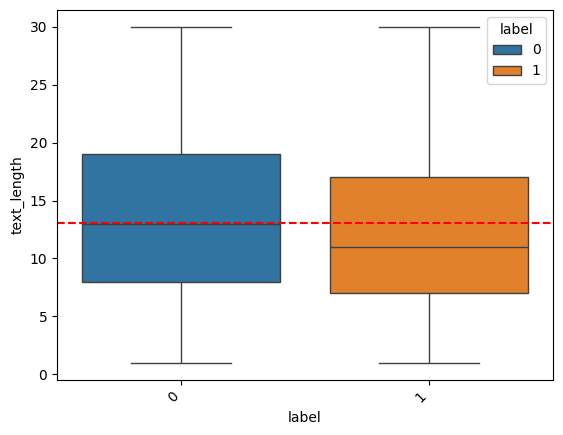

In [10]:
## Summary statistics for text_length
# Calculate multiple statistics
print('Summary Statistics of text_length for positive(1) and negative(0) tweets')
statistics = df_train.groupby('label')['text_length'].agg(['mean', 'median','std', 'min', 'max'])
# Display the result
print(statistics)

print('   ')

print('Plot text_length distribution for positive(1) and negative(0) tweets')
sns.boxplot(data=df_train, x='label', y='text_length',hue = 'label')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_train['text_length'].mean()
plt.axhline(y=mean_reply_length, color='red', linestyle='--', label=f'Mean text Length ({mean_reply_length:.2f})')
# Show the plot
plt.show()

### Data Cleaning
#### Twitter text requires multiple transformations prior to Preprocessing

In [11]:
# Create a TextPreProcessor instance
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used for word segmentation
    segmenter="twitter",
    # corpus from which the word statistics are going to be used for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text, with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons],
    #Remove emoticon
    pre_processor=[lambda x: x.replace('＼(^o^)／', '')]
)

# Pre-process the sentence using TextPreProcessor

def extract_clean(text):
    cleaned_text = ' '.join([word.split('<')[0] for word in text])
    return cleaned_text

def extract_emotions(text):
    emoji_expressions = [token for token in text if token in emoticons.values()]
    return emoji_expressions

def clean_string(text):
    cleaned_text = re.sub(r'\s+', ' ', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def flatten_emotions(emotion_list):
    # Convert the list of emotions into a string
    emotion_string = ', '.join(emotion_list)
    # Use regular expression to find all words inside angle brackets
    emotions = re.findall(r'<([^>]*)>', emotion_string)
    unique_emotions = list(set(emotions))
    combined_emotions = ', '.join(unique_emotions)
    return combined_emotions


def clean_text(df):
# Pre-process all the sentences in df_train['text']
    df['preprocessed_text'] = [text_processor.pre_process_doc(text) for text in df['text']]
    df['clean_text'] = df['preprocessed_text'].apply(extract_clean).apply(clean_string)

    #Getting Hashtags
    df['hashtag'] = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    df['hashtag'] = [' '.join(i) for i in df['hashtag']]

    # Iterate through the preprocessed text
    df['emotions'] = df['preprocessed_text'].apply(extract_emotions)
    df['clean_emotions'] = df['emotions'].apply(flatten_emotions)

    df = df[['text','label','text_length','clean_text','clean_emotions','hashtag']]
    return df

df_train = clean_text(df_train)
df_val = clean_text(df_val)
df_test = clean_text(df_test)

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


### DATA EXPLORATION

#### Hashtags

- 98% of the tweets have no hashtags. Most likely they have been already cleaned.
- Doesn't make sense to keep diving for more insigths.

In [12]:
hashtag_freq = freq_table(df_train,'hashtag')
hashtag_freq = hashtag_freq.sort_values(by='perc',ascending=False)
hashtag_freq['accum'] = hashtag_freq['perc'].cumsum()
print('top 10 hashtags')
display(hashtag_freq[0:10])

top 10 hashtags


,category,count,perc,accum
0,,1175,0.9800,0.9800
2,followfriday,2,0.0017,0.9817
1,hoppusday,2,0.0017,0.9834
13,fb,1,0.0008,0.9842
21,asot400,1,0.0008,0.9850
20,vmware fail,1,0.0008,0.9858
19,1,1,0.0008,0.9866
18,peterfacinelli,1,0.0008,0.9874
17,Apple,1,0.0008,0.9882
16,zombieninja,1,0.0008,0.9890


#### EMOTIONS

- 98% of the tweets have no emotions. Most likely have been already removed.
- Because they directly express the sentiment of the text, we'll concatenate them to our cleaned tweet corpus.

In [13]:
emotions_freq = freq_table(df_train,'clean_emotions')
emotions_freq = emotions_freq.sort_values(by='perc',ascending=False)
emotions_freq['accum'] = emotions_freq['perc'].cumsum()
print('top 10 emotions')
display(emotions_freq[0:10])

top 10 emotions


,category,count,perc,accum
0,,1172,0.9775,0.9775
1,wink,7,0.0058,0.9833
2,annoyed,6,0.0050,0.9883
3,sad,4,0.0033,0.9916
4,laugh,3,0.0025,0.9941
5,surprise,3,0.0025,0.9966
6,happy,1,0.0008,0.9974
7,"happy, wink",1,0.0008,0.9982
8,"tong, annoyed",1,0.0008,0.9990
9,tong,1,0.0008,0.9998


In [14]:
#Concatenate text with emotions
df_train['text_emotion'] = df_train['clean_text']+' '+df_train['clean_emotions']
df_val['text_emotion'] = df_val['clean_text']+' '+df_val['clean_emotions']
df_test['text_emotion'] = df_test['clean_text']+' '+df_test['clean_emotions']


<ipython-input-14-838d5037cb64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['text_emotion'] = df_test['clean_text']+' '+df_test['clean_emotions']


### Preprocessor

In [15]:
## Text mining - Preprocessing, CountVectorizing and tf-idf
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuations = set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_texts = []
        for text in X:
            # Convert text to lowercase
            #text = text.lower()
            text = "".join([char.lower() for char in text if char not in string.punctuation])
            # Tokenize text
            tokens = word_tokenize(text)
            # Remove stopwords and apply lemmatization
            filtered_tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stop_words]
            # Join tokens back into a string
            preprocessed_text = ' '.join(filtered_tokens)
            preprocessed_texts.append(preprocessed_text)

        return preprocessed_texts

In [16]:
sent = ['hello . ! my name is! test .. wuhoo']
pre =TextPreprocessor()
pre.fit(sent)
res = pre.transform(sent)
res

['hello name test wuhoo']

### Exploring positive and negative words using WordCloud

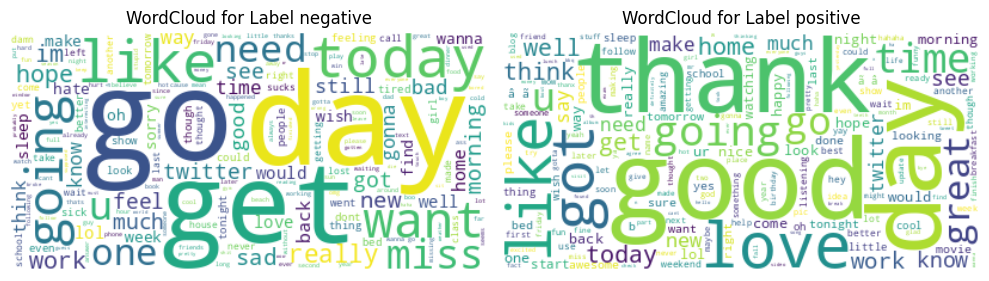

In [17]:
stop_words = set(stopwords.words('english'))

labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_train['clean_text'], df_train['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

### Exploring positive and negative words using TF-IDF + LDA

In [18]:
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train['clean_text'])

Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

### TF-IDF Score

In [19]:
def tfidf_term(pipeline,df,sentiment):
# Access the CountVectorizer step from the pipeline
    count_vectorizer = pipeline.named_steps['vect']
    # Fit and transform the data
    tf_idf_pos_matrix = pipeline.transform(df[df['label']==sentiment]['clean_text'])
    # Convert count matrix to DataFrame
    vec_fr_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    #Creating a dictionary of frequencies for our terms
    feature_names = count_vectorizer.get_feature_names_out()
    # Calculate Term frequency dictionary
    term_tfidf = np.mean(vec_fr_mtx, axis=0)
    #Store in a dictionary
    tfidf_dict = {i: n for i, n in zip(feature_names, term_tfidf)}
    print(len(term_tfidf))
    return feature_names, term_tfidf, tfidf_dict


def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

# Example usage:
def plot_freq_top(df,top,pos):
    df = df.sort_values(by='score',ascending = False)
    df = df.head(top)
    #We are going to set the

    # Plot the top N terms and their TF-IDF scores
    plt.figure(figsize=(10, 6))
    plt.barh(df['terms'], df['score'], align='center')
    plt.yticks(df['terms'])
    plt.xlabel('Frequency Score')
    plt.title(pos.format(top))
    #plt.xlim(0,0.010)
    plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
    plt.show()

271


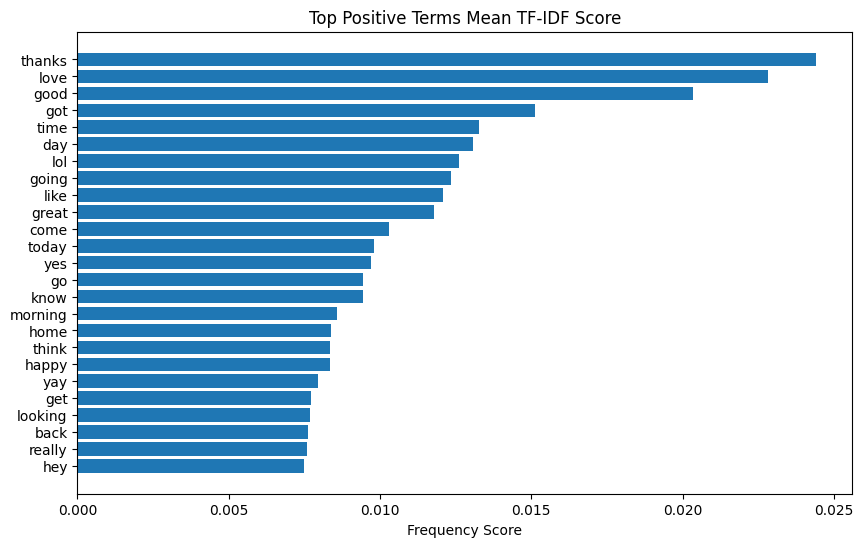

In [20]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

271


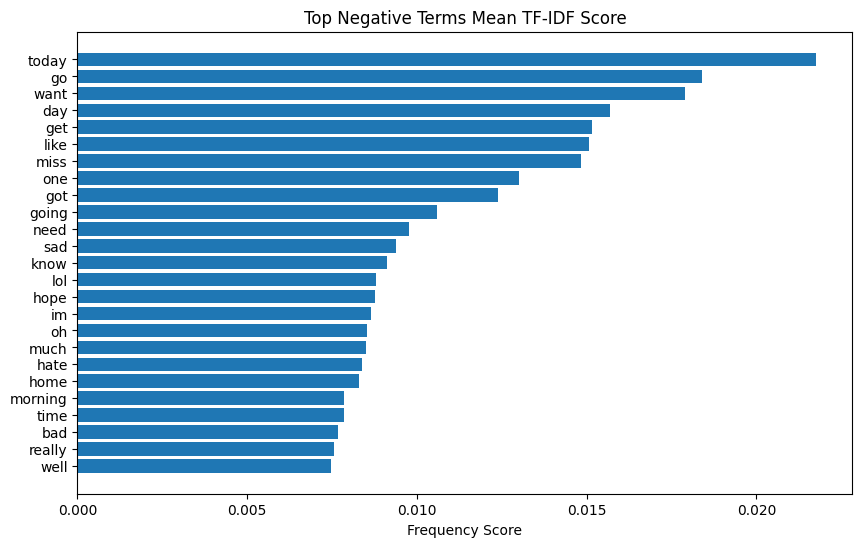

In [21]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

### Analyzing Both Positive and Negative Most Common Topics

In [22]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_pos_matrix = pipeline.transform(df_train[df_train['label']==1]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_pos_matrix.toarray(), columns=pos_feature_names)

# Fit the model to your TF-IDF matrix
lda.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [23]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


# Print top words for each topic
print_top_words(lda, pos_feature_names, n_top_words=10)

Topic #1: love, awesome, look, friend, school, sure, god, ur, thought, put
Topic #2: come, yeah, haha, think, one, hour, show, need, im, use
Topic #3: yes, know, hey, would, weekend, nice, little, later, night, day
Topic #4: thanks, home, help, much, done, video, bye, nothing, making, even
Topic #5: got, great, really, see, back, ya, way, guy, month, definitely
Topic #6: good, looking, want, go, get, best, let, fine, oh, something
Topic #7: like, today, listening, going, trying, another, work, day, great, blog
Topic #8: lol, say, please, funny, life, watching, well, pic, think, find
Topic #9: morning, yay, tonight, going, thank, new, good, breakfast, good morning, lunch
Topic #10: time, happy, bed, follow, day, fun, friday, amazing, made, right


In [24]:
def get_top_words(model, feature_names, n_top_words):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

# Get top words for each topic
top_words_per_topic = get_top_words(lda, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_pos_words = [word for sublist in top_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_pos = set(top_pos_words)

In [25]:
# Specify the number of topics (adjust as needed)
num_topics = 10
# Initialize LDA model
lda2 = LatentDirichletAllocation(n_components=num_topics, random_state=42)

##Creating matrix
tf_idf_neg_matrix = pipeline.transform(df_train[df_train['label']==0]['clean_text'])
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_neg_matrix.toarray(), columns=neg_feature_names)

# Fit the model to your TF-IDF matrix
lda2.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [26]:
# Print top words for each topic
print_top_words(lda2, neg_feature_names, n_top_words=10)

Topic #1: na, oh, tonight, show, already, wan, wan na, girl, yet, gon na
Topic #2: like, one, got, need, win, hour, would, wait, ugh, haha
Topic #3: happened, day, morning, idea, good, drinking, keep, luck, sun, movie
Topic #4: get, home, suck, lost, even, house, class, fun, ah, oh
Topic #5: bad, still, though, aw, final, guy, thing, follow, new, back
Topic #6: want, go, sick, getting, damn, wrong, look, week, get, hate
Topic #7: today, know, sad, right, day, hurt, someone, as, make, one
Topic #8: lol, omg, missing, think, really, sure, well, everyone, im, believe
Topic #9: hope, hate, waiting, call, sorry, working, mean, trying, get, dad
Topic #10: miss, much, time, going, wish, feel, sleep, tweet, bored, game


In [27]:
# Get top words for each topic
topneg_words_per_topic = get_top_words(lda2, pos_feature_names, n_top_words=10)
# Extract words from list of lists
top_neg_words = [word for sublist in topneg_words_per_topic for word in sublist]

# Remove duplicates using set()
unique_neg = set(top_neg_words)

## c. Random Classifier Performance

<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


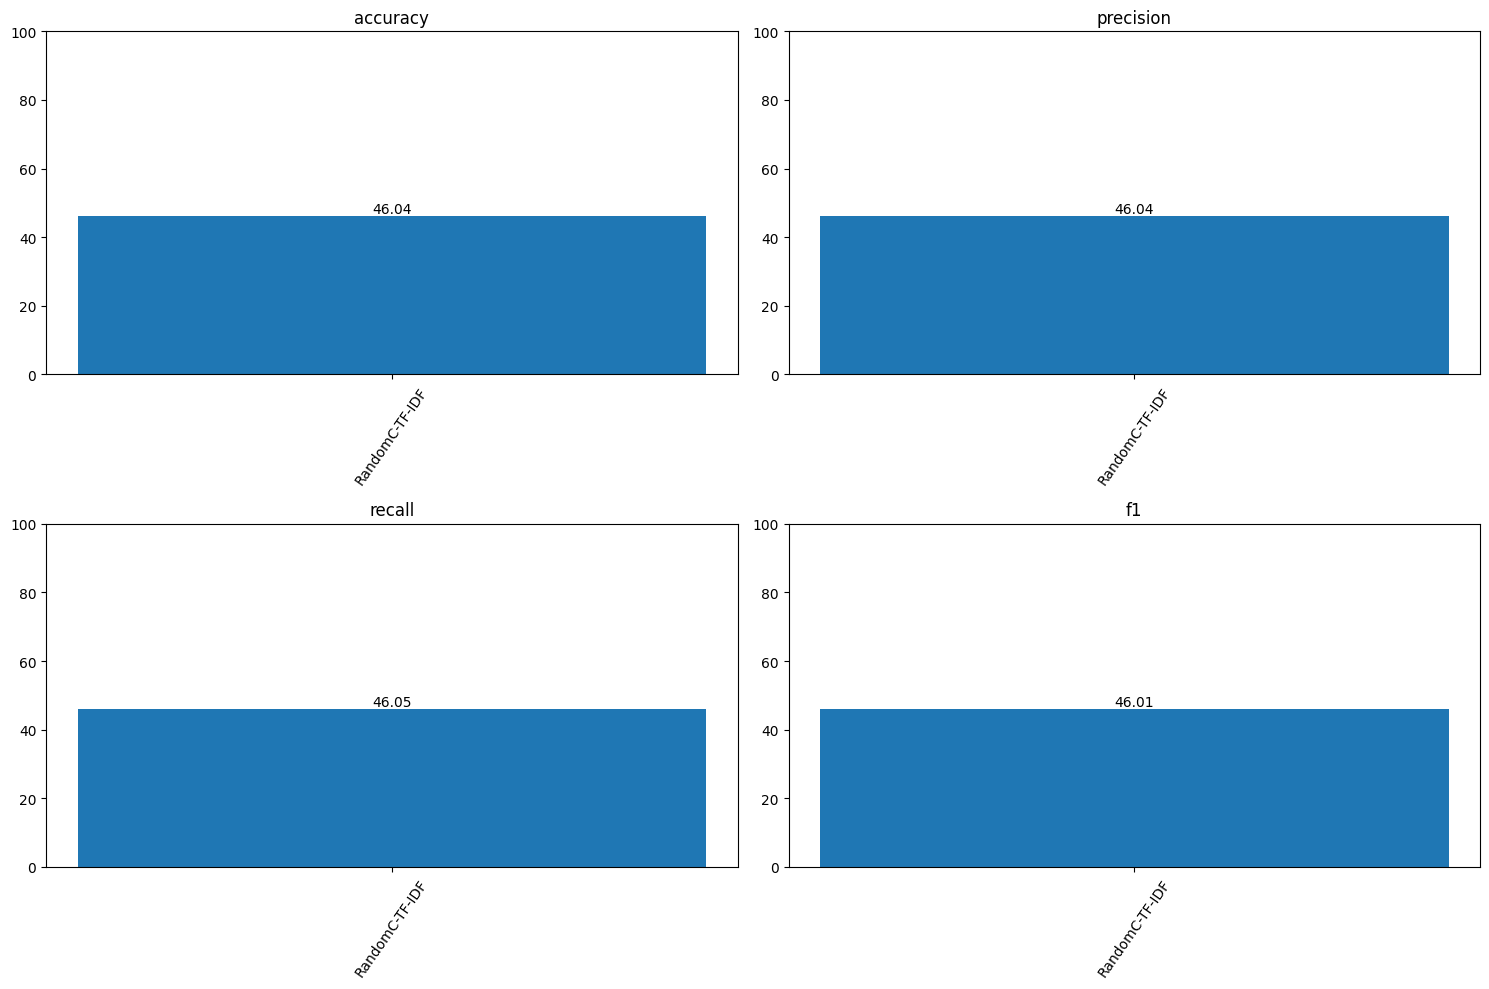

In [28]:
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the classifier to the training data
pipeline.fit(df_train['clean_text'])
##Creating matrix
tf_idf_matrix = pipeline.transform(df_train['clean_text'])
val_idf_matrix = pipeline.transform(df_test['clean_text']) #Changed validation for test
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=tf_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())
val_mtx = pd.DataFrame(data=val_idf_matrix.toarray(), columns=pipeline.named_steps['vect'].get_feature_names_out())

##Innitializing RandomClassifier
dummy_classifier = DummyClassifier(strategy='uniform')
# Fit the classifier to the training data
dummy_classifier.fit(tfidf_mtx, df_train['label'])

# Make predictions on the testing data
y_pred = dummy_classifier.predict(val_mtx)

# Calculate accuracy (or any other metric)
metrics_val= Metrics()
metrics_val.run(test_labels, y_pred, "RandomC-TF-IDF")
metrics_val.plot()


## d. Baseline Implementation

### Rule-Based using Spacy Matcher

In [29]:
## Call positive words from Positive LDA
print(unique_pos)

{'bed', 'day', 'ya', 'best', 'say', 'let', 'oh', 'thanks', 'like', 'nothing', 'friday', 'school', 'sure', 'fun', 'haha', 'morning', 'back', 'breakfast', 'show', 'friend', 'much', 'right', 'got', 'look', 'way', 'really', 'made', 'tonight', 'yeah', 'see', 'good', 'fine', 'hour', 'work', 'happy', 'month', 'love', 'find', 'lol', 'need', 'get', 'please', 'im', 'today', 'time', 'lunch', 'listening', 'blog', 'help', 'good morning', 'think', 'use', 'put', 'done', 'bye', 'later', 'watching', 'another', 'pic', 'yay', 'even', 'little', 'guy', 'want', 'weekend', 'looking', 'new', 'home', 'ur', 'hey', 'video', 'amazing', 'trying', 'yes', 'know', 'god', 'would', 'come', 'great', 'definitely', 'night', 'nice', 'funny', 'one', 'life', 'well', 'thank', 'awesome', 'going', 'follow', 'go', 'thought', 'making', 'something'}


In [30]:
## Get all the most relevant positive terms
positives = ['cute','aw','best','happy','haha',
             'amazing','fun','great','yay','love',
             'lol','excited','awesome','wow','nice','beautiful',
             'cool','glad','good']

print(positives)

['cute', 'aw', 'best', 'happy', 'haha', 'amazing', 'fun', 'great', 'yay', 'love', 'lol', 'excited', 'awesome', 'wow', 'nice', 'beautiful', 'cool', 'glad', 'good']


In [31]:
## Call negative words from Negative LDA
print(unique_neg)

{'day', 'though', 'make', 'call', 'sorry', 'oh', 'lost', 'sleep', 'class', 'like', 'girl', 'wait', 'na', 'luck', 'damn', 'dad', 'fun', 'sure', 'ugh', 'haha', 'morning', 'suck', 'back', 'show', 'still', 'much', 'right', 'as', 'getting', 'sad', 'wrong', 'tweet', 'got', 'look', 'idea', 'yet', 'really', 'sun', 'aw', 'working', 'tonight', 'good', 'wish', 'hour', 'miss', 'mean', 'happened', 'thing', 'game', 'movie', 'lol', 'need', 'feel', 'get', 'gon na', 'wan', 'house', 'omg', 'im', 'sick', 'today', 'time', 'hope', 'think', 'believe', 'even', 'guy', 'want', 'new', 'home', 'waiting', 'week', 'trying', 'already', 'missing', 'know', 'hate', 'wan na', 'would', 'final', 'drinking', 'ah', 'one', 'win', 'hurt', 'everyone', 'well', 'someone', 'keep', 'bad', 'going', 'follow', 'go', 'bored'}


In [32]:
## Get all the most relevant negative terms
negatives = ['sick','hurt','tired','hate','bad',
             'damn','never','miss','suck','sorry',
             'ugh','sad','lost', 'bored']

print(negatives)

['sick', 'hurt', 'tired', 'hate', 'bad', 'damn', 'never', 'miss', 'suck', 'sorry', 'ugh', 'sad', 'lost', 'bored']


### Implement rule-based conditions for our baseline model

In [33]:
#loading and initializing nlp object
nlp = spacy.load('en_core_web_sm')
## Initializing Matcher
matcher = Matcher(nlp.vocab)

In [34]:
## Initializing Matcher
matcher = Matcher(nlp.vocab)

# based on LDA unique positive words
positive_patterns = [
    [{'LOWER': 'cute'}],
    [{'LOWER': 'aw'}],
    [{'LOWER': 'best'}],
    [{'LOWER': 'happy'}],
    [{'LOWER': 'haha'}],
    [{'LOWER': 'amazing'}],
    [{'LOWER': 'fun'}],
    [{'LOWER': 'great'}],
    [{'LOWER': 'yay'}],
    [{'LOWER': 'love'}],
    [{'LOWER': 'lol'}],
    [{'LOWER': 'excited'}],
    [{'LOWER': 'awesome'}],
    [{'LOWER': 'wow'}],
    [{'LOWER': 'nice'}],
    [{'LOWER': 'beautiful'}],
    [{'LOWER': 'cool'}],
    [{'LOWER': 'glad'}],
    [{'LOWER': 'good'}]
]


# based on LDA unique negative words
negative_patterns = [
    [{'LOWER': 'sick'}],
    [{'LOWER': 'hurt'}],
    [{'LOWER': 'tired'}],
    [{'LOWER': 'hate'}],
    [{'LOWER': 'bad'}],
    [{'LOWER': 'damn'}],
    [{'LOWER': 'never'}],
    [{'LOWER': 'miss'}],
    [{'LOWER': 'suck'}],
    [{'LOWER': 'sorry'}],
    [{'LOWER': 'ugh'}],
    [{'LOWER': 'sad'}],
    [{'LOWER': 'lost'}],
    [{'LOWER': 'bored'}]
]


## Adding patterns to matcher
matcher.add('positives',positive_patterns)
matcher.add('negatives',negative_patterns)

In [35]:
#Matching elements in documents
## Matching VALIDATION
docs_v = [nlp(doc) for doc in df_test['clean_text']]
matches_v = [matcher(d) for d in docs_v]

In [36]:
def matching_func(d,ms):
    #Return the index and the total number of matches per row
    rows_data = []
    for (i, match),doc in zip(enumerate(ms),d):
        #variables for defining current row/index
        row = 0
        row=i
        # positive variables
        positives = 0
        pos_w = []
        # negative variables
        negatives = 0
        neg_w = []

        diction = {'index':0,'total':0, 'positive':0 ,'negative':0,'pos_words':[],'neg_words':[]}
        # Filling dictionary
        diction['index'] = row
        diction['total'] = len(match)

        for match_id, start, end in match:
            if nlp.vocab.strings[match_id] == "positives":
                # store positive matched words
                pos_words = doc[start:end].text
                pos_w.append(pos_words)
                #diction['pos_words'] = pos_w
                # store number of positive words
                positives = len(pos_w)
                diction['positive'] = positives
            elif nlp.vocab.strings[match_id] == "negatives":
                # store negative matched words
                neg_words = doc[start:end].text
                neg_w.append(neg_words)
                #diction['neg_words'] = neg_w
                # store number of negative words
                negatives = len(neg_w)
                diction['negative'] = negatives

        #Add words matched to dictionary
        diction['pos_words'] = pos_w
        #diction['positive'] = positives
        diction['neg_words'] = neg_w
        #diction['negative'] = negatives

        diction = {k: np.nan if (not v and v != 0) else v for k, v in diction.items()}

        rows_data.append(diction)

    df = pd.DataFrame(rows_data)
    return df
        #print(diction['index'],' ',diction['total'],' ',diction['pos_words'],' ',diction['positive'],' ',diction['neg_words'],' ',diction['negative'])

In [37]:
va_df = matching_func(docs_v,matches_v)
va_df

,index,total,positive,negative,pos_words,neg_words
0,0,1,1,0,[haha],NaN
1,1,0,0,0,NaN,NaN
2,2,0,0,0,NaN,NaN
3,3,2,1,1,[excited],[bad]
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
614,614,0,0,0,NaN,NaN
615,615,0,0,0,NaN,NaN
616,616,0,0,0,NaN,NaN
617,617,1,0,1,NaN,[miss]


In [38]:
# Create a new column 'proba' where 1 is returned if positives are greater than negatives, else 0
threshold = 0.5

va_df['proba'] = np.where(va_df['total'] != 0, (va_df['positive'] / va_df['total']) > threshold, 0)
va_df

,index,total,positive,negative,pos_words,neg_words,proba
0,0,1,1,0,[haha],NaN,1
1,1,0,0,0,NaN,NaN,0
2,2,0,0,0,NaN,NaN,0
3,3,2,1,1,[excited],[bad],0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
614,614,0,0,0,NaN,NaN,0
615,615,0,0,0,NaN,NaN,0
616,616,0,0,0,NaN,NaN,0
617,617,1,0,1,NaN,[miss],0


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


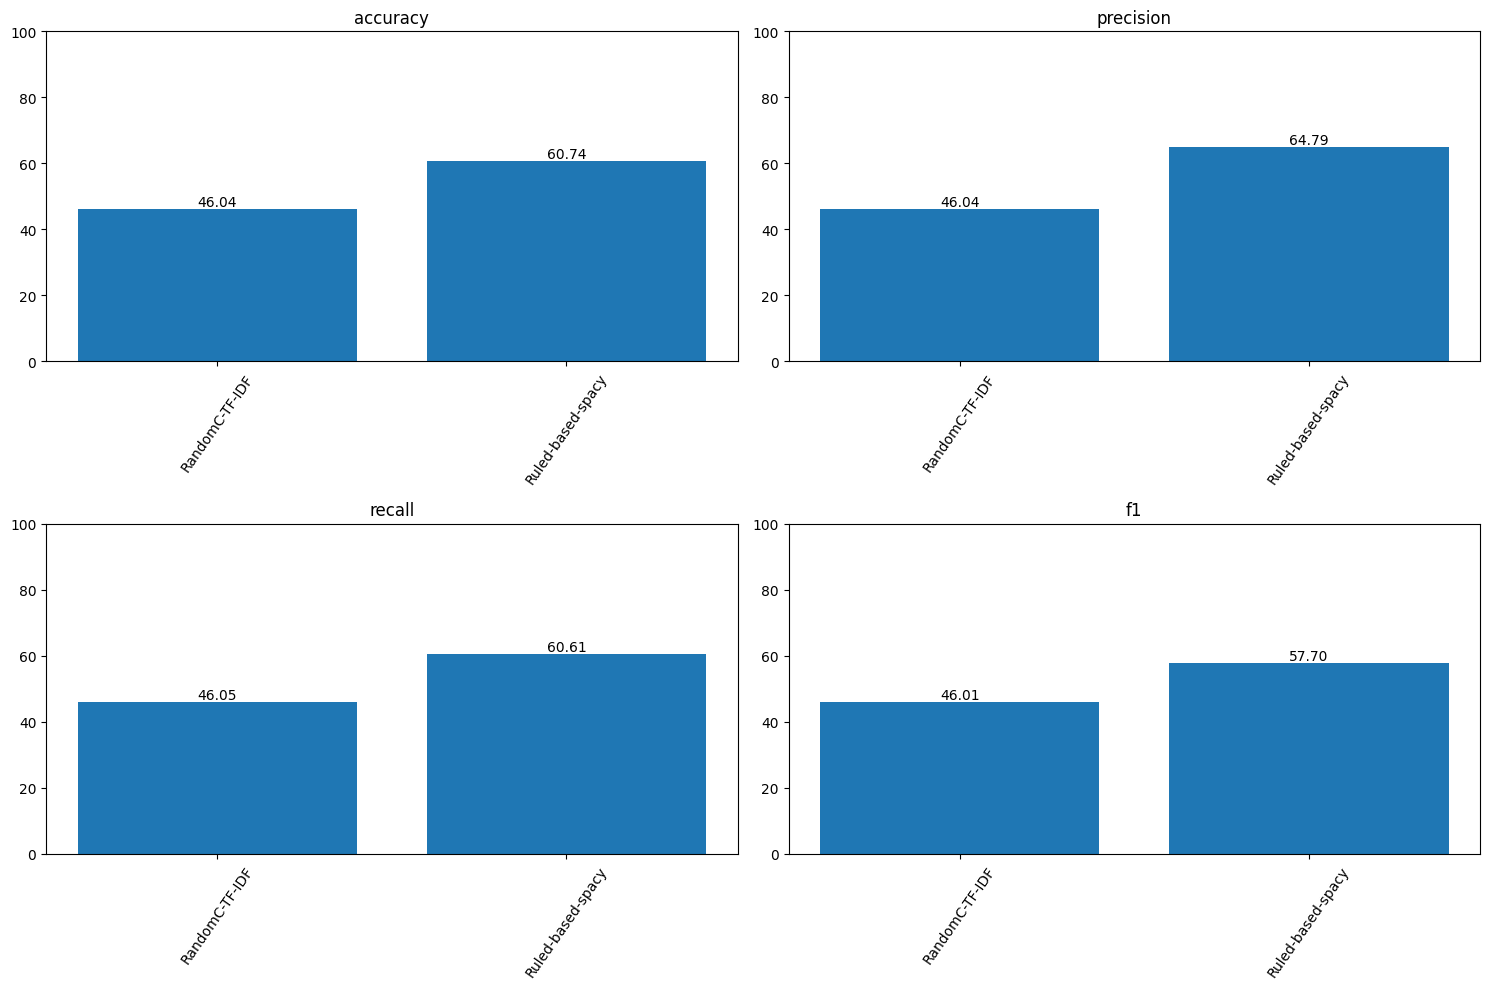

In [39]:
## Comparing with Random
metrics_val.run(test_labels, va_df['proba'], "Ruled-based-spacy")
metrics_val.plot()

### Error Analysis

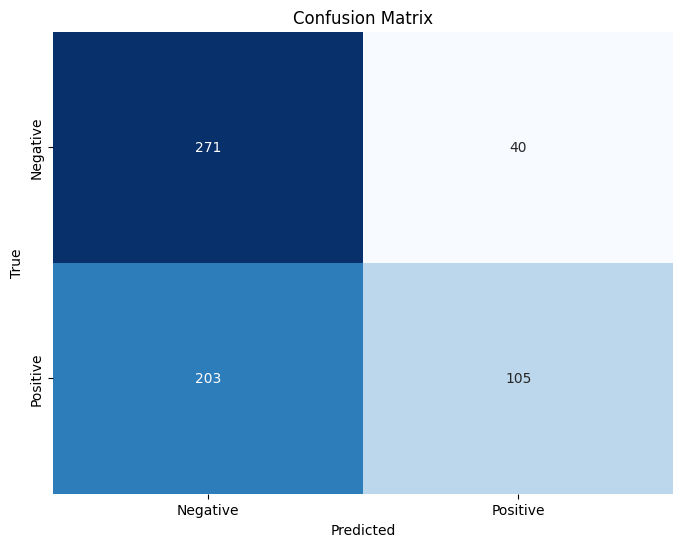

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, va_df['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
df_val2 = df_test.copy()

#Create an index column to join with our prediction results
df_val2 = df_val2.reset_index()

## Merge with new data
merged_data = df_val2.merge(va_df[['index','proba']],how='left',left_on='index',right_on='index',suffixes=['_tr','_df'])
merged_data.head()

,index,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,proba
0,0,@shantchuason google~ haha. ur gna sleep na? ...,1,18,google ~ haha . ur gna sleep na ? i am at my f...,,,google ~ haha . ur gna sleep na ? i am at my f...,1
1,1,WHOA! if you added from youtube thanks for wat...,1,22,whoa ! if you added from youtube thanks for wa...,,,whoa ! if you added from youtube thanks for wa...,0
2,2,what the fuck am i really doing???,0,7,what the fuck am i really doing ?,,,what the fuck am i really doing ?,0
3,3,GO THE TIGERS!!!! we finally won three games. ...,0,16,go the tigers ! we finally won three games . s...,,,go the tigers ! we finally won three games . s...,0
4,4,@JustUrAvgJoe its ok i'm still going to 4 eve...,0,18,its ok i am still going to events . but the op...,,,its ok i am still going to events . but the op...,0


In [42]:
## Printing False Negatives
print('MISSCLASSIFIED TWEETS EXPLORATION')
for i in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text'][0:25]:
    print(i)

MISSCLASSIFIED TWEETS EXPLORATION
whoa ! if you added from youtube thanks for watchingg btw if you dont have me on youtube check out my vidz . jbisahhmazing !
iphone specs , rumoured of course
i want my alice
just bought a skullcandy chop . gonna get the proper ones in sg ! yays . btw , need intensive gymming .
and you can not even blame the beer

playing lion game on discovery channel . lame ? i think not more like addictive .
hey ashley its anna hagnauer . im just tryin this twitter thing out but . hey !
figuring out twitter too
just got done planting ( in the ground ) sunflower plants that clay grew from seed , and a hydrangea yeay , earth !
recently discovered that hitting escape resets the firefox location bar to the current url & favicon , no matter whar you have done to it .
ahh death race such an awesomely bad film whod have thought stallone could get moar wooden as his career progressed
subway , thank you for helping me to eat fresh
i can not wait to see you are next comic ger

### How can we reduce the amount of false negatives?

Twitter data presents certain challenges:

- Frequently, we encounter questions that lack clear sentiment expression.
- Sometimes, the count of positive and negative instances is equal, leading to classification as negatives based on our threshold.
- Given the intricate variety of positive patterns, we won't be able to cover all possibilities, therefore increasing the number of false negatives.
- Positive and negative sarcasm further complicates accurate classification, as seen in examples like: "I live in a basement. That's why I am so mysterious."


Proposal to reduce False negatives  

To address the issue of false negatives, we suggest a strategy suited to the complexity of tweets, characterized by informal language. Our plan involves conducting regular error analyses and augmenting our matcher patterns with new positive patterns. This iterative approach aims to develop a robust classifier capable of capturing all positive patterns accurately over time. However, we must also devise methods to handle neutral tweets and positive/negative sarcasm.

- Our initial step entails identifying missing positive patterns within misclassified tweets and incorporating them into our matcher.





271


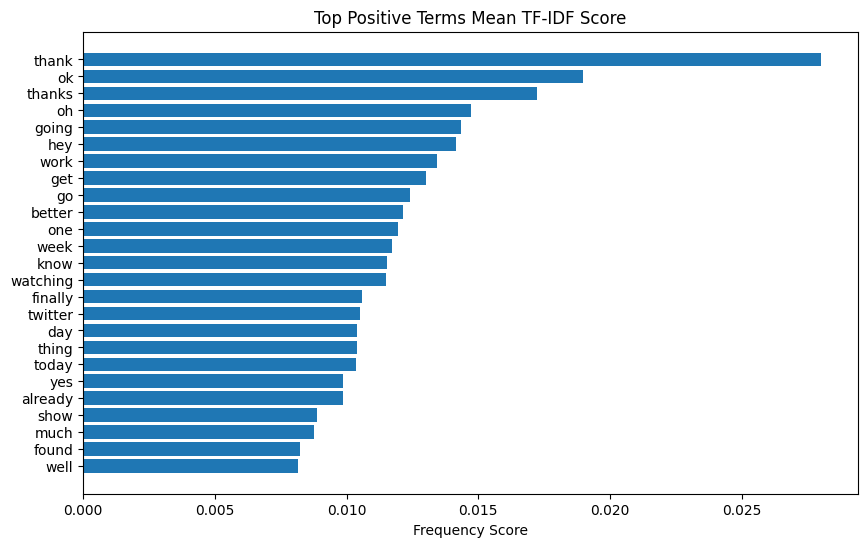

In [43]:
## Plot TFIDF identify missing positive patterns
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)],1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

In [44]:
#Identifying positive patterns:
positives2 = ['thanks','new','like','thank','well']

print(positives2)

['thanks', 'new', 'like', 'thank', 'well']


In [45]:
## Adding new patterns to matcher
# based on word cloud
positive_patterns2 = [
    [{'LOWER': 'thanks'}],
    [{'LOWER': 'new'}],
    [{'LOWER': 'like'}],
    [{'LOWER': 'thank'}],
    [{'LOWER': 'well'}]
]

## Adding patterns to matcher
matcher.add('positives',positive_patterns2)

In [46]:
#Matching elements in documents
## Matching VALIDATION
docs_v2 = [nlp(doc) for doc in merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['clean_text']]
matches_v2 = [matcher(d) for d in docs_v2]

In [47]:
va_df2 = matching_func(docs_v2,matches_v2)
va_df2

,index,total,positive,negative,pos_words,neg_words
0,0,1,1,0,[thanks],NaN
1,1,0,0,0,NaN,NaN
2,2,0,0,0,NaN,NaN
3,3,0,0,0,NaN,NaN
4,4,0,0,0,NaN,NaN
...,...,...,...,...,...,...
198,198,1,1,0,[thanks],NaN
199,199,0,0,0,NaN,NaN
200,200,0,0,0,NaN,NaN
201,201,0,0,0,NaN,NaN


In [48]:
va_df2['proba'] = np.where(va_df2['total'] != 0, (va_df2['positive'] / va_df2['total']) > threshold, 0)
va_df2

,index,total,positive,negative,pos_words,neg_words,proba
0,0,1,1,0,[thanks],NaN,1
1,1,0,0,0,NaN,NaN,0
2,2,0,0,0,NaN,NaN,0
3,3,0,0,0,NaN,NaN,0
4,4,0,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...
198,198,1,1,0,[thanks],NaN,1
199,199,0,0,0,NaN,NaN,0
200,200,0,0,0,NaN,NaN,0
201,201,0,0,0,NaN,NaN,0


In [49]:
## Checking That lens for both results match
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']) == len(va_df2['proba']))
print(len(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']))
print(len(va_df2['proba']))

True
203
203


In [50]:
#check if missing values
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba'].isna().mean())
print(va_df2['proba'].isna().mean())

0.0
0.0


In [51]:
# Different indexes
print(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index)
print(va_df2.index)

Int64Index([  1,   7,   8,  10,  14,  16,  19,  21,  31,  34,
            ...
            586, 587, 588, 590, 592, 593, 597, 610, 614, 615],
           dtype='int64', length=203)
RangeIndex(start=0, stop=203, step=1)


In [52]:
# Make copies of the dataframes
merged_data_copy = merged_data.copy()
va_df2_copy = va_df2.copy()

# Find the subset indices in the copied dataframe


df_merge = pd.DataFrame({'index':merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)].index,
                         'proba1':(merged_data[(merged_data['label'] ==1)&(merged_data['proba'] ==0)]['proba']).tolist(),
                         'proba2':va_df2['proba'].tolist()
                         })

df_merge['proba3'] = np.where(df_merge['proba1'] != df_merge['proba2'], df_merge['proba2'], df_merge['proba1'])
df_merge.set_index('index', inplace=True)
df_merge

,proba1,proba2,proba3
index,,,
1,0,1,1
7,0,0,0
8,0,0,0
10,0,0,0
14,0,0,0
...,...,...,...
593,0,1,1
597,0,0,0
610,0,0,0


In [53]:
#Now that we made sure that indexes will match, replace in merged data:
for index, value in zip(merged_data_copy[(merged_data_copy['label'] == 1) & (merged_data_copy['proba'] == 0)].index, df_merge['proba3']):
    merged_data_copy.loc[index, 'proba'] = value

---

<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


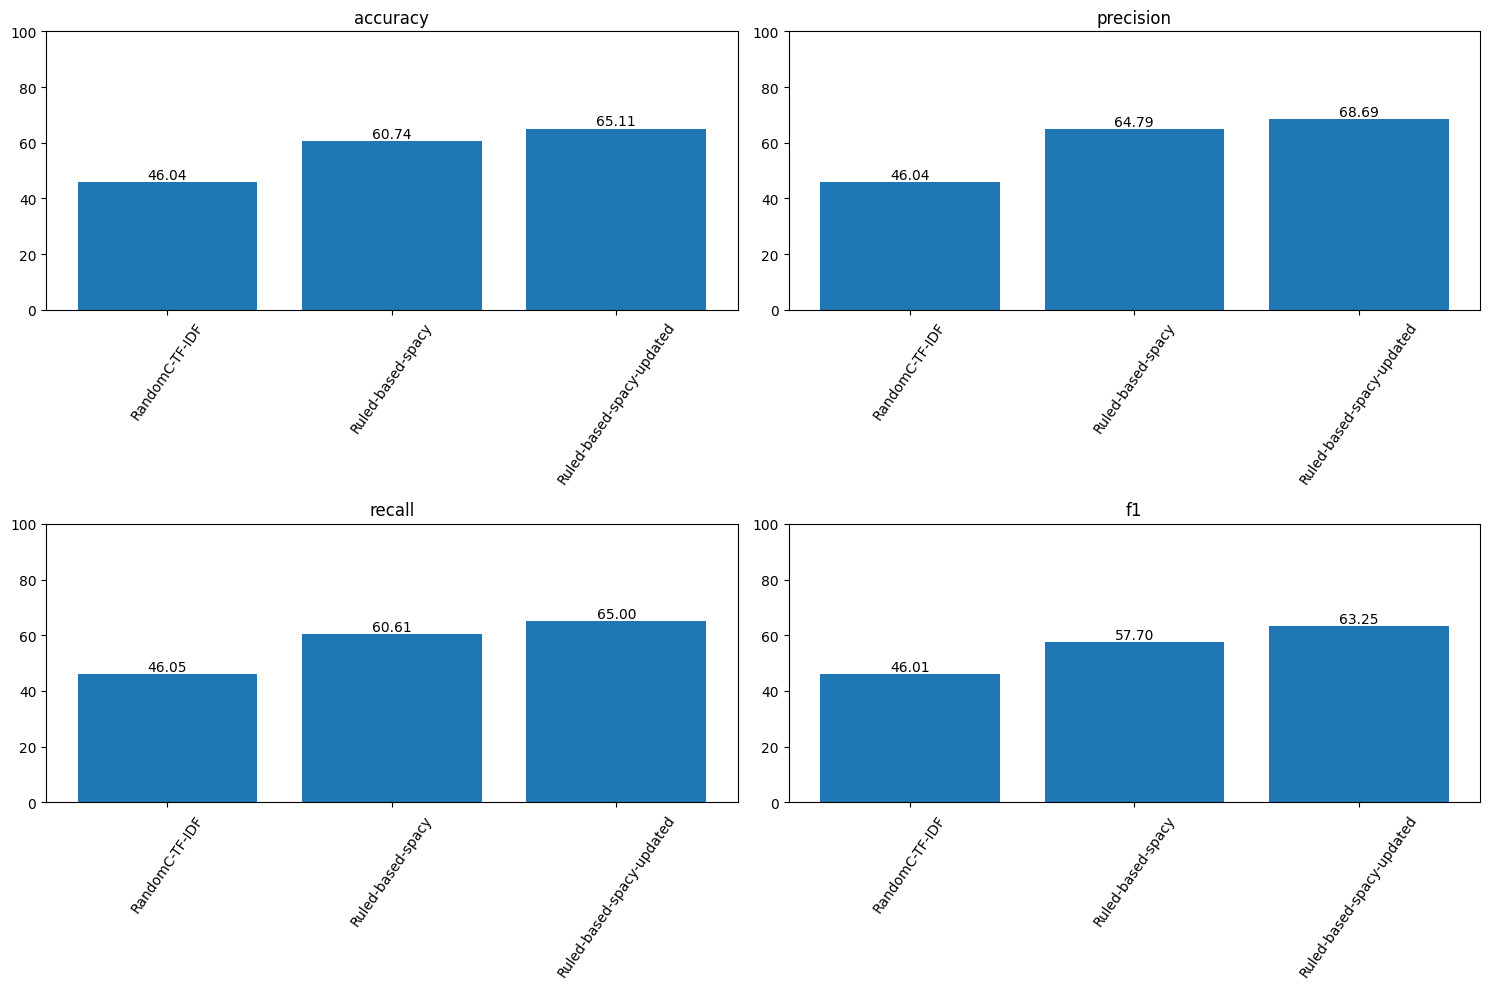

In [54]:
metrics_val.run(test_labels, merged_data_copy['proba'], "Ruled-based-spacy-updated")
metrics_val.plot()

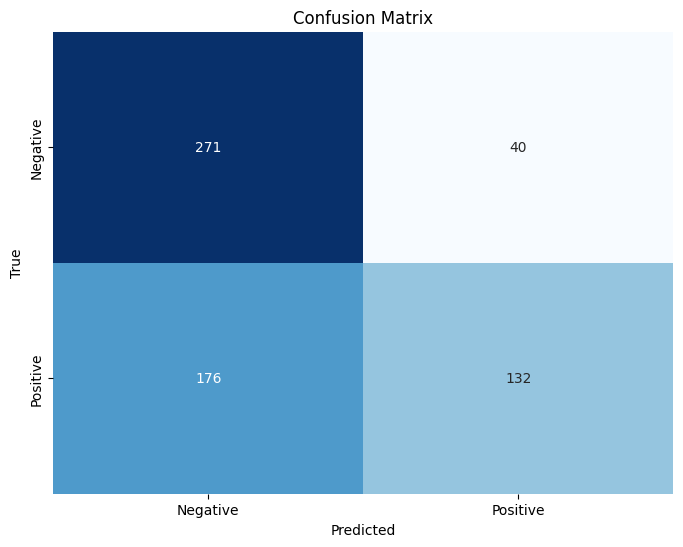

In [55]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels,  merged_data_copy['proba'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### We managed to reduce the number of false negatives by 15% after incorporating the new batch of positive patterns learned from the error analysis

### Rule-Based Benchmark with Vader

In [57]:
# Initialize the SentimentIntensityAnalyzer.
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']

# Calculate compound score and get tweet length
df_test['sentiment'] = df_test['clean_text'].apply(function)
df_test['clean_length'] = [len(i.split()) for i in df_test['clean_text']]

test = df_test[['clean_text','clean_length','sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [58]:
#Adding Sentiment Label
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

df_test['sentiment_label'] = df_test['sentiment'].apply(getAnalysis)

#Scaling score to the length of the review
df_test.head(5)

,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion,sentiment,clean_length,sentiment_label
0,@shantchuason google~ haha. ur gna sleep na? ...,1,18,google ~ haha . ur gna sleep na ? i am at my f...,,,google ~ haha . ur gna sleep na ? i am at my f...,0.7351,23,Positive
1,WHOA! if you added from youtube thanks for wat...,1,22,whoa ! if you added from youtube thanks for wa...,,,whoa ! if you added from youtube thanks for wa...,0.5399,25,Positive
2,what the fuck am i really doing???,0,7,what the fuck am i really doing ?,,,what the fuck am i really doing ?,-0.5423,8,Negative
3,GO THE TIGERS!!!! we finally won three games. ...,0,16,go the tigers ! we finally won three games . s...,,,go the tigers ! we finally won three games . s...,-0.3887,19,Negative
4,@JustUrAvgJoe its ok i'm still going to 4 eve...,0,18,its ok i am still going to events . but the op...,,,its ok i am still going to events . but the op...,0.1531,20,Positive


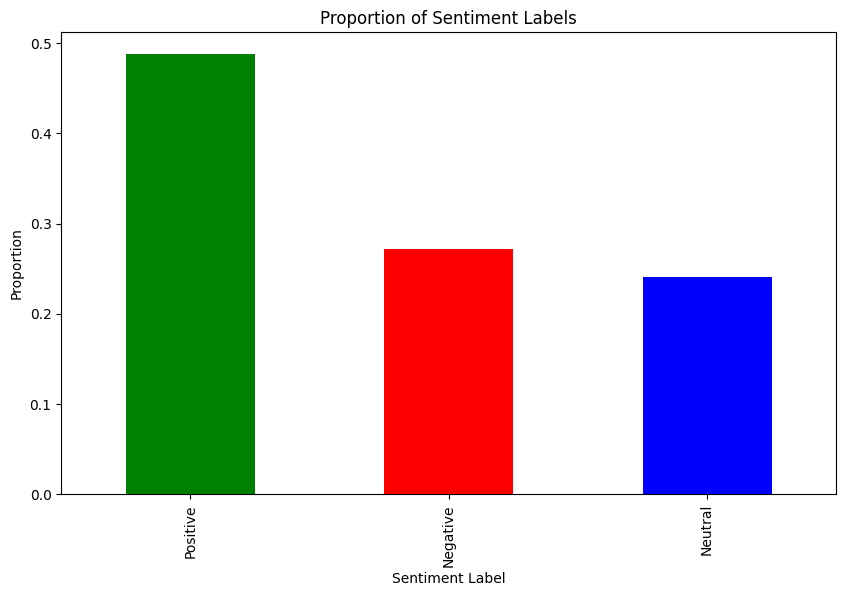

In [59]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()

### Looking at WordCloud for inspection of Neutral Words

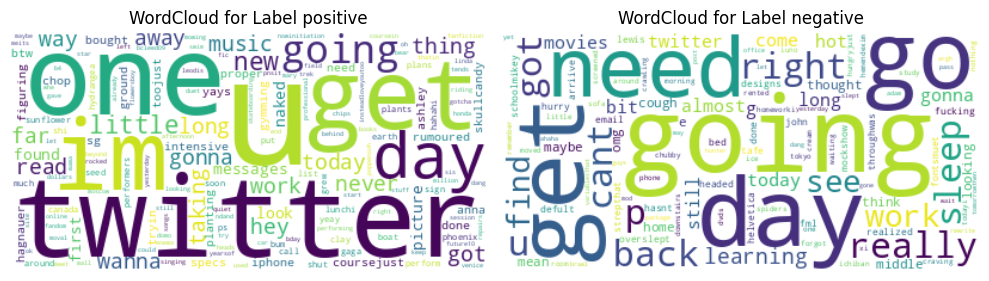

In [60]:
## Looking at a WordCloud to inspect the words in neutral
labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_test[df_test['sentiment_label']=='Neutral']['clean_text'], df_test[df_test['sentiment_label']=='Neutral']['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

### Classifying Neutral tweets

In [61]:
#Clasifying neutral
# Iterate over rows of DataFrame where 'sentiment_label' is 'Neutral'
for index, row in df_test[df_test['sentiment_label'] == 'Neutral'].iterrows():
    # Analyze sentiment of the text
    score = vader.polarity_scores(row['clean_text'])
    if score['compound'] == 0:  # Positive sentiment
        df_test.at[index, 'sentiment_label'] = 'Negative' ##Any tweet that has no good emotion will be treated as negative
    else:  # Neutral sentiment
        df_test.at[index, 'sentiment_label'] = 'Positive'

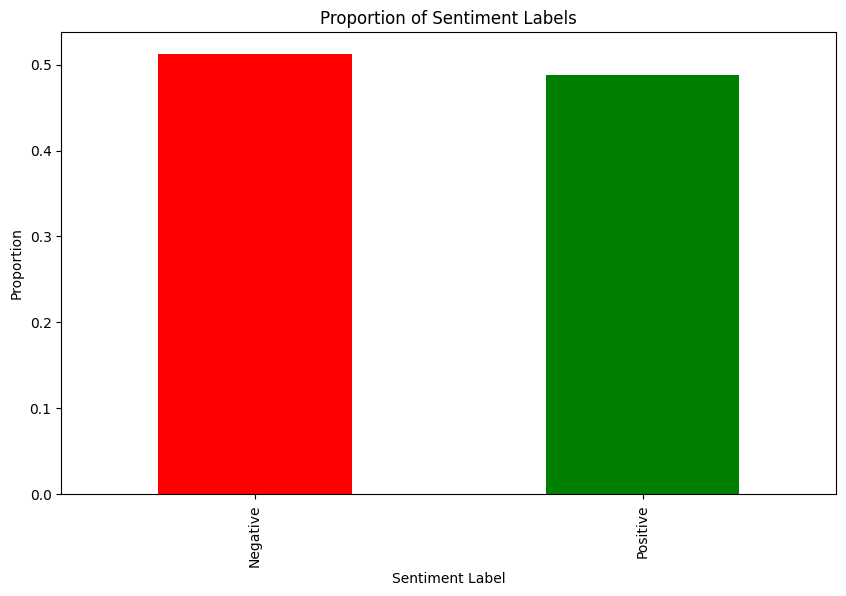

In [62]:
# Get counts of each category in 'sentiment_label'
sentiment_counts = df_test['sentiment_label'].value_counts()

# Calculate proportion of each category
total_samples = len(df_test)
sentiment_proportions = sentiment_counts / total_samples

# Define colors for each sentiment
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}

# Plot bar chart with colors
sentiment_proportions.plot(kind='bar', figsize=(10, 6), color=[colors[label] for label in sentiment_proportions.index])

# Set labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels')

# Show plot
plt.show()

### Rule-Based Model Performance

In [63]:
#Convert to binary
df_test['sentiment_label'] = [1 if x == 'Positive' else 0 for x in df_test['sentiment_label']]
y_pred = df_test['sentiment_label']
original_labels = df_test['label']

<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


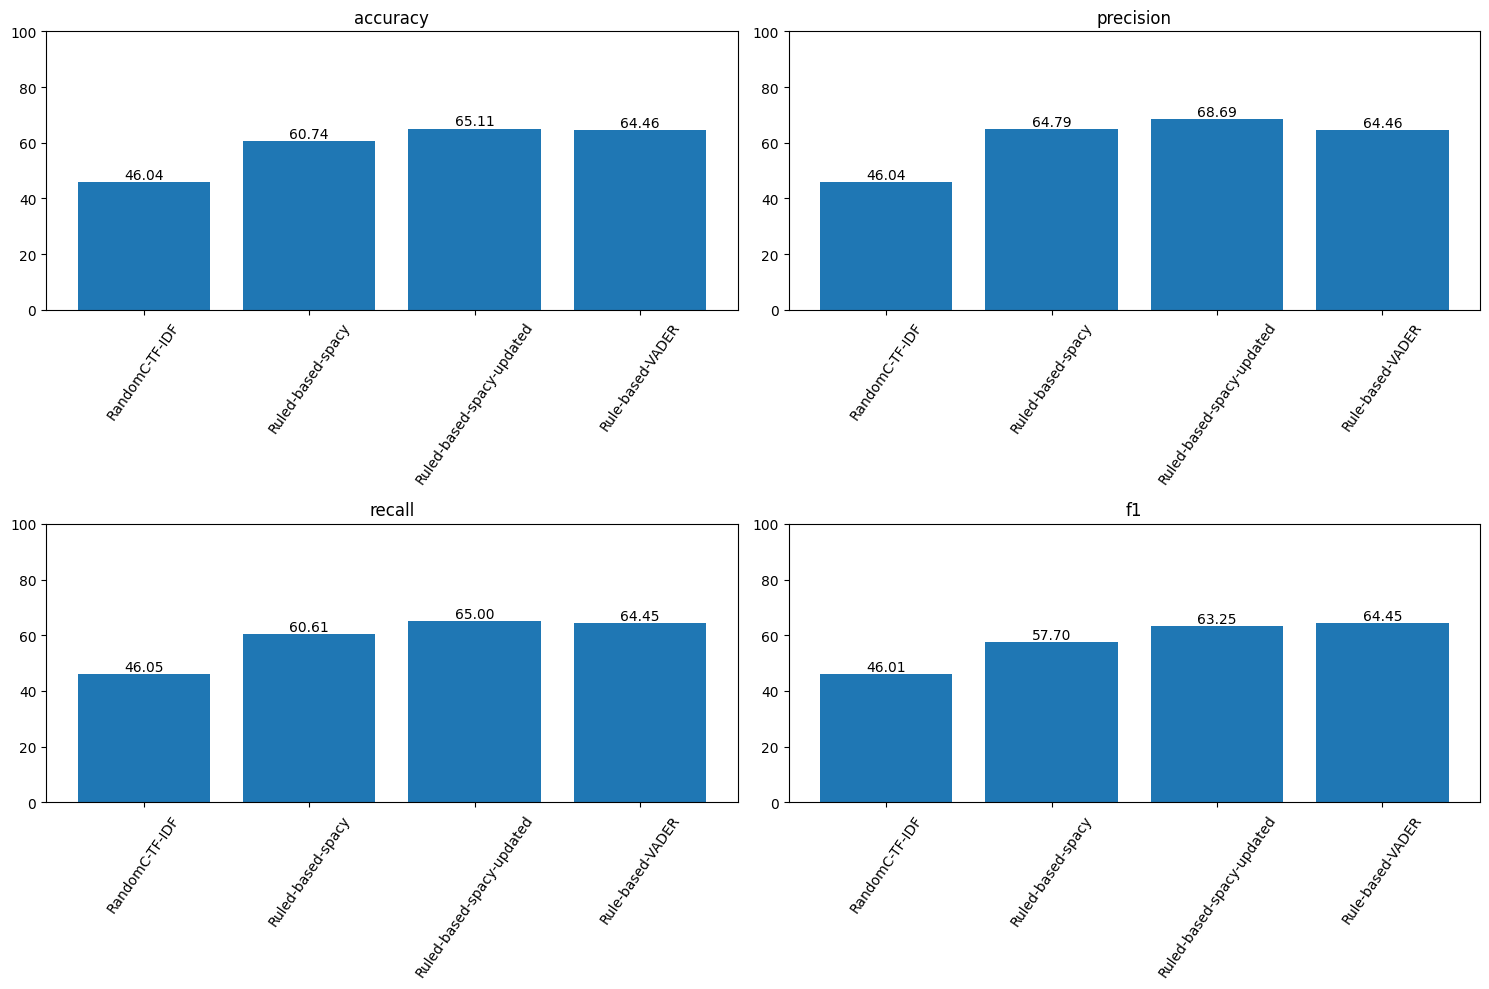

In [64]:
## Model Performance
metrics_val.run(original_labels, y_pred, "Rule-based-VADER")
metrics_val.plot()

---

# Part 2: Data Scientist Challenge
## a. BERT Model with Limited Data

#### In the following exercises we will work with clean text.

In [65]:
train_data_clean = df_train['clean_text']
validation_data_clean = df_val['clean_text']
test_data_clean = df_test['clean_text']

In [66]:
# First, we'll select 32 random rows from the DataFrame using the sample method.
df_train_32 = df_train.sample(n=32)

In [67]:
train_data_32 = df_train_32['clean_text']
train_labels_32 = df_train_32['label']

### BERT SETUP

In [68]:
checkpoint="cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=  8 # impossible to have bigger batch as far as we have just 32 observations in the train
max_length= 40 # fine for the length of the sentences in our dataset - changed it according to the distribution
rate =     0.5 # dropout parameters - tried different options, 0.5 still performs better
num_labels = len(np.unique(validation_labels))

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [69]:
## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
output_layer = tf.keras.layers.Dropout(rate)(embedding_layer)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)

bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_token[0][0]',         
 aModel)                     ngAndCrossAttentions(last_   32         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [70]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [71]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels_32).reshape(-1, 1)).toarray()

In [72]:
# Define a custom generator function that yields batches and updates the tqdm progress bar
def tqdm_generator(generator, steps_per_epoch):
    for batch in tqdm(generator, total=steps_per_epoch, desc="Epoch"):
        yield batch

X_train = np.array(train_data_32)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/2


Epoch:  25%|██▌       | 1/4 [00:29<01:29, 30.00s/it]

1/4 [======>.......................] - ETA: 1:32 - loss: 1.0899 - recall: 0.6250 - precision: 0.6250

Epoch:  75%|███████▌  | 3/4 [00:31<00:08,  8.16s/it]

2/4 [==============>...............] - ETA: 1s - loss: 1.1643 - recall: 0.5625 - precision: 0.5625  

Epoch: 100%|██████████| 4/4 [00:31<00:00,  5.65s/it]

3/4 [=====================>........] - ETA: 0s - loss: 1.1536 - recall: 0.5417 - precision: 0.5417

Epoch: 5it [00:32,  4.07s/it]                       

4/4 [==============================] - 34s 893ms/step - loss: 1.2776 - recall: 0.4375 - precision: 0.4375
Epoch 2/2


Epoch: 6it [00:33,  3.05s/it]

1/4 [======>.......................] - ETA: 2s - loss: 0.4003 - recall: 0.8750 - precision: 0.8750

Epoch: 7it [00:34,  2.38s/it]

2/4 [==============>...............] - ETA: 1s - loss: 0.5240 - recall: 0.8125 - precision: 0.8125

Epoch: 8it [00:35,  1.89s/it]

3/4 [=====================>........] - ETA: 0s - loss: 0.5481 - recall: 0.7917 - precision: 0.7917

Epoch: 9it [00:36,  1.58s/it]

4/4 [==============================] - 3s 825ms/step - loss: 0.7095 - recall: 0.7188 - precision: 0.7188


In [73]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data_clean),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)


20/20 [==============================] - 19s 595ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


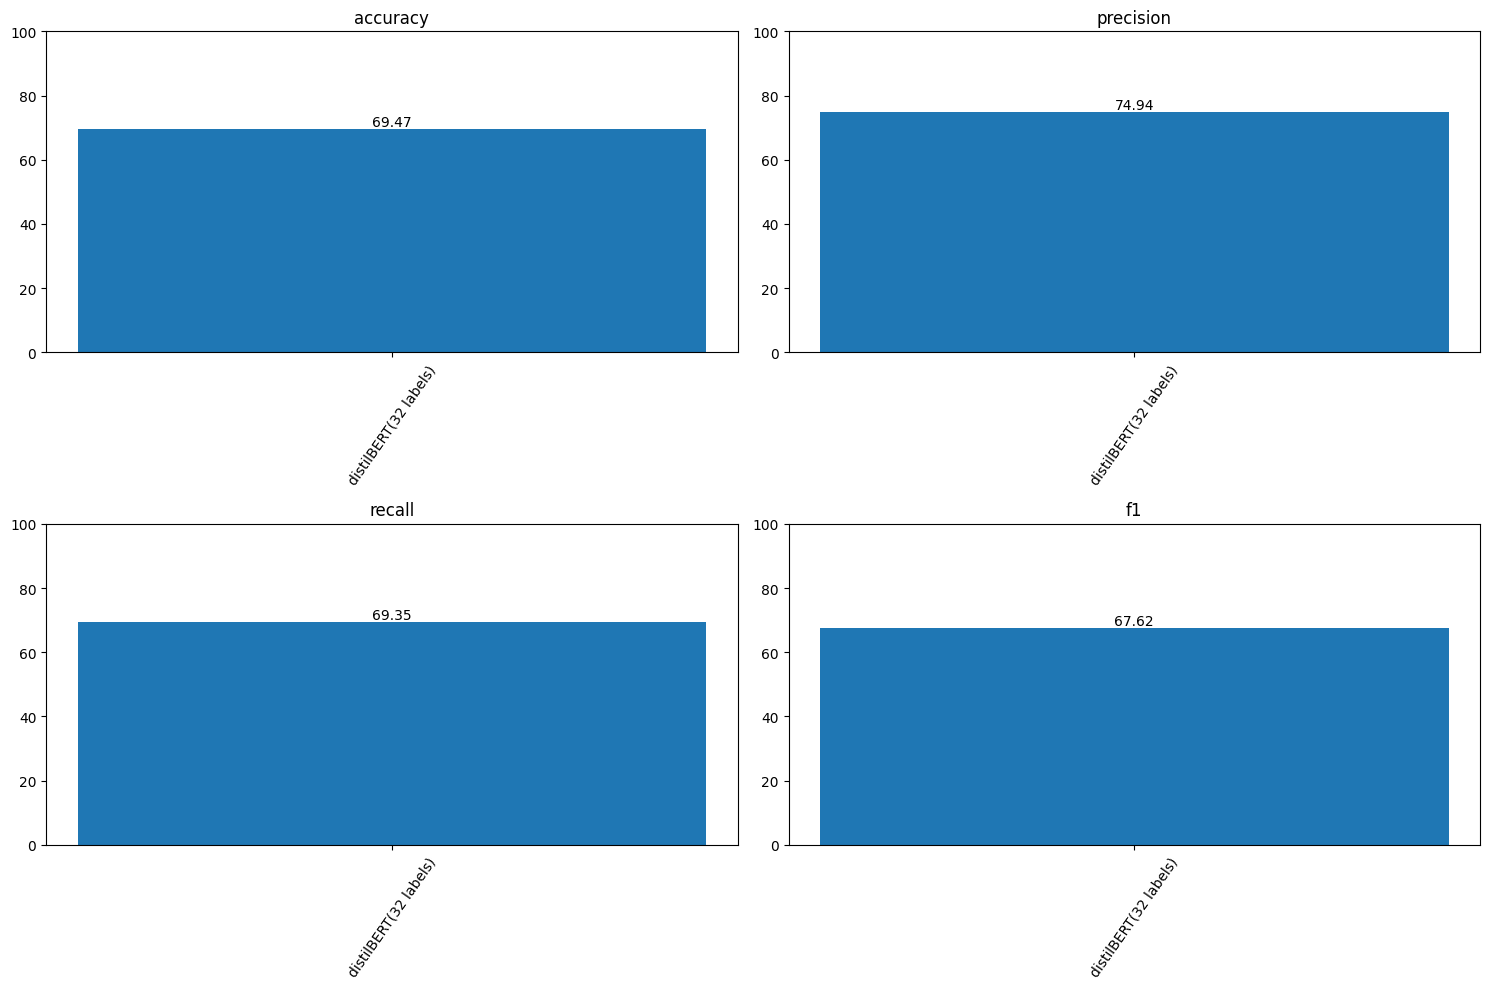

In [74]:
# get the final metrics
metrics_val= Metrics()
metrics_val.run(test_labels, valid_preds, "distilBERT(32 labels)")
metrics_val.plot()
tf.keras.backend.clear_session()

#### As we see, BERT trained on 32 labels performs slightly better than random. Note that metrics vary in the range [0.52, 0.62], depending on the run, as all batches are randomly assigned.

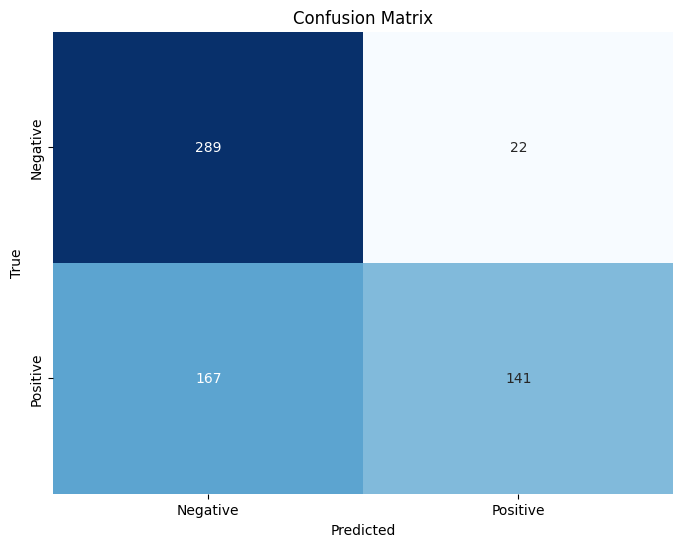

In [75]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, valid_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## b. Dataset Augmentation

#### Text data augmentation approaches include:

+ Synonym Replacement: Replace words with their synonyms.
+ Random Insertion: Insert random words into the text.
+ Random Deletion: Randomly delete words from the text.
+ Random Swap: Swap two words randomly in the text.
+ Text Masking: Replace words or phrases with a mask token.

As far as we have very small dataset (DTM is of shape 32:305) I chose not to work with deletion or masking, but rather with synonyms. I thought of two approaches to do so:

### Data Augmentation: Manually Gathered Synonyms

#### First approach was to analyse the most common words associated with positive and negative sentiments and manually create a dictionary with synonyms. Then, I augmented data with 50 (tried more, but performance was worse, probably bacause of the limited variety of the changes and the fact, that probably misclassified observations could be misclassified now twice) observations and trained the same BERT with augmented data.

In [76]:
# I had slightly different approach, but changed it to Mikel's so to have the same logic throughout the notebook. Will have to move this and next cell to the first exercise later on.
## Preprocessing texts
pipeline = Pipeline([
        ('prepro', TextPreprocessor()),
        ("vect", CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.97)),
        ("tfidf", TfidfTransformer(use_idf=True, norm='l1'))
    ]
)

# Fit the pipeline on the training data
pipeline.fit(df_train_32['clean_text'])

Pipeline(steps=[('prepro', TextPreprocessor()),
                ('vect',
                 CountVectorizer(max_df=0.97, min_df=0.005,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1'))])

384


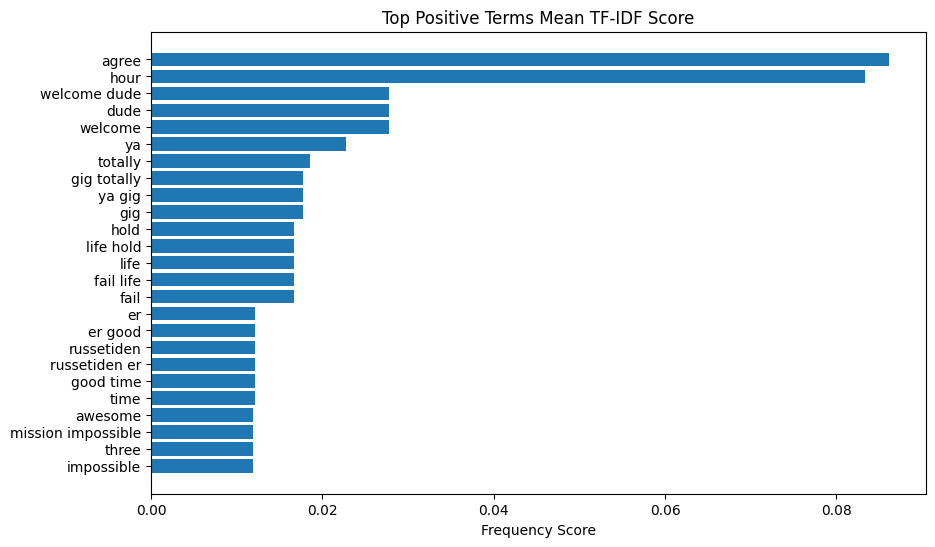

In [77]:
pos = f'Top Positive Terms Mean TF-IDF Score'
## Posive Terms
pos_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,1)
pos_tf_idf = transform_to_dataframe(pos_feature_names,term_tfidf)
plot_freq_top(pos_tf_idf,25,pos)

384


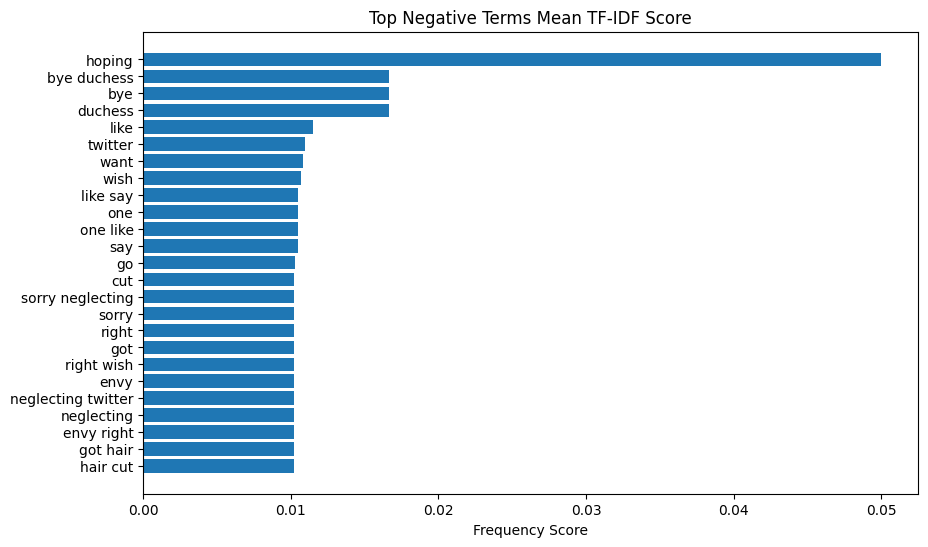

In [78]:
neg = f'Top Negative Terms Mean TF-IDF Score'
## Posive Terms
neg_feature_names, term_tfidf, tfidf_dict = tfidf_term(pipeline,df_train_32,0)
neg_tf_idf = transform_to_dataframe(neg_feature_names,term_tfidf)
plot_freq_top(neg_tf_idf,25,neg)

#### We got top 'most positive' and 'most negative' terms, manually chose some of them and assigned synonyms.

In [79]:
# Sort the dataframe by the 'score' column in decreasing order
neg_tf_idf_sorted = neg_tf_idf.sort_values(by='score', ascending=False)
pos_tf_idf_sorted = pos_tf_idf.sort_values(by='score', ascending=False)

# Extract the top 25 terms from the sorted dataframe
top_terms_neg = neg_tf_idf_sorted['terms'].head(25).tolist()
top_terms_pos = pos_tf_idf_sorted['terms'].head(25).tolist()

# Print the list of top 25 terms
print(top_terms_neg)
print(top_terms_pos)

['hoping', 'bye duchess', 'bye', 'duchess', 'like', 'twitter', 'want', 'wish', 'like say', 'one', 'one like', 'say', 'go', 'cut', 'sorry neglecting', 'sorry', 'right', 'got', 'right wish', 'envy', 'neglecting twitter', 'neglecting', 'envy right', 'got hair', 'hair cut']
['agree', 'hour', 'welcome dude', 'dude', 'welcome', 'ya', 'totally', 'gig totally', 'ya gig', 'gig', 'hold', 'life hold', 'life', 'fail life', 'fail', 'er', 'er good', 'russetiden', 'russetiden er', 'good time', 'time', 'awesome', 'mission impossible', 'three', 'impossible']


In [80]:
synonyms = {
    'go': ['move', 'travel', 'proceed', 'advance'],
    'envy': ['jealousy', 'resentment', 'desire'],
    'follower': ['adherent', 'disciple', 'supporter', 'devotee'],
    'want': ['desire', 'wish', 'crave', 'yearn'],
    'long': ['lengthy', 'extended', 'prolonged', 'distant'],
    'got': ['obtained', 'acquired', 'received', 'possessed'],
    'back': ['rear', 'behind', 'spine', 'reverse'],
    'hear': ['listen', 'perceive', 'catch', 'comprehend'],
    'woke': ['awake','conscious', 'comprehend'],
    'ago': ['in the past', 'back', 'before', 'previously'],
    'get back': ['retrieve', 'return', 'reclaim', 'regain'],
    'long ago': ['many years ago', 'ages ago', 'centuries ago'],
    'ghost image': ['phantom picture', 'spirit image'],
    'cry': ['weep', 'sob', 'shed tears'],
    'much': ['a lot', 'many', 'plenty', 'abundant'],
    'rock': ['stone', 'boulder', 'pebble', 'rocky'],
    'thank': ['express gratitude', 'show appreciation', 'give thanks', 'acknowledge'],
    'fair': ['just', 'acceptable', 'impartial', 'reasonable'],
    'enough': ['sufficient', 'adequate', 'plenty'],
    'like': ['enjoy', 'admire', 'favor', 'approve of'],
    'night': ['evening', 'darkness', 'nighttime', 'nocturnal'],
}

In [81]:
# Function to replace key word with a random synonym
def replace_with_synonym(text, synonyms_dict):
    words = text.split()
    for i, word in enumerate(words):
        if word in synonyms_dict:
            synonyms = synonyms_dict[word]
            # Randomly select a synonym
            new_word = random.choice(synonyms)
            # Replace the key word with the selected synonym
            words[i] = new_word
    return ' '.join(words)

# Initialize an empty DataFrame to store new observations
new_rows = pd.DataFrame(columns=df_train_32.columns)

# Generate additional 50 rows
while len(new_rows) < 50:
    # Identify rows with words from synonyms dictionary
    relevant_rows = df_train_32[df_train_32['clean_text'].apply(lambda x: any(word in synonyms for word in x.split()))]
    # Duplicate each relevant row and replace key word with synonym
    for idx, row in relevant_rows.iterrows():
        new_row = row.copy()
        new_row['clean_text'] = replace_with_synonym(row['clean_text'], synonyms)
        new_rows = new_rows.append(new_row, ignore_index=True)
        if len(new_rows) >= 50:
            break

# Display the new DataFrame with 50 new rows
new_rows.head(10)

<ipython-input-81-383be659130a>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion
0,"Well, this day... I would like to go out in th...",0,19,"well , this day . i would favor to move out in...",,,"well , this day . i would like to go out in th..."
1,I just want to get to Wednesday. I want to sk...,0,20,i just desire to get to wednesday . i wish to ...,,,i just want to get to wednesday . i want to sk...
2,"boredd, waiting to go to mass",0,6,"boredd , waiting to advance to mass",,,"boredd , waiting to go to mass"
3,@NicoleKleeberg - The ones I like? Say it ain'...,0,10,- the ones i enjoy ? say it ain ' t so !,,,- the ones i like ? say it ain ' t so !
4,Going to Denver today to see my sis. Running t...,0,29,going to denver today to see my sis . running ...,,,going to denver today to see my sis . running ...
5,@lollipop26 haha....yes that is very true. I t...,1,23,haha . yes that is very true . i turn up to wo...,,,haha . yes that is very true . i turn up to wo...
6,I really don't want to have to get a cone for ...,0,13,i really do not wish to have to get a cone for...,,,i really do not want to have to get a cone for...
7,just got my hair cut,0,5,just possessed my hair cut,,,just got my hair cut
8,I feel thoroughy unwell. Looks like it wasn't ...,0,27,i feel thoroughy unwell . looks enjoy it wasn ...,,,i feel thoroughy unwell . looks like it wasn '...
9,@jordanchang so envy you right now i wish i wa...,0,11,so resentment you right now i wish i was there,,,so envy you right now i wish i was there


In [82]:
# Add new_rows to df_train_32
augmented_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame shape
print(augmented_df.shape)

(82, 7)


In [83]:
# Define data and labels
augmented_df_data = augmented_df['clean_text']
augmented_df_label = augmented_df['label']

#### Note, that we will work with the same BERT model, so we will not change anything in the model architecture.

In [84]:
y_train = enc.fit_transform(np.array(augmented_df_label).reshape(-1, 1)).toarray()

X_train = np.array(augmented_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

from keras.callbacks import EarlyStopping
bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# # Now, pass the wrapped generator to fit
history = bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/2



Epoch:  10%|█         | 1/10 [00:30<04:36, 30.72s/it]

 1/10 [==>...........................] - ETA: 4:41 - loss: 0.1045 - recall: 1.0000 - precision: 1.0000


Epoch:  30%|███       | 3/10 [00:31<00:57,  8.25s/it]

 2/10 [=====>........................] - ETA: 6s - loss: 0.0560 - recall: 1.0000 - precision: 1.0000  


Epoch:  40%|████      | 4/10 [00:32<00:34,  5.67s/it]

 3/10 [========>.....................] - ETA: 5s - loss: 0.6590 - recall: 0.8333 - precision: 0.8333


Epoch:  50%|█████     | 5/10 [00:33<00:20,  4.05s/it]

 4/10 [===========>..................] - ETA: 4s - loss: 0.5375 - recall: 0.8438 - precision: 0.8438


Epoch:  60%|██████    | 6/10 [00:33<00:12,  3.01s/it]

 5/10 [==============>...............] - ETA: 4s - loss: 0.5243 - recall: 0.8500 - precision: 0.8500


Epoch:  70%|███████   | 7/10 [00:34<00:06,  2.33s/it]

 6/10 [=================>............] - ETA: 3s - loss: 0.4484 - recall: 0.8750 - precision: 0.8750


Epoch:  80%|████████  | 8/10 [00:35<00:03,  1.93s/it]

 7/10 [====================>.........] - ETA: 2s - loss: 0.3911 - recall: 0.8929 - precision: 0.8929


Epoch:  90%|█████████ | 9/10 [00:36<00:01,  1.61s/it]

 8/10 [=======================>......] - ETA: 1s - loss: 0.3481 - recall: 0.9062 - precision: 0.9062


Epoch: 100%|██████████| 10/10 [00:37<00:00,  1.39s/it]

 9/10 [==========================>...] - ETA: 0s - loss: 0.3389 - recall: 0.9028 - precision: 0.9028


Epoch: 11it [00:38,  1.22s/it]                        

10/10 [==============================] - 39s 856ms/step - loss: 0.3395 - recall: 0.9000 - precision: 0.9000
Epoch 2/2



Epoch: 12it [00:39,  1.11s/it]

 1/10 [==>...........................] - ETA: 5s - loss: 0.7620 - recall: 0.5000 - precision: 0.5000


Epoch: 13it [00:39,  1.03it/s]

 2/10 [=====>........................] - ETA: 6s - loss: 0.1774 - recall: 0.9000 - precision: 0.9000


Epoch: 14it [00:40,  1.08it/s]

 3/10 [========>.....................] - ETA: 6s - loss: 0.1185 - recall: 0.9444 - precision: 0.9444


Epoch: 15it [00:41,  1.09it/s]

 4/10 [===========>..................] - ETA: 5s - loss: 0.1158 - recall: 0.9615 - precision: 0.9615


Epoch: 16it [00:42,  1.10it/s]

 5/10 [==============>...............] - ETA: 4s - loss: 0.0981 - recall: 0.9706 - precision: 0.9706


Epoch: 17it [00:43,  1.14it/s]

 6/10 [=================>............] - ETA: 3s - loss: 0.1176 - recall: 0.9524 - precision: 0.9524


Epoch: 18it [00:43,  1.20it/s]

 7/10 [====================>.........] - ETA: 2s - loss: 0.1051 - recall: 0.9600 - precision: 0.9600


Epoch: 19it [00:44,  1.20it/s]

 8/10 [=======================>......] - ETA: 1s - loss: 0.0933 - recall: 0.9655 - precision: 0.9655


Epoch: 20it [00:45,  1.21it/s]

 9/10 [==========================>...] - ETA: 0s - loss: 0.0822 - recall: 0.9697 - precision: 0.9697


Epoch: 21it [00:46,  1.25it/s]

10/10 [==============================] - 8s 811ms/step - loss: 0.1620 - recall: 0.9595 - precision: 0.9595


In [86]:
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 11s 404ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


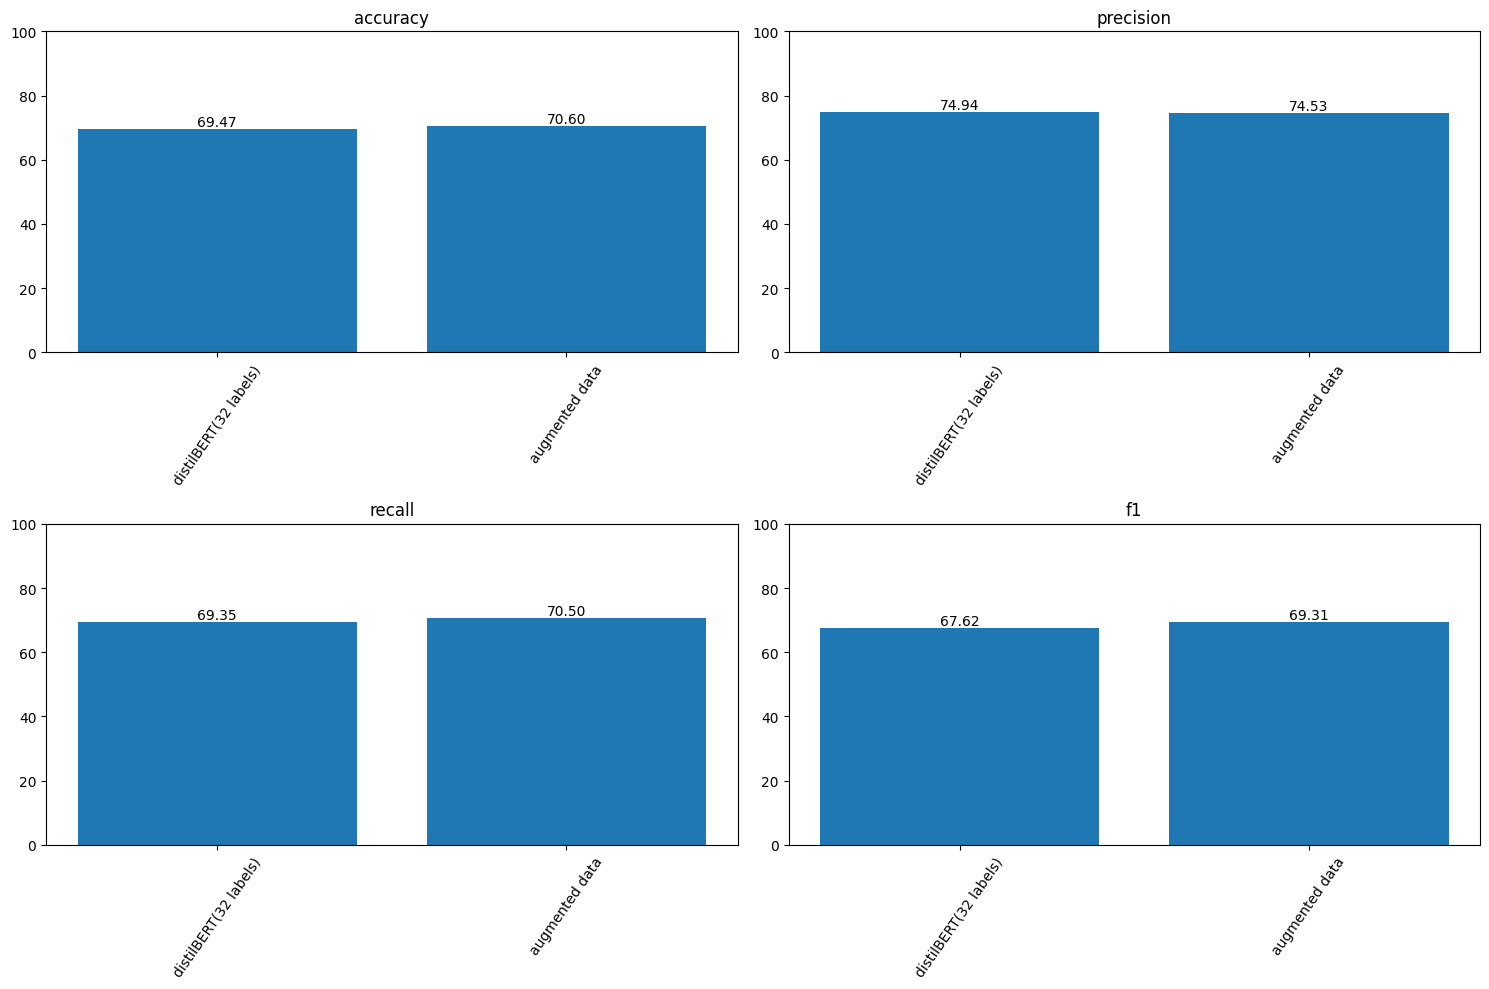

In [87]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data")
metrics_val.plot()
tf.keras.backend.clear_session()

### Data Augmentation: Synonyms from WordNet

#### We didn't choose to work with WordNet packages in the beginning, as far as synonyms look kind of random and don't usually properly reflect the meaning of the word (probably because of multiple meanings) and don't consider the context. But as far as we couldn't manually assign synonyms to all (or at least many) tokens, we decided to try WordNet as well.

#### So the second approach is to rendomly change 30% of the tokens in the comments (We tried different shares, 30% performed better) and add 32*20 (tried different numbers as well) new rows.

In [88]:
# Function to get synonyms from WordNet
def get_wordnet_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

# Function to replace random words with WordNet synonyms
def replace_with_synonym_wordnet(text):
    words = text.split()
    for i, word in enumerate(words):
        # Randomly decide whether to replace the word with a synonym
        if random.random() < 0.3:  # Adjust the probability as needed
            # Get WordNet synonyms for the word
            synonyms = get_wordnet_synonyms(word)
            if synonyms:
                # Randomly select a synonym
                new_word = random.choice(synonyms)
                # Replace the word with the selected synonym
                words[i] = new_word
    return ' '.join(words)

# Duplicate each row and replace random words with WordNet synonyms
new_rows = pd.DataFrame(columns=df_train_32.columns)
for idx, row in df_train_32.iterrows():
    for _ in range(20):  # Duplicate 20 times - can be adjusted as needed
        # Duplicate the row
        new_row = row.copy()
        # Replace random words in the 'clean_text' column with WordNet synonyms
        new_row['clean_text'] = replace_with_synonym_wordnet(row['clean_text'])
        # Append the new row to the DataFrame
        new_rows = new_rows.append(new_row, ignore_index=True)

# Display the new DataFrame with duplicated rows and random word replacements
new_rows.head(10)

<ipython-input-88-5f1b6b51e9c4>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_rows = new_rows.append(new_row, ignore_index=True)


,text,label,text_length,clean_text,clean_emotions,hashtag,text_emotion
0,"Well, this day... I would like to go out in th...",0,19,"well , this day . i would the_like to go out i...",,,"well , this day . i would like to go out in th..."
1,"Well, this day... I would like to go out in th...",0,19,"well , this day . I would like to run out in t...",,,"well , this day . i would like to go out in th..."
2,"Well, this day... I would like to go out in th...",0,19,"well , this Clarence_Day . ace would like to g...",,,"well , this day . i would like to go out in th..."
3,"Well, this day... I would like to go out in th...",0,19,"well , this day . i would wish to go tabu in t...",,,"well , this day . i would like to go out in th..."
4,"Well, this day... I would like to go out in th...",0,19,"well , this daytime . i would like to fling pr...",,,"well , this day . i would like to go out in th..."
5,"Well, this day... I would like to go out in th...",0,19,"well , this day . I would like to go out in th...",,,"well , this day . i would like to go out in th..."
6,"Well, this day... I would like to go out in th...",0,19,"well , this day . i would ilk to go out in the...",,,"well , this day . i would like to go out in th..."
7,"Well, this day... I would like to go out in th...",0,19,"well , this day . iodine would like to go out ...",,,"well , this day . i would like to go out in th..."
8,"Well, this day... I would like to go out in th...",0,19,"well , this twenty-four_hour_period . i would ...",,,"well , this day . i would like to go out in th..."
9,"Well, this day... I would like to go out in th...",0,19,"well , this day . 1 would like to go out in th...",,,"well , this day . i would like to go out in th..."


#### From the printed first rows you actually may see (comparing text and clean text, which was duplicated), that synonyms are kind of weird.

In [129]:
# Add new_rows to df_train_32
augmented_w_df = pd.concat([df_train_32, new_rows], ignore_index=True)

# Display the augmented DataFrame
print(augmented_w_df.shape)

(672, 7)


In [130]:
augmented_w_df_data = augmented_w_df['clean_text']
augmented_w_df_label = augmented_w_df['label']

In [131]:
y_train = enc.fit_transform(np.array(augmented_w_df_label).reshape(-1, 1)).toarray()

X_train = np.array(augmented_w_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
history = bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)






Epoch:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/2







Epoch:   1%|          | 1/84 [00:29<40:11, 29.05s/it]

 1/84 [..............................] - ETA: 40:55 - loss: 0.0152 - recall: 1.0000 - precision: 1.0000






Epoch:   4%|▎         | 3/84 [00:29<10:30,  7.78s/it]

 2/84 [..............................] - ETA: 58s - loss: 0.0160 - recall: 1.0000 - precision: 1.0000  






Epoch:   5%|▍         | 4/84 [00:30<07:07,  5.34s/it]

 3/84 [>.............................] - ETA: 56s - loss: 0.0284 - recall: 1.0000 - precision: 1.0000






Epoch:   6%|▌         | 5/84 [00:31<05:00,  3.80s/it]

 4/84 [>.............................] - ETA: 56s - loss: 0.0213 - recall: 1.0000 - precision: 1.0000






Epoch:   7%|▋         | 6/84 [00:31<03:39,  2.81s/it]

 5/84 [>.............................] - ETA: 55s - loss: 0.0173 - recall: 1.0000 - precision: 1.0000






Epoch:   8%|▊         | 7/84 [00:32<02:44,  2.14s/it]

 6/84 [=>............................] - ETA: 54s - loss: 0.0146 - recall: 1.0000 - precision: 1.0000






Epoch:  10%|▉         | 8/84 [00:33<02:08,  1.69s/it]

 7/84 [=>............................] - ETA: 53s - loss: 0.0126 - recall: 1.0000 - precision: 1.0000






Epoch:  11%|█         | 9/84 [00:33<01:44,  1.39s/it]

 8/84 [=>............................] - ETA: 53s - loss: 0.0422 - recall: 0.9844 - precision: 0.9844






Epoch:  12%|█▏        | 10/84 [00:34<01:27,  1.18s/it]

 9/84 [==>...........................] - ETA: 53s - loss: 0.2318 - recall: 0.9583 - precision: 0.9583






Epoch:  13%|█▎        | 11/84 [00:35<01:18,  1.07s/it]

10/84 [==>...........................] - ETA: 53s - loss: 0.2086 - recall: 0.9625 - precision: 0.9625






Epoch:  14%|█▍        | 12/84 [00:36<01:10,  1.03it/s]

11/84 [==>...........................] - ETA: 52s - loss: 0.1897 - recall: 0.9659 - precision: 0.9659






Epoch:  15%|█▌        | 13/84 [00:36<01:03,  1.11it/s]

12/84 [===>..........................] - ETA: 51s - loss: 0.1739 - recall: 0.9688 - precision: 0.9688






Epoch:  17%|█▋        | 14/84 [00:37<00:58,  1.20it/s]

13/84 [===>..........................] - ETA: 50s - loss: 0.1605 - recall: 0.9712 - precision: 0.9712






Epoch:  18%|█▊        | 15/84 [00:38<00:54,  1.27it/s]

14/84 [====>.........................] - ETA: 49s - loss: 0.1491 - recall: 0.9732 - precision: 0.9732






Epoch:  19%|█▉        | 16/84 [00:39<00:52,  1.30it/s]

15/84 [====>.........................] - ETA: 49s - loss: 0.1391 - recall: 0.9750 - precision: 0.9750






Epoch:  20%|██        | 17/84 [00:39<00:49,  1.35it/s]

16/84 [====>.........................] - ETA: 48s - loss: 0.1304 - recall: 0.9766 - precision: 0.9766






Epoch:  21%|██▏       | 18/84 [00:40<00:48,  1.37it/s]

17/84 [=====>........................] - ETA: 47s - loss: 0.1228 - recall: 0.9779 - precision: 0.9779






Epoch:  23%|██▎       | 19/84 [00:41<00:46,  1.41it/s]

18/84 [=====>........................] - ETA: 46s - loss: 0.1160 - recall: 0.9792 - precision: 0.9792






Epoch:  24%|██▍       | 20/84 [00:41<00:44,  1.43it/s]

19/84 [=====>........................] - ETA: 45s - loss: 0.1099 - recall: 0.9803 - precision: 0.9803






Epoch:  25%|██▌       | 21/84 [00:42<00:43,  1.45it/s]

20/84 [======>.......................] - ETA: 45s - loss: 0.1192 - recall: 0.9750 - precision: 0.9750






Epoch:  26%|██▌       | 22/84 [00:43<00:44,  1.39it/s]

21/84 [======>.......................] - ETA: 44s - loss: 0.1137 - recall: 0.9762 - precision: 0.9762






Epoch:  27%|██▋       | 23/84 [00:43<00:43,  1.40it/s]

22/84 [======>.......................] - ETA: 44s - loss: 0.1088 - recall: 0.9773 - precision: 0.9773






Epoch:  29%|██▊       | 24/84 [00:44<00:43,  1.37it/s]

23/84 [=======>......................] - ETA: 43s - loss: 0.1041 - recall: 0.9783 - precision: 0.9783






Epoch:  30%|██▉       | 25/84 [00:45<00:41,  1.41it/s]

24/84 [=======>......................] - ETA: 42s - loss: 0.0998 - recall: 0.9792 - precision: 0.9792






Epoch:  31%|███       | 26/84 [00:46<00:40,  1.43it/s]

25/84 [=======>......................] - ETA: 41s - loss: 0.1109 - recall: 0.9750 - precision: 0.9750






Epoch:  32%|███▏      | 27/84 [00:46<00:39,  1.44it/s]

26/84 [========>.....................] - ETA: 40s - loss: 0.1066 - recall: 0.9760 - precision: 0.9760






Epoch:  33%|███▎      | 28/84 [00:47<00:38,  1.44it/s]

27/84 [========>.....................] - ETA: 40s - loss: 0.1030 - recall: 0.9769 - precision: 0.9769






Epoch:  35%|███▍      | 29/84 [00:48<00:37,  1.46it/s]

28/84 [=========>....................] - ETA: 39s - loss: 0.0994 - recall: 0.9777 - precision: 0.9777






Epoch:  36%|███▌      | 30/84 [00:48<00:37,  1.45it/s]

29/84 [=========>....................] - ETA: 38s - loss: 0.0959 - recall: 0.9784 - precision: 0.9784






Epoch:  37%|███▋      | 31/84 [00:49<00:36,  1.47it/s]

30/84 [=========>....................] - ETA: 37s - loss: 0.0928 - recall: 0.9792 - precision: 0.9792






Epoch:  38%|███▊      | 32/84 [00:50<00:35,  1.48it/s]

31/84 [==========>...................] - ETA: 37s - loss: 0.0898 - recall: 0.9798 - precision: 0.9798






Epoch:  39%|███▉      | 33/84 [00:50<00:34,  1.48it/s]

32/84 [==========>...................] - ETA: 36s - loss: 0.0871 - recall: 0.9805 - precision: 0.9805






Epoch:  40%|████      | 34/84 [00:51<00:33,  1.48it/s]

33/84 [==========>...................] - ETA: 35s - loss: 0.0846 - recall: 0.9811 - precision: 0.9811






Epoch:  42%|████▏     | 35/84 [00:52<00:33,  1.48it/s]

34/84 [===========>..................] - ETA: 34s - loss: 0.0822 - recall: 0.9816 - precision: 0.9816






Epoch:  43%|████▎     | 36/84 [00:52<00:32,  1.46it/s]

35/84 [===========>..................] - ETA: 34s - loss: 0.0799 - recall: 0.9821 - precision: 0.9821






Epoch:  44%|████▍     | 37/84 [00:53<00:32,  1.45it/s]

36/84 [===========>..................] - ETA: 33s - loss: 0.0777 - recall: 0.9826 - precision: 0.9826






Epoch:  45%|████▌     | 38/84 [00:54<00:31,  1.45it/s]

37/84 [============>.................] - ETA: 32s - loss: 0.0756 - recall: 0.9831 - precision: 0.9831






Epoch:  46%|████▋     | 39/84 [00:54<00:31,  1.41it/s]

38/84 [============>.................] - ETA: 32s - loss: 0.0737 - recall: 0.9836 - precision: 0.9836






Epoch:  48%|████▊     | 40/84 [00:55<00:31,  1.41it/s]

39/84 [============>.................] - ETA: 31s - loss: 0.0718 - recall: 0.9840 - precision: 0.9840






Epoch:  49%|████▉     | 41/84 [00:56<00:31,  1.36it/s]

40/84 [=============>................] - ETA: 30s - loss: 0.0702 - recall: 0.9844 - precision: 0.9844






Epoch:  50%|█████     | 42/84 [00:57<00:30,  1.36it/s]

41/84 [=============>................] - ETA: 30s - loss: 0.0685 - recall: 0.9848 - precision: 0.9848






Epoch:  51%|█████     | 43/84 [00:57<00:30,  1.36it/s]

42/84 [==============>...............] - ETA: 29s - loss: 0.0669 - recall: 0.9851 - precision: 0.9851






Epoch:  52%|█████▏    | 44/84 [00:58<00:29,  1.34it/s]

43/84 [==============>...............] - ETA: 29s - loss: 0.0654 - recall: 0.9855 - precision: 0.9855






Epoch:  54%|█████▎    | 45/84 [00:59<00:29,  1.33it/s]

44/84 [==============>...............] - ETA: 28s - loss: 0.0639 - recall: 0.9858 - precision: 0.9858






Epoch:  55%|█████▍    | 46/84 [01:00<00:28,  1.33it/s]

45/84 [===============>..............] - ETA: 27s - loss: 0.0626 - recall: 0.9861 - precision: 0.9861






Epoch:  56%|█████▌    | 47/84 [01:00<00:27,  1.33it/s]

46/84 [===============>..............] - ETA: 26s - loss: 0.0613 - recall: 0.9864 - precision: 0.9864






Epoch:  57%|█████▋    | 48/84 [01:01<00:26,  1.35it/s]

47/84 [===============>..............] - ETA: 26s - loss: 0.0600 - recall: 0.9867 - precision: 0.9867






Epoch:  58%|█████▊    | 49/84 [01:02<00:25,  1.37it/s]

48/84 [================>.............] - ETA: 25s - loss: 0.0598 - recall: 0.9870 - precision: 0.9870






Epoch:  60%|█████▉    | 50/84 [01:03<00:25,  1.33it/s]

49/84 [================>.............] - ETA: 25s - loss: 0.0586 - recall: 0.9872 - precision: 0.9872






Epoch:  61%|██████    | 51/84 [01:04<00:26,  1.25it/s]

50/84 [================>.............] - ETA: 24s - loss: 0.0575 - recall: 0.9875 - precision: 0.9875






Epoch:  62%|██████▏   | 52/84 [01:04<00:25,  1.26it/s]

51/84 [=================>............] - ETA: 23s - loss: 0.0646 - recall: 0.9853 - precision: 0.9853






Epoch:  63%|██████▎   | 53/84 [01:05<00:23,  1.32it/s]

52/84 [=================>............] - ETA: 22s - loss: 0.0634 - recall: 0.9856 - precision: 0.9856






Epoch:  64%|██████▍   | 54/84 [01:06<00:22,  1.35it/s]

53/84 [=================>............] - ETA: 22s - loss: 0.0622 - recall: 0.9858 - precision: 0.9858






Epoch:  65%|██████▌   | 55/84 [01:06<00:21,  1.37it/s]

54/84 [==================>...........] - ETA: 21s - loss: 0.0611 - recall: 0.9861 - precision: 0.9861






Epoch:  67%|██████▋   | 56/84 [01:07<00:20,  1.38it/s]

55/84 [==================>...........] - ETA: 20s - loss: 0.0603 - recall: 0.9864 - precision: 0.9864






Epoch:  68%|██████▊   | 57/84 [01:08<00:20,  1.32it/s]

56/84 [===================>..........] - ETA: 20s - loss: 0.0592 - recall: 0.9866 - precision: 0.9866






Epoch:  69%|██████▉   | 58/84 [01:09<00:20,  1.27it/s]

57/84 [===================>..........] - ETA: 19s - loss: 0.0582 - recall: 0.9868 - precision: 0.9868






Epoch:  70%|███████   | 59/84 [01:10<00:19,  1.29it/s]

58/84 [===================>..........] - ETA: 18s - loss: 0.0573 - recall: 0.9871 - precision: 0.9871






Epoch:  71%|███████▏  | 60/84 [01:10<00:18,  1.29it/s]

59/84 [====================>.........] - ETA: 18s - loss: 0.0563 - recall: 0.9873 - precision: 0.9873






Epoch:  73%|███████▎  | 61/84 [01:11<00:17,  1.30it/s]

60/84 [====================>.........] - ETA: 17s - loss: 0.0554 - recall: 0.9875 - precision: 0.9875






Epoch:  74%|███████▍  | 62/84 [01:12<00:16,  1.30it/s]

61/84 [====================>.........] - ETA: 16s - loss: 0.0546 - recall: 0.9877 - precision: 0.9877






Epoch:  75%|███████▌  | 63/84 [01:13<00:15,  1.32it/s]

62/84 [=====================>........] - ETA: 15s - loss: 0.0537 - recall: 0.9879 - precision: 0.9879






Epoch:  76%|███████▌  | 64/84 [01:13<00:15,  1.31it/s]

63/84 [=====================>........] - ETA: 15s - loss: 0.0529 - recall: 0.9881 - precision: 0.9881






Epoch:  77%|███████▋  | 65/84 [01:14<00:14,  1.31it/s]

64/84 [=====================>........] - ETA: 14s - loss: 0.0521 - recall: 0.9883 - precision: 0.9883






Epoch:  79%|███████▊  | 66/84 [01:15<00:13,  1.32it/s]

65/84 [======================>.......] - ETA: 13s - loss: 0.0514 - recall: 0.9885 - precision: 0.9885






Epoch:  80%|███████▉  | 67/84 [01:16<00:12,  1.31it/s]

66/84 [======================>.......] - ETA: 13s - loss: 0.0515 - recall: 0.9886 - precision: 0.9886






Epoch:  81%|████████  | 68/84 [01:16<00:12,  1.32it/s]

67/84 [======================>.......] - ETA: 12s - loss: 0.0508 - recall: 0.9888 - precision: 0.9888






Epoch:  82%|████████▏ | 69/84 [01:17<00:11,  1.33it/s]

68/84 [=======================>......] - ETA: 11s - loss: 0.0501 - recall: 0.9890 - precision: 0.9890






Epoch:  83%|████████▎ | 70/84 [01:18<00:10,  1.35it/s]

69/84 [=======================>......] - ETA: 10s - loss: 0.0495 - recall: 0.9891 - precision: 0.9891






Epoch:  85%|████████▍ | 71/84 [01:19<00:09,  1.36it/s]

70/84 [========================>.....] - ETA: 10s - loss: 0.0488 - recall: 0.9893 - precision: 0.9893






Epoch:  86%|████████▌ | 72/84 [01:19<00:08,  1.35it/s]

71/84 [========================>.....] - ETA: 9s - loss: 0.0482 - recall: 0.9894 - precision: 0.9894 






Epoch:  87%|████████▋ | 73/84 [01:20<00:08,  1.36it/s]

72/84 [========================>.....] - ETA: 8s - loss: 0.0475 - recall: 0.9896 - precision: 0.9896






Epoch:  88%|████████▊ | 74/84 [01:21<00:07,  1.35it/s]

73/84 [=========================>....] - ETA: 7s - loss: 0.0469 - recall: 0.9897 - precision: 0.9897






Epoch:  89%|████████▉ | 75/84 [01:22<00:06,  1.35it/s]

74/84 [=========================>....] - ETA: 7s - loss: 0.0468 - recall: 0.9899 - precision: 0.9899






Epoch:  90%|█████████ | 76/84 [01:22<00:05,  1.34it/s]

75/84 [=========================>....] - ETA: 6s - loss: 0.0462 - recall: 0.9900 - precision: 0.9900






Epoch:  92%|█████████▏| 77/84 [01:23<00:05,  1.34it/s]

76/84 [==========================>...] - ETA: 5s - loss: 0.0456 - recall: 0.9901 - precision: 0.9901






Epoch:  93%|█████████▎| 78/84 [01:24<00:04,  1.35it/s]

77/84 [==========================>...] - ETA: 5s - loss: 0.0451 - recall: 0.9903 - precision: 0.9903






Epoch:  94%|█████████▍| 79/84 [01:25<00:03,  1.30it/s]

78/84 [==========================>...] - ETA: 4s - loss: 0.0445 - recall: 0.9904 - precision: 0.9904






Epoch:  95%|█████████▌| 80/84 [01:25<00:03,  1.28it/s]

79/84 [===========================>..] - ETA: 3s - loss: 0.0440 - recall: 0.9905 - precision: 0.9905






Epoch:  96%|█████████▋| 81/84 [01:26<00:02,  1.25it/s]

80/84 [===========================>..] - ETA: 2s - loss: 0.0434 - recall: 0.9906 - precision: 0.9906






Epoch:  98%|█████████▊| 82/84 [01:27<00:01,  1.30it/s]

81/84 [===========================>..] - ETA: 2s - loss: 0.0429 - recall: 0.9907 - precision: 0.9907






Epoch:  99%|█████████▉| 83/84 [01:28<00:00,  1.34it/s]

82/84 [============================>.] - ETA: 1s - loss: 0.0424 - recall: 0.9909 - precision: 0.9909






Epoch: 100%|██████████| 84/84 [01:28<00:00,  1.36it/s]

83/84 [============================>.] - ETA: 0s - loss: 0.0419 - recall: 0.9910 - precision: 0.9910






Epoch: 85it [01:29,  1.36it/s]                        

84/84 [==============================] - 90s 731ms/step - loss: 0.0415 - recall: 0.9911 - precision: 0.9911
Epoch 2/2







Epoch: 86it [01:30,  1.34it/s]

 1/84 [..............................] - ETA: 1:02 - loss: 0.0016 - recall: 1.0000 - precision: 1.0000






Epoch: 87it [01:31,  1.33it/s]

 2/84 [..............................] - ETA: 57s - loss: 8.6413e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 88it [01:31,  1.36it/s]

 3/84 [>.............................] - ETA: 55s - loss: 7.2058e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 89it [01:32,  1.40it/s]

 4/84 [>.............................] - ETA: 55s - loss: 7.1563e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 90it [01:33,  1.41it/s]

 5/84 [>.............................] - ETA: 54s - loss: 6.2643e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 91it [01:33,  1.42it/s]

 6/84 [=>............................] - ETA: 54s - loss: 5.7652e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 92it [01:34,  1.41it/s]

 7/84 [=>............................] - ETA: 53s - loss: 5.1614e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 93it [01:35,  1.42it/s]

 8/84 [=>............................] - ETA: 52s - loss: 5.2752e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 94it [01:36,  1.44it/s]

 9/84 [==>...........................] - ETA: 52s - loss: 4.9561e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 95it [01:36,  1.43it/s]

10/84 [==>...........................] - ETA: 51s - loss: 5.9490e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 96it [01:37,  1.43it/s]

11/84 [==>...........................] - ETA: 50s - loss: 6.6738e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 97it [01:38,  1.43it/s]

12/84 [===>..........................] - ETA: 49s - loss: 7.5271e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 98it [01:38,  1.44it/s]

13/84 [===>..........................] - ETA: 49s - loss: 7.3504e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 99it [01:39,  1.46it/s]

14/84 [====>.........................] - ETA: 48s - loss: 7.2814e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 100it [01:40,  1.43it/s]

15/84 [====>.........................] - ETA: 47s - loss: 7.0008e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 101it [01:40,  1.46it/s]

16/84 [====>.........................] - ETA: 47s - loss: 6.6272e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 102it [01:41,  1.46it/s]

17/84 [=====>........................] - ETA: 46s - loss: 6.5348e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 103it [01:42,  1.44it/s]

18/84 [=====>........................] - ETA: 45s - loss: 6.2538e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 104it [01:42,  1.43it/s]

19/84 [=====>........................] - ETA: 45s - loss: 6.1473e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 105it [01:43,  1.45it/s]

20/84 [======>.......................] - ETA: 44s - loss: 6.0338e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 106it [01:44,  1.44it/s]

21/84 [======>.......................] - ETA: 43s - loss: 6.0240e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 107it [01:45,  1.42it/s]

22/84 [======>.......................] - ETA: 43s - loss: 6.1865e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 108it [01:45,  1.41it/s]

23/84 [=======>......................] - ETA: 42s - loss: 5.9833e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 109it [01:46,  1.44it/s]

24/84 [=======>......................] - ETA: 41s - loss: 6.5511e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 110it [01:47,  1.42it/s]

25/84 [=======>......................] - ETA: 40s - loss: 6.4598e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 111it [01:47,  1.45it/s]

26/84 [========>.....................] - ETA: 40s - loss: 6.3564e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 112it [01:48,  1.44it/s]

27/84 [========>.....................] - ETA: 39s - loss: 6.1626e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 113it [01:49,  1.46it/s]

28/84 [=========>....................] - ETA: 38s - loss: 7.0436e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 114it [01:49,  1.48it/s]

29/84 [=========>....................] - ETA: 38s - loss: 6.8335e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 115it [01:50,  1.49it/s]

30/84 [=========>....................] - ETA: 37s - loss: 6.6306e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 116it [01:51,  1.46it/s]

31/84 [==========>...................] - ETA: 36s - loss: 6.7094e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 117it [01:51,  1.44it/s]

32/84 [==========>...................] - ETA: 35s - loss: 6.5613e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 118it [01:52,  1.46it/s]

33/84 [==========>...................] - ETA: 35s - loss: 6.7767e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 119it [01:53,  1.46it/s]

34/84 [===========>..................] - ETA: 34s - loss: 6.9913e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 120it [01:53,  1.46it/s]

35/84 [===========>..................] - ETA: 33s - loss: 6.8228e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 121it [01:54,  1.44it/s]

36/84 [===========>..................] - ETA: 33s - loss: 6.7061e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 122it [01:55,  1.43it/s]

37/84 [============>.................] - ETA: 32s - loss: 6.6021e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 123it [01:56,  1.43it/s]

38/84 [============>.................] - ETA: 31s - loss: 6.4517e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 124it [01:56,  1.44it/s]

39/84 [============>.................] - ETA: 31s - loss: 6.3513e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 125it [01:57,  1.43it/s]

40/84 [=============>................] - ETA: 30s - loss: 6.2617e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 126it [01:58,  1.43it/s]

41/84 [=============>................] - ETA: 29s - loss: 6.1236e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 127it [01:58,  1.45it/s]

42/84 [==============>...............] - ETA: 29s - loss: 6.0011e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 128it [01:59,  1.45it/s]

43/84 [==============>...............] - ETA: 28s - loss: 5.8781e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 129it [02:00,  1.45it/s]

44/84 [==============>...............] - ETA: 27s - loss: 5.7512e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 130it [02:00,  1.44it/s]

45/84 [===============>..............] - ETA: 27s - loss: 5.7153e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 131it [02:01,  1.43it/s]

46/84 [===============>..............] - ETA: 26s - loss: 5.6021e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 132it [02:02,  1.40it/s]

47/84 [===============>..............] - ETA: 25s - loss: 5.5390e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 133it [02:03,  1.40it/s]

48/84 [================>.............] - ETA: 25s - loss: 5.4340e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 134it [02:03,  1.34it/s]

49/84 [================>.............] - ETA: 24s - loss: 5.3870e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 135it [02:04,  1.32it/s]

50/84 [================>.............] - ETA: 23s - loss: 5.2891e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 136it [02:05,  1.33it/s]

51/84 [=================>............] - ETA: 23s - loss: 5.2255e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 137it [02:06,  1.35it/s]

52/84 [=================>............] - ETA: 22s - loss: 5.2130e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 138it [02:06,  1.38it/s]

53/84 [=================>............] - ETA: 21s - loss: 5.2302e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 139it [02:07,  1.37it/s]

54/84 [==================>...........] - ETA: 21s - loss: 5.1373e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 140it [02:08,  1.35it/s]

55/84 [==================>...........] - ETA: 20s - loss: 5.0627e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 141it [02:09,  1.38it/s]

56/84 [===================>..........] - ETA: 19s - loss: 4.9825e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 142it [02:09,  1.41it/s]

57/84 [===================>..........] - ETA: 18s - loss: 4.9010e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 143it [02:10,  1.43it/s]

58/84 [===================>..........] - ETA: 18s - loss: 5.6439e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 144it [02:11,  1.42it/s]

59/84 [====================>.........] - ETA: 17s - loss: 5.6911e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 145it [02:11,  1.43it/s]

60/84 [====================>.........] - ETA: 16s - loss: 5.6044e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 146it [02:12,  1.46it/s]

61/84 [====================>.........] - ETA: 16s - loss: 5.5216e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 147it [02:13,  1.45it/s]

62/84 [=====================>........] - ETA: 15s - loss: 5.4528e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 148it [02:13,  1.45it/s]

63/84 [=====================>........] - ETA: 14s - loss: 5.3730e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 149it [02:14,  1.45it/s]

64/84 [=====================>........] - ETA: 13s - loss: 5.3859e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 150it [02:15,  1.45it/s]

65/84 [======================>.......] - ETA: 13s - loss: 5.3257e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 151it [02:15,  1.43it/s]

66/84 [======================>.......] - ETA: 12s - loss: 5.2876e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 152it [02:16,  1.42it/s]

67/84 [======================>.......] - ETA: 11s - loss: 5.2296e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 153it [02:17,  1.41it/s]

68/84 [=======================>......] - ETA: 11s - loss: 5.4822e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 154it [02:18,  1.38it/s]

69/84 [=======================>......] - ETA: 10s - loss: 5.4052e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 155it [02:18,  1.38it/s]

70/84 [========================>.....] - ETA: 9s - loss: 5.3855e-04 - recall: 1.0000 - precision: 1.0000 






Epoch: 156it [02:19,  1.38it/s]

71/84 [========================>.....] - ETA: 9s - loss: 5.4189e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 157it [02:20,  1.40it/s]

72/84 [========================>.....] - ETA: 8s - loss: 5.3543e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 158it [02:21,  1.39it/s]

73/84 [=========================>....] - ETA: 7s - loss: 5.2882e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 159it [02:21,  1.39it/s]

74/84 [=========================>....] - ETA: 7s - loss: 5.2288e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 160it [02:22,  1.39it/s]

75/84 [=========================>....] - ETA: 6s - loss: 5.1677e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 161it [02:23,  1.35it/s]

76/84 [==========================>...] - ETA: 5s - loss: 5.1127e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 162it [02:23,  1.38it/s]

77/84 [==========================>...] - ETA: 4s - loss: 5.2494e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 163it [02:24,  1.39it/s]

78/84 [==========================>...] - ETA: 4s - loss: 5.2098e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 164it [02:25,  1.41it/s]

79/84 [===========================>..] - ETA: 3s - loss: 5.1459e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 165it [02:26,  1.44it/s]

80/84 [===========================>..] - ETA: 2s - loss: 5.0832e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 166it [02:26,  1.47it/s]

81/84 [===========================>..] - ETA: 2s - loss: 5.0253e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 167it [02:27,  1.46it/s]

82/84 [============================>.] - ETA: 1s - loss: 5.2366e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 168it [02:28,  1.47it/s]

83/84 [============================>.] - ETA: 0s - loss: 5.1888e-04 - recall: 1.0000 - precision: 1.0000






Epoch: 169it [02:28,  1.45it/s]

84/84 [==============================] - 59s 702ms/step - loss: 5.1315e-04 - recall: 1.0000 - precision: 1.0000


In [132]:
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 10s 352ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


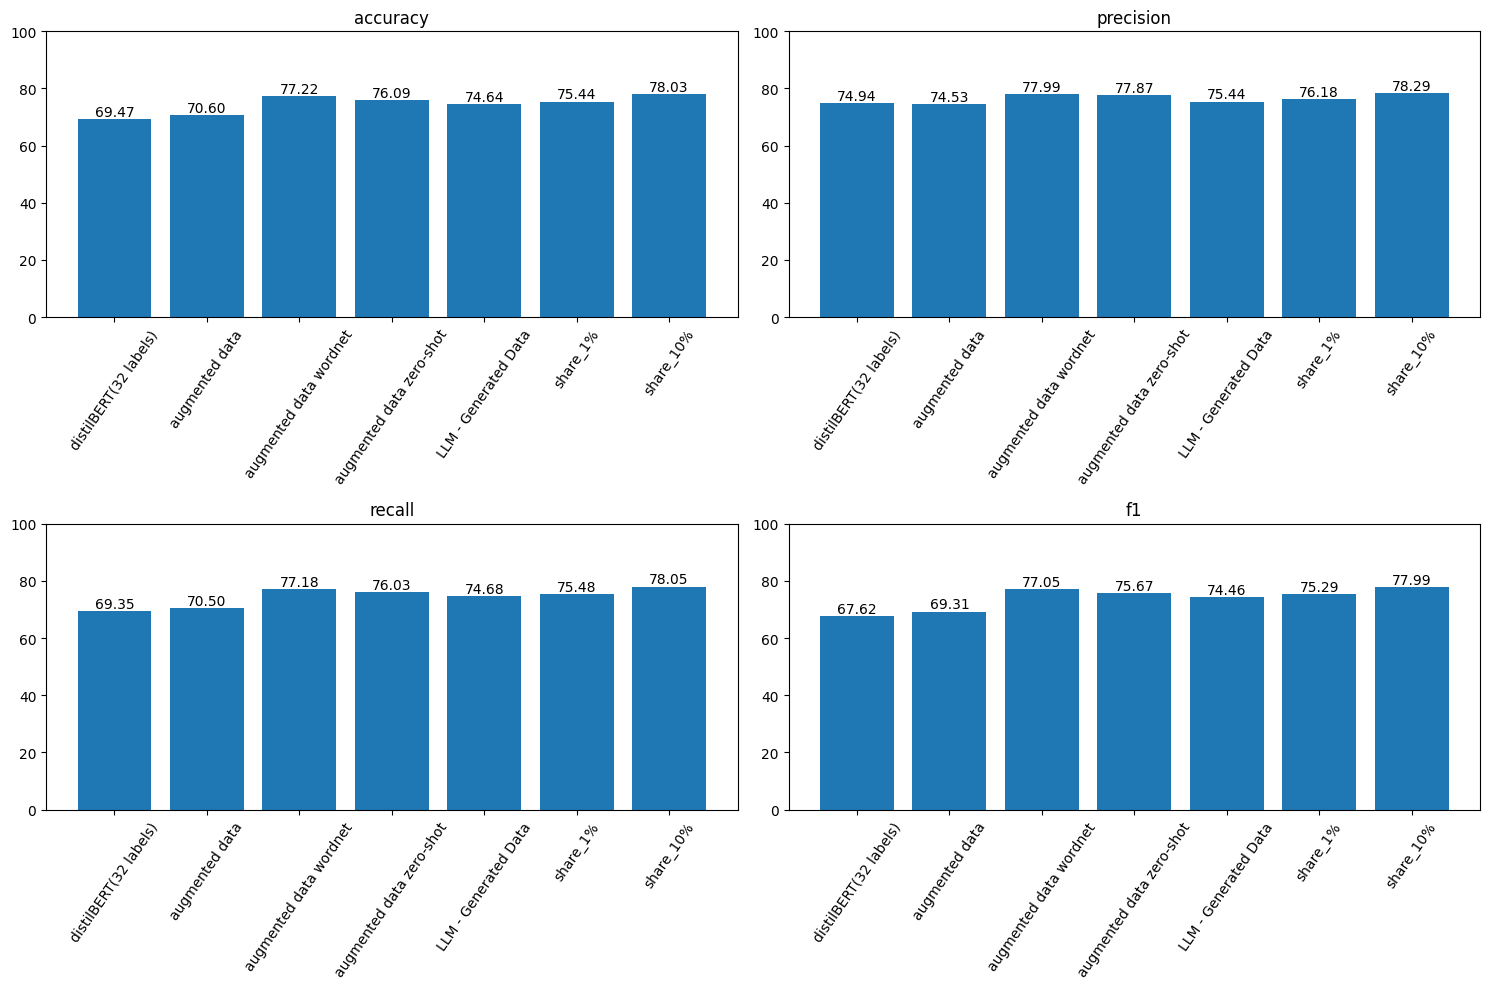

In [133]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data wordnet")
metrics_val.plot()
tf.keras.backend.clear_session()

---

# c. Zero-Shot Learning with LLM
#### For the Zero-Shot setup we found different LLM models from Huggingface which we tried to see which one gave us the best accuracy testing them with the validation data. Finally it was "facebook/bart-large-mnli" the one it gave us the best results as demonstrated in the following part

In [ ]:
from transformers import pipeline

model_name = "facebook/bart-large-mnli"  # Adjust model name as needed

# Combine the elements from both lists
combined_list = list(zip(validation_data, validation_labels))

# Shuffle the combined list
random.shuffle(combined_list)

# Get the random sample from the combined list
sample_size = 300  # Define the size of the sample
random_sample = random.sample(combined_list, sample_size)

# Separate the sampled elements back into separate lists
sampled_list1, sampled_list2 = zip(*random_sample)

print("Sampled elements from list1:", sampled_list1)
print("Sampled elements from list2:", sampled_list2)

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ['positive', 'negative']

# Store the predictions for each item in a list
predictions = []

# Iterate over each text sample in test_data
for text_sample in sampled_list1:
    # Use the classifier pipeline to predict the label
    result = classifier(text_sample, candidate_labels)

    # Get the label with the highest score
    if result['scores'][0] >= result['scores'][1]:
        predicted_label = result['labels'][0]
    else:
        predicted_label = result['labels'][1]

    # Append the predicted label to the predictions list
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

In [ ]:
zero_predictions = [1 if prediction == 'positive' else 0 for prediction in predictions]

# Calculate accuracy
accuracy = accuracy_score(sampled_list2, predictions)

# Calculate precision
precision = precision_score(sampled_list2, predictions, average='binary')

# Calculate recall
recall = recall_score(sampled_list2, predictions, average='binary')

# Calculate F1 score
f1 = f1_score(sampled_list2, predictions, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [98]:
model_name = "facebook/bart-large-mnli"  # Adjust model name as needed

df_val_sampled = df_val.sample(n=299, random_state=42)
sampled_list1 = (df_val_sampled['text']).tolist()

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ['positive', 'negative']

# Store the predictions for each item in a list
predictions = []

# Iterate over each text sample in test_data
for text_sample in sampled_list1:
    # Use the classifier pipeline to predict the label
    result = classifier(text_sample, candidate_labels)

    # Get the label with the highest score
    if result['scores'][0] >= result['scores'][1]:
        predicted_label = result['labels'][0]
    else:
        predicted_label = result['labels'][1]

    # Append the predicted label to the predictions list
    predictions.append(predicted_label)

# Print the predictions
print(predictions)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

['positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'ne

In [99]:
zero_predictions = [1 if prediction == 'positive' else 0 for prediction in predictions]

# Update the "label" column with values from sampled_list2
df_val_sampled['label'] = zero_predictions

# Display the updated DataFrame
print(df_val_sampled.head())

                                                  text  label  text_length  \
281  watching SNL   yay for @jtimberlake hosting!  ...      1            9   
265  @sara3isenough maybe thrush?  That's the time ...      0           14   
164  All my V-necks are ruined!  The collars are al...      0           22   
9    @Jonasbrothers  Hi jonas brothers  you came to...      1           11   
77   @tommcfly http://twitpic.com/3l9e5 -  Gio and ...      1           10   

                                            clean_text clean_emotions hashtag  \
281          watching snl yay for hosting ! i love him                          
265  maybe thrush ? that ' s the time i recall latc...                          
164  all my v - necks are ruined ! the collars are ...                          
9    hi jonas brothers you came to argentina la otr...                          
77                 - gio and you are so sweet together                          

                                          te

#### Now we train our Roberta model once again adding the data obtained with Zero-Shot to the 32 labeled

In [100]:
# Add new_rows to df_train_32
augmented_zero_df = pd.concat([df_train_32, df_val_sampled], ignore_index=True)

# Display the augmented DataFrame
print(augmented_zero_df.shape)

(331, 7)


In [101]:
augmented_zero_df_data = augmented_zero_df['clean_text']
augmented_zero_df_label = augmented_zero_df['label']

In [102]:
y_train = enc.fit_transform(np.array(augmented_zero_df_label).reshape(-1, 1)).toarray()

X_train = np.array(augmented_zero_df_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)




Epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/2





Epoch:   2%|▏         | 1/41 [00:30<20:19, 30.48s/it]

 1/41 [..............................] - ETA: 20:45 - loss: 0.5801 - recall: 0.8750 - precision: 0.8750




Epoch:   7%|▋         | 3/41 [00:31<05:11,  8.19s/it]

 2/41 [>.............................] - ETA: 31s - loss: 1.2943 - recall: 0.8125 - precision: 0.8125  




Epoch:  10%|▉         | 4/41 [00:32<03:28,  5.64s/it]

 3/41 [=>............................] - ETA: 30s - loss: 0.9810 - recall: 0.8333 - precision: 0.8333




Epoch:  12%|█▏        | 5/41 [00:32<02:25,  4.04s/it]

 4/41 [=>............................] - ETA: 30s - loss: 0.7834 - recall: 0.8438 - precision: 0.8438




Epoch:  15%|█▍        | 6/41 [00:33<01:45,  3.01s/it]

 5/41 [==>...........................] - ETA: 29s - loss: 0.6374 - recall: 0.8750 - precision: 0.8750




Epoch:  17%|█▋        | 7/41 [00:34<01:19,  2.33s/it]

 6/41 [===>..........................] - ETA: 29s - loss: 0.6365 - recall: 0.8750 - precision: 0.8750




Epoch:  20%|█▉        | 8/41 [00:35<01:01,  1.87s/it]

 7/41 [====>.........................] - ETA: 28s - loss: 0.5581 - recall: 0.8929 - precision: 0.8929




Epoch:  22%|██▏       | 9/41 [00:36<00:49,  1.55s/it]

 8/41 [====>.........................] - ETA: 27s - loss: 0.6349 - recall: 0.8750 - precision: 0.8750




Epoch:  24%|██▍       | 10/41 [00:37<00:41,  1.33s/it]

 9/41 [=====>........................] - ETA: 26s - loss: 0.5797 - recall: 0.8750 - precision: 0.8750




Epoch:  27%|██▋       | 11/41 [00:37<00:35,  1.18s/it]

10/41 [======>.......................] - ETA: 25s - loss: 0.5752 - recall: 0.8750 - precision: 0.8750




Epoch:  29%|██▉       | 12/41 [00:38<00:31,  1.07s/it]

11/41 [=======>......................] - ETA: 24s - loss: 0.6186 - recall: 0.8636 - precision: 0.8636




Epoch:  32%|███▏      | 13/41 [00:39<00:27,  1.03it/s]

12/41 [=======>......................] - ETA: 23s - loss: 0.6117 - recall: 0.8646 - precision: 0.8646




Epoch:  34%|███▍      | 14/41 [00:40<00:24,  1.10it/s]

13/41 [========>.....................] - ETA: 22s - loss: 0.6207 - recall: 0.8558 - precision: 0.8558




Epoch:  37%|███▋      | 15/41 [00:41<00:22,  1.13it/s]

14/41 [=========>....................] - ETA: 22s - loss: 0.6646 - recall: 0.8393 - precision: 0.8393




Epoch:  39%|███▉      | 16/41 [00:41<00:21,  1.16it/s]

15/41 [=========>....................] - ETA: 21s - loss: 0.6766 - recall: 0.8250 - precision: 0.8250




Epoch:  41%|████▏     | 17/41 [00:42<00:20,  1.19it/s]

16/41 [==========>...................] - ETA: 20s - loss: 0.6643 - recall: 0.8203 - precision: 0.8203




Epoch:  44%|████▍     | 18/41 [00:43<00:18,  1.22it/s]

17/41 [===========>..................] - ETA: 19s - loss: 0.6533 - recall: 0.8162 - precision: 0.8162




Epoch:  46%|████▋     | 19/41 [00:44<00:17,  1.23it/s]

18/41 [============>.................] - ETA: 19s - loss: 0.6391 - recall: 0.8194 - precision: 0.8194




Epoch:  49%|████▉     | 20/41 [00:45<00:19,  1.09it/s]

19/41 [============>.................] - ETA: 18s - loss: 0.6419 - recall: 0.8092 - precision: 0.8092




Epoch:  51%|█████     | 21/41 [00:46<00:21,  1.05s/it]

20/41 [=============>................] - ETA: 18s - loss: 0.6158 - recall: 0.8188 - precision: 0.8188




Epoch:  54%|█████▎    | 22/41 [00:47<00:20,  1.06s/it]

21/41 [==============>...............] - ETA: 17s - loss: 0.6041 - recall: 0.8214 - precision: 0.8214




Epoch:  56%|█████▌    | 23/41 [00:48<00:19,  1.07s/it]

22/41 [===============>..............] - ETA: 16s - loss: 0.5905 - recall: 0.8239 - precision: 0.8239




Epoch:  59%|█████▊    | 24/41 [00:49<00:17,  1.03s/it]

23/41 [===============>..............] - ETA: 15s - loss: 0.5846 - recall: 0.8207 - precision: 0.8207




Epoch:  61%|██████    | 25/41 [00:50<00:15,  1.02it/s]

24/41 [================>.............] - ETA: 14s - loss: 0.5928 - recall: 0.8229 - precision: 0.8229




Epoch:  63%|██████▎   | 26/41 [00:51<00:13,  1.10it/s]

25/41 [=================>............] - ETA: 14s - loss: 0.5840 - recall: 0.8200 - precision: 0.8200




Epoch:  66%|██████▌   | 27/41 [00:52<00:12,  1.15it/s]

26/41 [==================>...........] - ETA: 13s - loss: 0.5889 - recall: 0.8125 - precision: 0.8125




Epoch:  68%|██████▊   | 28/41 [00:52<00:10,  1.21it/s]

27/41 [==================>...........] - ETA: 12s - loss: 0.5903 - recall: 0.8056 - precision: 0.8056




Epoch:  71%|███████   | 29/41 [00:53<00:09,  1.23it/s]

28/41 [===================>..........] - ETA: 11s - loss: 0.5904 - recall: 0.7946 - precision: 0.7946




Epoch:  73%|███████▎  | 30/41 [00:54<00:08,  1.24it/s]

29/41 [====================>.........] - ETA: 10s - loss: 0.5846 - recall: 0.7974 - precision: 0.7974




Epoch:  76%|███████▌  | 31/41 [00:55<00:07,  1.25it/s]

30/41 [====================>.........] - ETA: 9s - loss: 0.5772 - recall: 0.8000 - precision: 0.8000 




Epoch:  78%|███████▊  | 32/41 [00:56<00:07,  1.27it/s]

31/41 [=====================>........] - ETA: 8s - loss: 0.5841 - recall: 0.7944 - precision: 0.7944




Epoch:  80%|████████  | 33/41 [00:56<00:06,  1.28it/s]

32/41 [======================>.......] - ETA: 7s - loss: 0.5883 - recall: 0.7891 - precision: 0.7891




Epoch:  83%|████████▎ | 34/41 [00:57<00:05,  1.28it/s]

33/41 [=======================>......] - ETA: 6s - loss: 0.5869 - recall: 0.7879 - precision: 0.7879




Epoch:  85%|████████▌ | 35/41 [00:58<00:04,  1.28it/s]

34/41 [=======================>......] - ETA: 5s - loss: 0.5831 - recall: 0.7868 - precision: 0.7868




Epoch:  88%|████████▊ | 36/41 [00:59<00:03,  1.26it/s]

35/41 [========================>.....] - ETA: 5s - loss: 0.5850 - recall: 0.7821 - precision: 0.7821




Epoch:  90%|█████████ | 37/41 [01:00<00:03,  1.26it/s]

36/41 [=========================>....] - ETA: 4s - loss: 0.5772 - recall: 0.7847 - precision: 0.7847




Epoch:  93%|█████████▎| 38/41 [01:00<00:02,  1.28it/s]

37/41 [==========================>...] - ETA: 3s - loss: 0.5820 - recall: 0.7770 - precision: 0.7770




Epoch:  95%|█████████▌| 39/41 [01:01<00:01,  1.29it/s]

38/41 [==========================>...] - ETA: 2s - loss: 0.5709 - recall: 0.7829 - precision: 0.7829




Epoch:  98%|█████████▊| 40/41 [01:02<00:00,  1.30it/s]

39/41 [===========================>..] - ETA: 1s - loss: 0.5762 - recall: 0.7821 - precision: 0.7821




Epoch: 100%|██████████| 41/41 [01:03<00:00,  1.29it/s]

40/41 [============================>.] - ETA: 0s - loss: 0.5669 - recall: 0.7875 - precision: 0.7875




Epoch: 42it [01:03,  1.30it/s]                        

41/41 [==============================] - 65s 834ms/step - loss: 0.5699 - recall: 0.7805 - precision: 0.7805
Epoch 2/2





Epoch: 43it [01:04,  1.30it/s]

 1/41 [..............................] - ETA: 23s - loss: 0.3524 - recall: 1.0000 - precision: 1.0000




Epoch: 44it [01:05,  1.40it/s]

 2/41 [>.............................] - ETA: 29s - loss: 0.4612 - recall: 0.8182 - precision: 0.8182




Epoch: 45it [01:05,  1.37it/s]

 3/41 [=>............................] - ETA: 29s - loss: 0.4255 - recall: 0.7895 - precision: 0.7895




Epoch: 46it [01:06,  1.34it/s]

 4/41 [=>............................] - ETA: 28s - loss: 0.3495 - recall: 0.8519 - precision: 0.8519




Epoch: 47it [01:07,  1.34it/s]

 5/41 [==>...........................] - ETA: 27s - loss: 0.2899 - recall: 0.8857 - precision: 0.8857




Epoch: 48it [01:08,  1.31it/s]

 6/41 [===>..........................] - ETA: 27s - loss: 0.2714 - recall: 0.8837 - precision: 0.8837




Epoch: 49it [01:09,  1.24it/s]

 7/41 [====>.........................] - ETA: 27s - loss: 0.2624 - recall: 0.8824 - precision: 0.8824




Epoch: 50it [01:10,  1.22it/s]

 8/41 [====>.........................] - ETA: 26s - loss: 0.2458 - recall: 0.8983 - precision: 0.8983




Epoch: 51it [01:10,  1.21it/s]

 9/41 [=====>........................] - ETA: 26s - loss: 0.2335 - recall: 0.9104 - precision: 0.9104




Epoch: 52it [01:11,  1.21it/s]

10/41 [======>.......................] - ETA: 25s - loss: 0.2862 - recall: 0.8933 - precision: 0.8933




Epoch: 53it [01:12,  1.21it/s]

11/41 [=======>......................] - ETA: 24s - loss: 0.2966 - recall: 0.8916 - precision: 0.8916




Epoch: 54it [01:13,  1.20it/s]

12/41 [=======>......................] - ETA: 24s - loss: 0.3114 - recall: 0.8791 - precision: 0.8791




Epoch: 55it [01:14,  1.17it/s]

13/41 [========>.....................] - ETA: 23s - loss: 0.3074 - recall: 0.8687 - precision: 0.8687




Epoch: 56it [01:15,  1.18it/s]

14/41 [=========>....................] - ETA: 22s - loss: 0.2988 - recall: 0.8692 - precision: 0.8692




Epoch: 57it [01:16,  1.17it/s]

15/41 [=========>....................] - ETA: 21s - loss: 0.2933 - recall: 0.8696 - precision: 0.8696




Epoch: 58it [01:16,  1.20it/s]

16/41 [==========>...................] - ETA: 20s - loss: 0.2799 - recall: 0.8780 - precision: 0.8780




Epoch: 59it [01:17,  1.22it/s]

17/41 [===========>..................] - ETA: 19s - loss: 0.2839 - recall: 0.8702 - precision: 0.8702




Epoch: 60it [01:18,  1.23it/s]

18/41 [============>.................] - ETA: 18s - loss: 0.2844 - recall: 0.8633 - precision: 0.8633




Epoch: 61it [01:19,  1.23it/s]

19/41 [============>.................] - ETA: 18s - loss: 0.2761 - recall: 0.8707 - precision: 0.8707




Epoch: 62it [01:20,  1.21it/s]

20/41 [=============>................] - ETA: 17s - loss: 0.2654 - recall: 0.8774 - precision: 0.8774




Epoch: 63it [01:20,  1.23it/s]

21/41 [==============>...............] - ETA: 16s - loss: 0.2747 - recall: 0.8773 - precision: 0.8773




Epoch: 64it [01:21,  1.25it/s]

22/41 [===============>..............] - ETA: 15s - loss: 0.2646 - recall: 0.8830 - precision: 0.8830




Epoch: 65it [01:22,  1.28it/s]

23/41 [===============>..............] - ETA: 14s - loss: 0.2542 - recall: 0.8883 - precision: 0.8883




Epoch: 66it [01:23,  1.29it/s]

24/41 [================>.............] - ETA: 13s - loss: 0.2713 - recall: 0.8877 - precision: 0.8877




Epoch: 67it [01:23,  1.28it/s]

25/41 [=================>............] - ETA: 12s - loss: 0.2614 - recall: 0.8923 - precision: 0.8923




Epoch: 68it [01:24,  1.28it/s]

26/41 [==================>...........] - ETA: 12s - loss: 0.2625 - recall: 0.8867 - precision: 0.8867




Epoch: 69it [01:25,  1.27it/s]

27/41 [==================>...........] - ETA: 11s - loss: 0.2560 - recall: 0.8910 - precision: 0.8910




Epoch: 70it [01:26,  1.26it/s]

28/41 [===================>..........] - ETA: 10s - loss: 0.2858 - recall: 0.8813 - precision: 0.8813




Epoch: 71it [01:27,  1.22it/s]

29/41 [====================>.........] - ETA: 9s - loss: 0.3000 - recall: 0.8811 - precision: 0.8811 




Epoch: 72it [01:28,  1.22it/s]

30/41 [====================>.........] - ETA: 8s - loss: 0.2921 - recall: 0.8851 - precision: 0.8851




Epoch: 73it [01:28,  1.20it/s]

31/41 [=====================>........] - ETA: 8s - loss: 0.2884 - recall: 0.8848 - precision: 0.8848




Epoch: 74it [01:29,  1.18it/s]

32/41 [======================>.......] - ETA: 7s - loss: 0.2836 - recall: 0.8884 - precision: 0.8884




Epoch: 75it [01:30,  1.18it/s]

33/41 [=======================>......] - ETA: 6s - loss: 0.3050 - recall: 0.8842 - precision: 0.8842




Epoch: 76it [01:31,  1.18it/s]

34/41 [=======================>......] - ETA: 5s - loss: 0.3017 - recall: 0.8839 - precision: 0.8839




Epoch: 77it [01:32,  1.21it/s]

35/41 [========================>.....] - ETA: 4s - loss: 0.3031 - recall: 0.8836 - precision: 0.8836




Epoch: 78it [01:33,  1.23it/s]

36/41 [=========================>....] - ETA: 4s - loss: 0.2968 - recall: 0.8869 - precision: 0.8869




Epoch: 79it [01:33,  1.25it/s]

37/41 [==========================>...] - ETA: 3s - loss: 0.3067 - recall: 0.8832 - precision: 0.8832




Epoch: 80it [01:34,  1.27it/s]

38/41 [==========================>...] - ETA: 2s - loss: 0.3085 - recall: 0.8829 - precision: 0.8829




Epoch: 81it [01:35,  1.29it/s]

39/41 [===========================>..] - ETA: 1s - loss: 0.3063 - recall: 0.8827 - precision: 0.8827




Epoch: 82it [01:35,  1.32it/s]

40/41 [============================>.] - ETA: 0s - loss: 0.3001 - recall: 0.8857 - precision: 0.8857




Epoch: 83it [01:36,  1.36it/s]

41/41 [==============================] - 33s 803ms/step - loss: 0.2975 - recall: 0.8854 - precision: 0.8854


In [103]:
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 11s 404ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


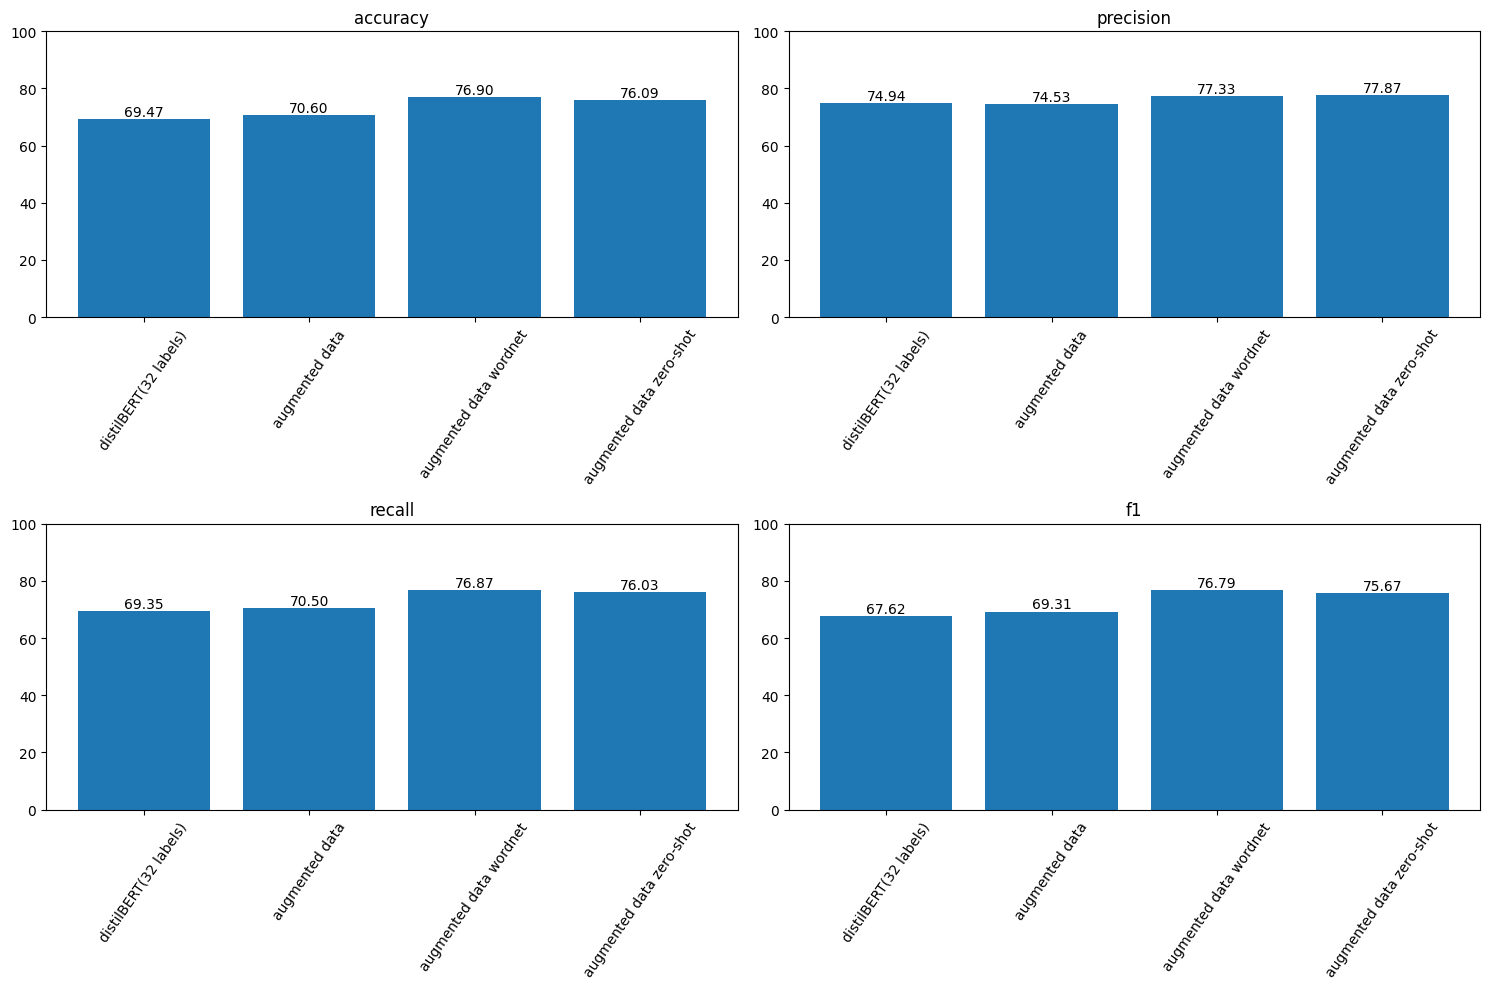

In [104]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "augmented data zero-shot")
metrics_val.plot()
tf.keras.backend.clear_session()

#### We get a nice increase in the performance of our model, probably because of the size of the data, since we were training our model with only 32 samples and now we are adding 300 more samples, even though they are not 100% accurate, is still gives a lot more information for the model to work better

---

# d. Data Generation with LLM

In [105]:
# Output path to keep the generated answers:
path_output = []

prompts = []

initial_prompt = """
Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment labeling scheme.

Additional Instructions:
- Ensure that the generated tweets are coherent, grammatically correct, and resemble natural Twitter language.
- Aim for diversity in the generated tweets to cover a wide range of sentiment expressions.
- Pay attention to the sentiment labels assigned to each generated tweet, maintaining consistency with the labeling scheme.

Data Format:
- Each generated tweet should be accompanied by its corresponding sentiment label (1 for positive, 0 for negative) and the context.
- Output format: Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]

Example Output:
Tweet_: "Just finished watching the latest episode of my favorite TV show! Absolutely loved it!" Sentiment_: 1 Context_: "Normal"
Tweet_: "Stuck in traffic again! This commute is unbearable." Sentiment_: 0 Context_: "Normal"

The next ("PROMPT") will follow this structure:
"Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]"

Where Number is equal to the number of tweets to generate, Sentiment will be positive or negative.
And Context will be one of the following options [Normal, Sarcasm, Irony] where you adapt the generated tweets to the given context.
"""

following_prompts = """
Please generate {{number}} {{sentiment}} tweets with the following context {{context}}. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]
"""

following_prompts = Template(following_prompts)
sentiment_list = ["positive","negative"]
context_list = ['Normal','Normal','Sarcasm','Irony'] # Two times 'Normal' to have more of these

In [106]:
print(initial_prompt)


Title: Twitter Sentiment Analysis Data Generation

Description: In this project, the goal is to classify the sentiment of tweets as either positive (1) or negative (0).
We have a dataset called TSATC (Twitter Sentiment Analysis Training Corpus). Each tweet is labeled with either a 1 for positive sentiment or a 0 for negative sentiment.

Task: We aim to enhance our dataset by generating new labeled data points using a Large Language Model (LLM).
By leveraging the capabilities of LLMs, we seek to create additional labeled examples to improve the performance of our sentiment analysis model.

Prompt:
Given the context provided above, you will be asked to generate new tweets with sentiment labels (1 for positive sentiment, 0 for negative sentiment).
You can use the existing tweets as inspiration to generate new ones, ensuring that the generated tweets reflect similar sentiment patterns.
The generated tweets should maintain relevance to real-world Twitter content and adhere to the sentiment

In [107]:
print(following_prompts.render(number=50, sentiment="positive", context="Normal"))


Please generate 50 positive tweets with the following context Normal. Only return your answers in the following format:
Tweet_: [Tweet text] Sentiment_: [1 or 0] Context_: [context]


In [108]:
#client = OpenAI(api_key=tatiana_key)

In [109]:
# As only 50 tweets are asked in each prompt, we multiply the number of demands by 3.
all_prompts = [initial_prompt] + 3*[following_prompts.render(number=50,sentiment="negative", context=con) for con in context_list] + 3*[following_prompts.render(number=50,sentiment="positive", context=con) for con in context_list]
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]

In [110]:
"""gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"""

"gpt_tweets = [client.chat.completions.create(messages=msg, model='gpt-3.5-turbo').choices[0].message.content for msg in tqdm(all_prompts)]"

In [111]:
"""print(len(gpt_tweets))
gpt_tweets[1]"""

'print(len(gpt_tweets))\ngpt_tweets[1]'

### Save the generated tweets in a csv file to reduce the number of GPT requests made.

In [112]:
"""
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Tweet', 'Sentiment', 'Context'])

# Iterate through each element in gpt_tweets starting from index 1
for tweet_info_set in gpt_tweets[1:]:
    # Split the element by newline character to separate the lines
    tweet_info_lines = tweet_info_set.split('\n')

    # Initialize variables to store tweet, sentiment, and context
    tweet = []
    sentiment = []
    context = []

    # Iterate through each line in the tweet_info_lines
    for twt in tweet_info_lines:
        # Extract tweet, sentiment, and context from each line
        if "Tweet_:" in twt or "Tweet:" in twt:
          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]
          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]
          tweet.append(tweet_)

        if "Sentiment_:" in twt or "Sentiment:" in twt:
          sentiment_ = twt.split("Sentiment_:")[1].split() if "Sentiment_:" in twt else twt.split("Sentiment:")[1]
          sentiment_ = sentiment_[0] if sentiment_[0] in ["1","0"] else sentiment_[1]
          sentiment.append(sentiment_)

        if "Context_:" in twt or "Context:" in twt:
          context_ = twt.split("Context_:")[1] if "Context_:" in twt else twt.split("Context:")[1]
          context.append(context_)

    # Check they all have the same length
    if len(tweet) == len(sentiment) == len(context):
        # Create a DataFrame from the extracted tweet, sentiment, and context
        df = pd.concat([df, pd.DataFrame({'Tweet': tweet, 'Sentiment': sentiment, 'Context': context})], ignore_index=True)
    else:
      print("An error has occured the data is not correct!")

# Display the DataFrame
df.head()
"""

'\n# Initialize an empty DataFrame\ndf = pd.DataFrame(columns=[\'Tweet\', \'Sentiment\', \'Context\'])\n\n# Iterate through each element in gpt_tweets starting from index 1\nfor tweet_info_set in gpt_tweets[1:]:\n    # Split the element by newline character to separate the lines\n    tweet_info_lines = tweet_info_set.split(\'\n\')\n\n    # Initialize variables to store tweet, sentiment, and context\n    tweet = []\n    sentiment = []\n    context = []\n\n    # Iterate through each line in the tweet_info_lines\n    for twt in tweet_info_lines:\n        # Extract tweet, sentiment, and context from each line\n        if "Tweet_:" in twt or "Tweet:" in twt:\n          tweet_ = twt.split("Tweet_:")[1] if "Tweet_:" in twt else twt.split("Tweet:")[1]\n          tweet_ = tweet_.split("Sentiment:")[0] if "Sentiment:" in tweet_ else tweet_.split("Sentiment_:")[0]\n          tweet.append(tweet_)\n\n        if "Sentiment_:" in twt or "Sentiment:" in twt:\n          sentiment_ = twt.split("Sentimen

In [113]:
"""# Save the tweets into a csv format:
from google.colab import drive
drive.mount('/content/drive')

# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.
df.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"""

"# Save the tweets into a csv format:\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# To reduce the number of requestes made to GPT we will save the generated tweets and skip the generating process for the future useages.\ndf.to_csv('/content/drive/My Drive/gpt_tweets.csv', index=False)"

In [115]:
# Load csv file containing the generated tweets
df = pd.read_csv("/content/gpt_tweets.csv")

df['Context'] = df['Context'].str.strip()
df.rename(columns={'Tweet': 'text', 'Sentiment': 'label'}, inplace=True)

In [116]:
# Inspect Data
print(df.shape)
df.isna().sum()

(1135, 3)


text       0
label      0
Context    0
dtype: int64

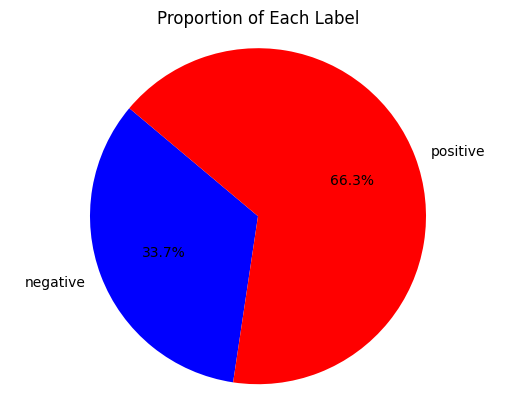

In [117]:
# Check Positive vs Negative Ratio:
label_counts = Counter(df['label'])
labels = {0: 'negative', 1: 'positive'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Label')
plt.show()

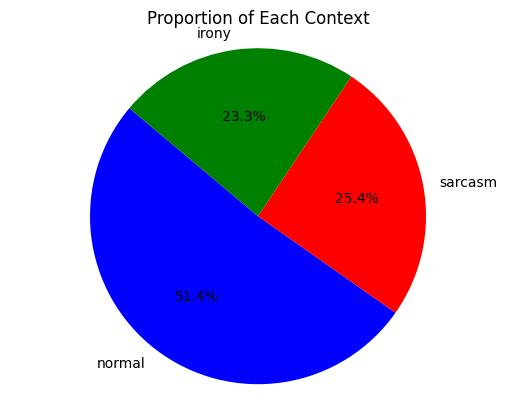

In [118]:
# Check Context Ratio:
label_counts = Counter(df['Context'])
labels = {'Normal': 'normal', 'Sarcasm': 'sarcasm', 'Irony':'irony'}

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['blue', 'red', 'green']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Proportion of Each Context')
plt.show()

In [119]:
# 5 examples of each tweet category possible, (positive vs negative), (Normal, Irony, Sarcasm)
unique_contexts = df['Context'].unique()

# Iterate over each unique context
for context in unique_contexts:
    print(f"Context: {context}")
    # Filter the DataFrame for the current context
    context_df = df[df['Context'] == context]
    # Filter positive tweets
    positive_tweets = context_df[context_df['label'] == 1]['text'].head(5)
    print("Positive Tweets:")
    for tweet in positive_tweets:
        print(tweet)
    # Filter negative tweets
    negative_tweets = context_df[context_df['label'] == 0]['text'].head(5)
    print("Negative Tweets:")
    for tweet in negative_tweets:
        print(tweet)
    print()

Context: Normal
Positive Tweets:
 Love starting my day with a cup of coffee and some good music! 
 Grateful for the sunny weather today, it's such a mood booster! 
 Just finished a great workout and feeling energized for the day ahead. 
 Spending time with loved ones always puts a smile on my face. 
 Excited to dive into a new book I've been waiting to read! 
Negative Tweets:
 Normal is overrated. 
 Can't stand being average, but that's what normal is all about. 
 Normal is just code for boring. 
 The idea of being normal makes me cringe. 
 Trying to fit in with the norm is exhausting. 

Context: Sarcasm
Positive Tweets:
 I just love when people take up two parking spots. So considerate. 
 I always look forward to getting stuck in traffic. It's the highlight of my day. 
 Ah, nothing like waking up to a pile of dirty dishes in the sink. Pure bliss. 
 Can't get enough of spam emails. They really brighten up my inbox. 
 Oh, I absolutely adore it when my phone dies right in the middle of a

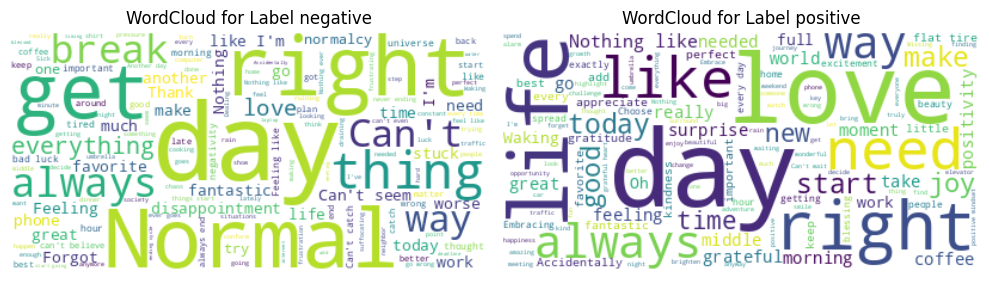

In [120]:
# Word Could of the generated tweets from chat gpt
labels = {0: 'negative', 1: 'positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df['text'], df['label']):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [121]:
df['text_length'] = 0
df = clean_text(df)

train_data_generated = df["text"]
train_labels_generated = df["label"]

In [122]:
y_train = enc.fit_transform(np.array(train_labels_generated).reshape(-1, 1)).toarray()

X_train = np.array(train_data_generated)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Wrap the batches generator with tqdm
batches_with_progress = tqdm_generator(batches, steps_per_epoch)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Now, pass the wrapped generator to fit
bert_model.fit(batches_with_progress, epochs=2, steps_per_epoch=steps_per_epoch)





Epoch:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/2






Epoch:   1%|          | 1/141 [00:31<1:13:53, 31.67s/it]

  1/141 [..............................] - ETA: 1:15:06 - loss: 0.4475 - recall: 0.7500 - precision: 0.7500





Epoch:   2%|▏         | 3/141 [00:32<19:30,  8.48s/it]  

  2/141 [..............................] - ETA: 1:45 - loss: 0.3602 - recall: 0.8125 - precision: 0.8125   





Epoch:   3%|▎         | 4/141 [00:33<13:15,  5.81s/it]

  3/141 [..............................] - ETA: 1:44 - loss: 0.3527 - recall: 0.8333 - precision: 0.8333





Epoch:   4%|▎         | 5/141 [00:33<09:22,  4.14s/it]

  4/141 [..............................] - ETA: 1:44 - loss: 0.3276 - recall: 0.8438 - precision: 0.8438





Epoch:   4%|▍         | 6/141 [00:34<06:53,  3.06s/it]

  5/141 [>.............................] - ETA: 1:43 - loss: 0.4147 - recall: 0.8250 - precision: 0.8250





Epoch:   5%|▍         | 7/141 [00:35<05:13,  2.34s/it]

  6/141 [>.............................] - ETA: 1:42 - loss: 0.3530 - recall: 0.8542 - precision: 0.8542





Epoch:   6%|▌         | 8/141 [00:36<04:05,  1.85s/it]

  7/141 [>.............................] - ETA: 1:43 - loss: 0.3274 - recall: 0.8750 - precision: 0.8750





Epoch:   6%|▋         | 9/141 [00:37<03:22,  1.53s/it]

  8/141 [>.............................] - ETA: 1:44 - loss: 0.3533 - recall: 0.8594 - precision: 0.8594





Epoch:   7%|▋         | 10/141 [00:37<02:54,  1.33s/it]

  9/141 [>.............................] - ETA: 1:45 - loss: 0.4173 - recall: 0.8611 - precision: 0.8611





Epoch:   8%|▊         | 11/141 [00:38<02:35,  1.20s/it]

 10/141 [=>............................] - ETA: 1:45 - loss: 0.4213 - recall: 0.8500 - precision: 0.8500





Epoch:   9%|▊         | 12/141 [00:39<02:19,  1.08s/it]

 11/141 [=>............................] - ETA: 1:45 - loss: 0.3914 - recall: 0.8636 - precision: 0.8636





Epoch:   9%|▉         | 13/141 [00:40<02:10,  1.02s/it]

 12/141 [=>............................] - ETA: 1:45 - loss: 0.3777 - recall: 0.8646 - precision: 0.8646





Epoch:  10%|▉         | 14/141 [00:41<02:04,  1.02it/s]

 13/141 [=>............................] - ETA: 1:44 - loss: 0.3986 - recall: 0.8558 - precision: 0.8558





Epoch:  11%|█         | 15/141 [00:42<01:58,  1.06it/s]

 14/141 [=>............................] - ETA: 1:44 - loss: 0.3771 - recall: 0.8661 - precision: 0.8661





Epoch:  11%|█▏        | 16/141 [00:43<01:55,  1.09it/s]

 15/141 [==>...........................] - ETA: 1:44 - loss: 0.3772 - recall: 0.8667 - precision: 0.8667





Epoch:  12%|█▏        | 17/141 [00:43<01:52,  1.11it/s]

 16/141 [==>...........................] - ETA: 1:43 - loss: 0.4172 - recall: 0.8672 - precision: 0.8672





Epoch:  13%|█▎        | 18/141 [00:44<01:51,  1.11it/s]

 17/141 [==>...........................] - ETA: 1:43 - loss: 0.4282 - recall: 0.8603 - precision: 0.8603





Epoch:  13%|█▎        | 19/141 [00:45<01:47,  1.13it/s]

 18/141 [==>...........................] - ETA: 1:42 - loss: 0.4295 - recall: 0.8542 - precision: 0.8542





Epoch:  14%|█▍        | 20/141 [00:46<01:43,  1.17it/s]

 19/141 [===>..........................] - ETA: 1:40 - loss: 0.4526 - recall: 0.8421 - precision: 0.8421





Epoch:  15%|█▍        | 21/141 [00:47<01:39,  1.21it/s]

 20/141 [===>..........................] - ETA: 1:39 - loss: 0.4394 - recall: 0.8438 - precision: 0.8438





Epoch:  16%|█▌        | 22/141 [00:48<01:37,  1.22it/s]

 21/141 [===>..........................] - ETA: 1:38 - loss: 0.4345 - recall: 0.8393 - precision: 0.8393





Epoch:  16%|█▋        | 23/141 [00:48<01:35,  1.24it/s]

 22/141 [===>..........................] - ETA: 1:37 - loss: 0.4568 - recall: 0.8239 - precision: 0.8239





Epoch:  17%|█▋        | 24/141 [00:49<01:33,  1.25it/s]

 23/141 [===>..........................] - ETA: 1:36 - loss: 0.4441 - recall: 0.8315 - precision: 0.8315





Epoch:  18%|█▊        | 25/141 [00:50<01:34,  1.23it/s]

 24/141 [====>.........................] - ETA: 1:35 - loss: 0.4366 - recall: 0.8333 - precision: 0.8333





Epoch:  18%|█▊        | 26/141 [00:51<01:31,  1.26it/s]

 25/141 [====>.........................] - ETA: 1:34 - loss: 0.4262 - recall: 0.8350 - precision: 0.8350





Epoch:  19%|█▉        | 27/141 [00:51<01:29,  1.28it/s]

 26/141 [====>.........................] - ETA: 1:33 - loss: 0.4333 - recall: 0.8317 - precision: 0.8317





Epoch:  20%|█▉        | 28/141 [00:52<01:29,  1.26it/s]

 27/141 [====>.........................] - ETA: 1:33 - loss: 0.4385 - recall: 0.8287 - precision: 0.8287





Epoch:  21%|██        | 29/141 [00:53<01:30,  1.24it/s]

 28/141 [====>.........................] - ETA: 1:32 - loss: 0.4430 - recall: 0.8259 - precision: 0.8259





Epoch:  21%|██▏       | 30/141 [00:54<01:30,  1.22it/s]

 29/141 [=====>........................] - ETA: 1:31 - loss: 0.4313 - recall: 0.8319 - precision: 0.8319





Epoch:  22%|██▏       | 31/141 [00:55<01:31,  1.21it/s]

 30/141 [=====>........................] - ETA: 1:30 - loss: 0.4408 - recall: 0.8292 - precision: 0.8292





Epoch:  23%|██▎       | 32/141 [00:56<01:30,  1.21it/s]

 31/141 [=====>........................] - ETA: 1:30 - loss: 0.4353 - recall: 0.8347 - precision: 0.8347





Epoch:  23%|██▎       | 33/141 [00:57<01:30,  1.19it/s]

 32/141 [=====>........................] - ETA: 1:29 - loss: 0.4261 - recall: 0.8359 - precision: 0.8359





Epoch:  24%|██▍       | 34/141 [00:57<01:29,  1.20it/s]

 33/141 [======>.......................] - ETA: 1:28 - loss: 0.4288 - recall: 0.8333 - precision: 0.8333





Epoch:  25%|██▍       | 35/141 [00:58<01:27,  1.22it/s]

 34/141 [======>.......................] - ETA: 1:27 - loss: 0.4212 - recall: 0.8346 - precision: 0.8346





Epoch:  26%|██▌       | 36/141 [00:59<01:27,  1.19it/s]

 35/141 [======>.......................] - ETA: 1:27 - loss: 0.4260 - recall: 0.8321 - precision: 0.8321





Epoch:  26%|██▌       | 37/141 [01:00<01:29,  1.17it/s]

 36/141 [======>.......................] - ETA: 1:26 - loss: 0.4196 - recall: 0.8368 - precision: 0.8368





Epoch:  27%|██▋       | 38/141 [01:01<01:29,  1.15it/s]

 37/141 [======>.......................] - ETA: 1:25 - loss: 0.4134 - recall: 0.8412 - precision: 0.8412





Epoch:  28%|██▊       | 39/141 [01:02<01:26,  1.18it/s]

 38/141 [=======>......................] - ETA: 1:24 - loss: 0.4073 - recall: 0.8421 - precision: 0.8421





Epoch:  28%|██▊       | 40/141 [01:02<01:24,  1.20it/s]

 39/141 [=======>......................] - ETA: 1:23 - loss: 0.4012 - recall: 0.8462 - precision: 0.8462





Epoch:  29%|██▉       | 41/141 [01:03<01:19,  1.26it/s]

 40/141 [=======>......................] - ETA: 1:22 - loss: 0.4003 - recall: 0.8438 - precision: 0.8438





Epoch:  30%|██▉       | 42/141 [01:04<01:17,  1.27it/s]

 41/141 [=======>......................] - ETA: 1:21 - loss: 0.3974 - recall: 0.8445 - precision: 0.8445





Epoch:  30%|███       | 43/141 [01:05<01:16,  1.29it/s]

 42/141 [=======>......................] - ETA: 1:20 - loss: 0.3967 - recall: 0.8452 - precision: 0.8452





Epoch:  31%|███       | 44/141 [01:05<01:14,  1.31it/s]

 43/141 [========>.....................] - ETA: 1:19 - loss: 0.3912 - recall: 0.8459 - precision: 0.8459





Epoch:  32%|███▏      | 45/141 [01:06<01:12,  1.32it/s]

 44/141 [========>.....................] - ETA: 1:18 - loss: 0.3835 - recall: 0.8494 - precision: 0.8494





Epoch:  33%|███▎      | 46/141 [01:07<01:11,  1.33it/s]

 45/141 [========>.....................] - ETA: 1:17 - loss: 0.3824 - recall: 0.8500 - precision: 0.8500





Epoch:  33%|███▎      | 47/141 [01:08<01:11,  1.32it/s]

 46/141 [========>.....................] - ETA: 1:17 - loss: 0.3830 - recall: 0.8505 - precision: 0.8505





Epoch:  34%|███▍      | 48/141 [01:08<01:11,  1.29it/s]

 47/141 [=========>....................] - ETA: 1:16 - loss: 0.3764 - recall: 0.8537 - precision: 0.8537





Epoch:  35%|███▍      | 49/141 [01:09<01:11,  1.28it/s]

 48/141 [=========>....................] - ETA: 1:15 - loss: 0.3712 - recall: 0.8568 - precision: 0.8568





Epoch:  35%|███▌      | 50/141 [01:10<01:11,  1.27it/s]

 49/141 [=========>....................] - ETA: 1:14 - loss: 0.3694 - recall: 0.8571 - precision: 0.8571





Epoch:  36%|███▌      | 51/141 [01:11<01:11,  1.26it/s]

 50/141 [=========>....................] - ETA: 1:13 - loss: 0.3667 - recall: 0.8575 - precision: 0.8575





Epoch:  37%|███▋      | 52/141 [01:12<01:10,  1.26it/s]

 51/141 [=========>....................] - ETA: 1:12 - loss: 0.3740 - recall: 0.8554 - precision: 0.8554





Epoch:  38%|███▊      | 53/141 [01:12<01:09,  1.26it/s]

 52/141 [==========>...................] - ETA: 1:12 - loss: 0.3691 - recall: 0.8582 - precision: 0.8582





Epoch:  38%|███▊      | 54/141 [01:13<01:10,  1.24it/s]

 53/141 [==========>...................] - ETA: 1:11 - loss: 0.3636 - recall: 0.8608 - precision: 0.8608





Epoch:  39%|███▉      | 55/141 [01:14<01:11,  1.20it/s]

 54/141 [==========>...................] - ETA: 1:10 - loss: 0.3619 - recall: 0.8611 - precision: 0.8611





Epoch:  40%|███▉      | 56/141 [01:15<01:11,  1.18it/s]

 55/141 [==========>...................] - ETA: 1:09 - loss: 0.3574 - recall: 0.8636 - precision: 0.8636





Epoch:  40%|████      | 57/141 [01:16<01:09,  1.22it/s]

 56/141 [==========>...................] - ETA: 1:09 - loss: 0.3685 - recall: 0.8571 - precision: 0.8571





Epoch:  41%|████      | 58/141 [01:17<01:06,  1.25it/s]

 57/141 [===========>..................] - ETA: 1:08 - loss: 0.3725 - recall: 0.8553 - precision: 0.8553





Epoch:  42%|████▏     | 59/141 [01:17<01:04,  1.27it/s]

 58/141 [===========>..................] - ETA: 1:07 - loss: 0.3711 - recall: 0.8534 - precision: 0.8534





Epoch:  43%|████▎     | 60/141 [01:18<01:02,  1.30it/s]

 59/141 [===========>..................] - ETA: 1:06 - loss: 0.3716 - recall: 0.8538 - precision: 0.8538





Epoch:  43%|████▎     | 61/141 [01:19<01:01,  1.31it/s]

 60/141 [===========>..................] - ETA: 1:05 - loss: 0.3708 - recall: 0.8521 - precision: 0.8521





Epoch:  44%|████▍     | 62/141 [01:19<00:58,  1.35it/s]

 61/141 [===========>..................] - ETA: 1:04 - loss: 0.3665 - recall: 0.8545 - precision: 0.8545





Epoch:  45%|████▍     | 63/141 [01:20<00:56,  1.37it/s]

 62/141 [============>.................] - ETA: 1:03 - loss: 0.3634 - recall: 0.8569 - precision: 0.8569





Epoch:  45%|████▌     | 64/141 [01:21<00:55,  1.38it/s]

 63/141 [============>.................] - ETA: 1:02 - loss: 0.3583 - recall: 0.8591 - precision: 0.8591





Epoch:  46%|████▌     | 65/141 [01:22<00:55,  1.37it/s]

 64/141 [============>.................] - ETA: 1:01 - loss: 0.3551 - recall: 0.8613 - precision: 0.8613





Epoch:  47%|████▋     | 66/141 [01:22<00:54,  1.36it/s]

 65/141 [============>.................] - ETA: 1:00 - loss: 0.3533 - recall: 0.8596 - precision: 0.8596





Epoch:  48%|████▊     | 67/141 [01:23<00:54,  1.37it/s]

 66/141 [=============>................] - ETA: 59s - loss: 0.3581 - recall: 0.8598 - precision: 0.8598 





Epoch:  48%|████▊     | 68/141 [01:24<00:54,  1.34it/s]

 67/141 [=============>................] - ETA: 59s - loss: 0.3543 - recall: 0.8619 - precision: 0.8619





Epoch:  49%|████▉     | 69/141 [01:25<00:53,  1.34it/s]

 68/141 [=============>................] - ETA: 58s - loss: 0.3531 - recall: 0.8621 - precision: 0.8621





Epoch:  50%|████▉     | 70/141 [01:25<00:52,  1.34it/s]

 69/141 [=============>................] - ETA: 57s - loss: 0.3491 - recall: 0.8641 - precision: 0.8641





Epoch:  50%|█████     | 71/141 [01:26<00:51,  1.35it/s]

 70/141 [=============>................] - ETA: 56s - loss: 0.3488 - recall: 0.8643 - precision: 0.8643





Epoch:  51%|█████     | 72/141 [01:27<00:51,  1.34it/s]

 71/141 [==============>...............] - ETA: 55s - loss: 0.3472 - recall: 0.8627 - precision: 0.8627





Epoch:  52%|█████▏    | 73/141 [01:28<00:50,  1.35it/s]

 72/141 [==============>...............] - ETA: 54s - loss: 0.3443 - recall: 0.8646 - precision: 0.8646





Epoch:  52%|█████▏    | 74/141 [01:28<00:49,  1.36it/s]

 73/141 [==============>...............] - ETA: 53s - loss: 0.3438 - recall: 0.8647 - precision: 0.8647





Epoch:  53%|█████▎    | 75/141 [01:29<00:48,  1.36it/s]

 74/141 [==============>...............] - ETA: 53s - loss: 0.3413 - recall: 0.8649 - precision: 0.8649





Epoch:  54%|█████▍    | 76/141 [01:30<00:46,  1.39it/s]

 75/141 [==============>...............] - ETA: 52s - loss: 0.3382 - recall: 0.8667 - precision: 0.8667





Epoch:  55%|█████▍    | 77/141 [01:30<00:46,  1.38it/s]

 76/141 [===============>..............] - ETA: 51s - loss: 0.3364 - recall: 0.8668 - precision: 0.8668





Epoch:  55%|█████▌    | 78/141 [01:31<00:46,  1.37it/s]

 77/141 [===============>..............] - ETA: 50s - loss: 0.3358 - recall: 0.8669 - precision: 0.8669





Epoch:  56%|█████▌    | 79/141 [01:32<00:46,  1.34it/s]

 78/141 [===============>..............] - ETA: 49s - loss: 0.3350 - recall: 0.8654 - precision: 0.8654





Epoch:  57%|█████▋    | 80/141 [01:33<00:44,  1.37it/s]

 79/141 [===============>..............] - ETA: 48s - loss: 0.3389 - recall: 0.8623 - precision: 0.8623





Epoch:  57%|█████▋    | 81/141 [01:33<00:43,  1.37it/s]

 80/141 [================>.............] - ETA: 48s - loss: 0.3377 - recall: 0.8625 - precision: 0.8625





Epoch:  58%|█████▊    | 82/141 [01:34<00:43,  1.36it/s]

 81/141 [================>.............] - ETA: 47s - loss: 0.3347 - recall: 0.8642 - precision: 0.8642





Epoch:  59%|█████▉    | 83/141 [01:35<00:43,  1.33it/s]

 82/141 [================>.............] - ETA: 46s - loss: 0.3313 - recall: 0.8659 - precision: 0.8659





Epoch:  60%|█████▉    | 84/141 [01:36<00:42,  1.34it/s]

 83/141 [================>.............] - ETA: 45s - loss: 0.3308 - recall: 0.8660 - precision: 0.8660





Epoch:  60%|██████    | 85/141 [01:36<00:41,  1.35it/s]

 84/141 [================>.............] - ETA: 44s - loss: 0.3299 - recall: 0.8661 - precision: 0.8661





Epoch:  61%|██████    | 86/141 [01:37<00:40,  1.36it/s]

 85/141 [=================>............] - ETA: 43s - loss: 0.3276 - recall: 0.8662 - precision: 0.8662





Epoch:  62%|██████▏   | 87/141 [01:38<00:39,  1.35it/s]

 86/141 [=================>............] - ETA: 43s - loss: 0.3252 - recall: 0.8677 - precision: 0.8677





Epoch:  62%|██████▏   | 88/141 [01:39<00:39,  1.35it/s]

 87/141 [=================>............] - ETA: 42s - loss: 0.3228 - recall: 0.8678 - precision: 0.8678





Epoch:  63%|██████▎   | 89/141 [01:39<00:38,  1.36it/s]

 88/141 [=================>............] - ETA: 41s - loss: 0.3203 - recall: 0.8693 - precision: 0.8693





Epoch:  64%|██████▍   | 90/141 [01:40<00:37,  1.35it/s]

 89/141 [=================>............] - ETA: 40s - loss: 0.3189 - recall: 0.8708 - precision: 0.8708





Epoch:  65%|██████▍   | 91/141 [01:41<00:37,  1.34it/s]

 90/141 [==================>...........] - ETA: 39s - loss: 0.3178 - recall: 0.8708 - precision: 0.8708





Epoch:  65%|██████▌   | 92/141 [01:42<00:36,  1.36it/s]

 91/141 [==================>...........] - ETA: 39s - loss: 0.3154 - recall: 0.8723 - precision: 0.8723





Epoch:  66%|██████▌   | 93/141 [01:42<00:34,  1.37it/s]

 92/141 [==================>...........] - ETA: 38s - loss: 0.3152 - recall: 0.8723 - precision: 0.8723





Epoch:  67%|██████▋   | 94/141 [01:43<00:34,  1.37it/s]

 93/141 [==================>...........] - ETA: 37s - loss: 0.3136 - recall: 0.8723 - precision: 0.8723





Epoch:  67%|██████▋   | 95/141 [01:44<00:33,  1.36it/s]

 94/141 [===================>..........] - ETA: 36s - loss: 0.3110 - recall: 0.8737 - precision: 0.8737





Epoch:  68%|██████▊   | 96/141 [01:44<00:32,  1.37it/s]

 95/141 [===================>..........] - ETA: 35s - loss: 0.3105 - recall: 0.8737 - precision: 0.8737





Epoch:  69%|██████▉   | 97/141 [01:45<00:32,  1.34it/s]

 96/141 [===================>..........] - ETA: 35s - loss: 0.3073 - recall: 0.8750 - precision: 0.8750





Epoch:  70%|██████▉   | 98/141 [01:46<00:32,  1.34it/s]

 97/141 [===================>..........] - ETA: 34s - loss: 0.3044 - recall: 0.8763 - precision: 0.8763





Epoch:  70%|███████   | 99/141 [01:47<00:31,  1.32it/s]

 98/141 [===================>..........] - ETA: 33s - loss: 0.3016 - recall: 0.8776 - precision: 0.8776





Epoch:  71%|███████   | 100/141 [01:48<00:31,  1.31it/s]

 99/141 [====================>.........] - ETA: 32s - loss: 0.3043 - recall: 0.8775 - precision: 0.8775





Epoch:  72%|███████▏  | 101/141 [01:48<00:30,  1.30it/s]

100/141 [====================>.........] - ETA: 32s - loss: 0.3054 - recall: 0.8763 - precision: 0.8763





Epoch:  72%|███████▏  | 102/141 [01:49<00:30,  1.29it/s]

101/141 [====================>.........] - ETA: 31s - loss: 0.3028 - recall: 0.8775 - precision: 0.8775





Epoch:  73%|███████▎  | 103/141 [01:50<00:29,  1.29it/s]

102/141 [====================>.........] - ETA: 30s - loss: 0.3010 - recall: 0.8787 - precision: 0.8787





Epoch:  74%|███████▍  | 104/141 [01:51<00:28,  1.29it/s]

103/141 [====================>.........] - ETA: 29s - loss: 0.2981 - recall: 0.8799 - precision: 0.8799





Epoch:  74%|███████▍  | 105/141 [01:51<00:27,  1.29it/s]

104/141 [=====================>........] - ETA: 28s - loss: 0.3001 - recall: 0.8798 - precision: 0.8798





Epoch:  75%|███████▌  | 106/141 [01:52<00:27,  1.27it/s]

105/141 [=====================>........] - ETA: 28s - loss: 0.2978 - recall: 0.8810 - precision: 0.8810





Epoch:  76%|███████▌  | 107/141 [01:53<00:27,  1.24it/s]

106/141 [=====================>........] - ETA: 27s - loss: 0.2958 - recall: 0.8821 - precision: 0.8821





Epoch:  77%|███████▋  | 108/141 [01:54<00:26,  1.25it/s]

107/141 [=====================>........] - ETA: 26s - loss: 0.2931 - recall: 0.8832 - precision: 0.8832





Epoch:  77%|███████▋  | 109/141 [01:55<00:24,  1.28it/s]

108/141 [=====================>........] - ETA: 25s - loss: 0.2912 - recall: 0.8843 - precision: 0.8843





Epoch:  78%|███████▊  | 110/141 [01:55<00:23,  1.33it/s]

109/141 [======================>.......] - ETA: 24s - loss: 0.2908 - recall: 0.8830 - precision: 0.8830





Epoch:  79%|███████▊  | 111/141 [01:56<00:22,  1.36it/s]

110/141 [======================>.......] - ETA: 24s - loss: 0.2882 - recall: 0.8841 - precision: 0.8841





Epoch:  79%|███████▉  | 112/141 [01:57<00:21,  1.36it/s]

111/141 [======================>.......] - ETA: 23s - loss: 0.2925 - recall: 0.8829 - precision: 0.8829





Epoch:  80%|████████  | 113/141 [01:57<00:20,  1.37it/s]

112/141 [======================>.......] - ETA: 22s - loss: 0.2902 - recall: 0.8839 - precision: 0.8839





Epoch:  81%|████████  | 114/141 [01:58<00:19,  1.38it/s]

113/141 [=======================>......] - ETA: 21s - loss: 0.2882 - recall: 0.8850 - precision: 0.8850





Epoch:  82%|████████▏ | 115/141 [01:59<00:18,  1.39it/s]

114/141 [=======================>......] - ETA: 20s - loss: 0.2913 - recall: 0.8849 - precision: 0.8849





Epoch:  82%|████████▏ | 116/141 [02:00<00:18,  1.34it/s]

115/141 [=======================>......] - ETA: 20s - loss: 0.2914 - recall: 0.8848 - precision: 0.8848





Epoch:  83%|████████▎ | 117/141 [02:01<00:18,  1.31it/s]

116/141 [=======================>......] - ETA: 19s - loss: 0.2893 - recall: 0.8858 - precision: 0.8858





Epoch:  84%|████████▎ | 118/141 [02:01<00:17,  1.31it/s]

117/141 [=======================>......] - ETA: 18s - loss: 0.2893 - recall: 0.8857 - precision: 0.8857





Epoch:  84%|████████▍ | 119/141 [02:02<00:17,  1.28it/s]

118/141 [========================>.....] - ETA: 17s - loss: 0.2934 - recall: 0.8856 - precision: 0.8856





Epoch:  85%|████████▌ | 120/141 [02:03<00:16,  1.25it/s]

119/141 [========================>.....] - ETA: 17s - loss: 0.2985 - recall: 0.8834 - precision: 0.8834





Epoch:  86%|████████▌ | 121/141 [02:04<00:16,  1.23it/s]

120/141 [========================>.....] - ETA: 16s - loss: 0.2976 - recall: 0.8833 - precision: 0.8833





Epoch:  87%|████████▋ | 122/141 [02:05<00:15,  1.25it/s]

121/141 [========================>.....] - ETA: 15s - loss: 0.2957 - recall: 0.8843 - precision: 0.8843





Epoch:  87%|████████▋ | 123/141 [02:05<00:14,  1.26it/s]

122/141 [========================>.....] - ETA: 14s - loss: 0.2939 - recall: 0.8852 - precision: 0.8852





Epoch:  88%|████████▊ | 124/141 [02:06<00:13,  1.27it/s]

123/141 [=========================>....] - ETA: 14s - loss: 0.2932 - recall: 0.8852 - precision: 0.8852





Epoch:  89%|████████▊ | 125/141 [02:07<00:12,  1.28it/s]

124/141 [=========================>....] - ETA: 13s - loss: 0.2934 - recall: 0.8851 - precision: 0.8851





Epoch:  89%|████████▉ | 126/141 [02:08<00:11,  1.28it/s]

125/141 [=========================>....] - ETA: 12s - loss: 0.2931 - recall: 0.8850 - precision: 0.8850





Epoch:  90%|█████████ | 127/141 [02:08<00:11,  1.27it/s]

126/141 [=========================>....] - ETA: 11s - loss: 0.2953 - recall: 0.8829 - precision: 0.8829





Epoch:  91%|█████████ | 128/141 [02:09<00:10,  1.25it/s]

127/141 [==========================>...] - ETA: 10s - loss: 0.2943 - recall: 0.8839 - precision: 0.8839





Epoch:  91%|█████████▏| 129/141 [02:10<00:09,  1.26it/s]

128/141 [==========================>...] - ETA: 10s - loss: 0.2922 - recall: 0.8848 - precision: 0.8848





Epoch:  92%|█████████▏| 130/141 [02:11<00:08,  1.27it/s]

129/141 [==========================>...] - ETA: 9s - loss: 0.2913 - recall: 0.8857 - precision: 0.8857 





Epoch:  93%|█████████▎| 131/141 [02:12<00:07,  1.27it/s]

130/141 [==========================>...] - ETA: 8s - loss: 0.2923 - recall: 0.8846 - precision: 0.8846





Epoch:  94%|█████████▎| 132/141 [02:12<00:07,  1.28it/s]

131/141 [==========================>...] - ETA: 7s - loss: 0.2914 - recall: 0.8845 - precision: 0.8845





Epoch:  94%|█████████▍| 133/141 [02:13<00:06,  1.30it/s]

132/141 [===========================>..] - ETA: 7s - loss: 0.2898 - recall: 0.8854 - precision: 0.8854





Epoch:  95%|█████████▌| 134/141 [02:14<00:05,  1.30it/s]

133/141 [===========================>..] - ETA: 6s - loss: 0.2924 - recall: 0.8844 - precision: 0.8844





Epoch:  96%|█████████▌| 135/141 [02:15<00:04,  1.30it/s]

134/141 [===========================>..] - ETA: 5s - loss: 0.2959 - recall: 0.8815 - precision: 0.8815





Epoch:  96%|█████████▋| 136/141 [02:15<00:03,  1.31it/s]

135/141 [===========================>..] - ETA: 4s - loss: 0.2947 - recall: 0.8824 - precision: 0.8824





Epoch:  97%|█████████▋| 137/141 [02:16<00:03,  1.29it/s]

136/141 [===========================>..] - ETA: 3s - loss: 0.2942 - recall: 0.8814 - precision: 0.8814





Epoch:  98%|█████████▊| 138/141 [02:17<00:02,  1.30it/s]

137/141 [============================>.] - ETA: 3s - loss: 0.2923 - recall: 0.8823 - precision: 0.8823





Epoch:  99%|█████████▊| 139/141 [02:18<00:01,  1.28it/s]

138/141 [============================>.] - ETA: 2s - loss: 0.2908 - recall: 0.8832 - precision: 0.8832





Epoch:  99%|█████████▉| 140/141 [02:19<00:00,  1.28it/s]

139/141 [============================>.] - ETA: 1s - loss: 0.2923 - recall: 0.8831 - precision: 0.8831





Epoch: 100%|██████████| 141/141 [02:19<00:00,  1.27it/s]

140/141 [============================>.] - ETA: 0s - loss: 0.2907 - recall: 0.8839 - precision: 0.8839





Epoch: 142it [02:20,  1.29it/s]                         

141/141 [==============================] - 141s 779ms/step - loss: 0.2889 - recall: 0.8848 - precision: 0.8848
Epoch 2/2






Epoch: 143it [02:21,  1.27it/s]

  1/141 [..............................] - ETA: 1:50 - loss: 0.8305 - recall: 0.8571 - precision: 0.8571





Epoch: 144it [02:22,  1.27it/s]

  2/141 [..............................] - ETA: 1:52 - loss: 0.4100 - recall: 0.9333 - precision: 0.9333





Epoch: 145it [02:23,  1.26it/s]

  3/141 [..............................] - ETA: 1:54 - loss: 0.2801 - recall: 0.9565 - precision: 0.9565





Epoch: 146it [02:23,  1.23it/s]

  4/141 [..............................] - ETA: 1:53 - loss: 0.2256 - recall: 0.9677 - precision: 0.9677





Epoch: 147it [02:24,  1.22it/s]

  5/141 [>.............................] - ETA: 1:52 - loss: 0.2044 - recall: 0.9487 - precision: 0.9487





Epoch: 148it [02:25,  1.22it/s]

  6/141 [>.............................] - ETA: 1:52 - loss: 0.1737 - recall: 0.9574 - precision: 0.9574





Epoch: 149it [02:26,  1.21it/s]

  7/141 [>.............................] - ETA: 1:49 - loss: 0.1553 - recall: 0.9636 - precision: 0.9636





Epoch: 150it [02:27,  1.25it/s]

  8/141 [>.............................] - ETA: 1:47 - loss: 0.2118 - recall: 0.9365 - precision: 0.9365





Epoch: 151it [02:27,  1.27it/s]

  9/141 [>.............................] - ETA: 1:45 - loss: 0.2137 - recall: 0.9296 - precision: 0.9296





Epoch: 152it [02:28,  1.29it/s]

 10/141 [=>............................] - ETA: 1:44 - loss: 0.1948 - recall: 0.9367 - precision: 0.9367





Epoch: 153it [02:29,  1.30it/s]

 11/141 [=>............................] - ETA: 1:42 - loss: 0.1777 - recall: 0.9425 - precision: 0.9425





Epoch: 154it [02:30,  1.33it/s]

 12/141 [=>............................] - ETA: 1:41 - loss: 0.1670 - recall: 0.9474 - precision: 0.9474





Epoch: 155it [02:30,  1.30it/s]

 13/141 [=>............................] - ETA: 1:40 - loss: 0.1795 - recall: 0.9320 - precision: 0.9320





Epoch: 156it [02:31,  1.33it/s]

 14/141 [=>............................] - ETA: 1:39 - loss: 0.1669 - recall: 0.9369 - precision: 0.9369





Epoch: 157it [02:32,  1.31it/s]

 15/141 [==>...........................] - ETA: 1:38 - loss: 0.1576 - recall: 0.9412 - precision: 0.9412





Epoch: 158it [02:33,  1.32it/s]

 16/141 [==>...........................] - ETA: 1:36 - loss: 0.1621 - recall: 0.9291 - precision: 0.9291





Epoch: 159it [02:33,  1.35it/s]

 17/141 [==>...........................] - ETA: 1:35 - loss: 0.1646 - recall: 0.9259 - precision: 0.9259





Epoch: 160it [02:34,  1.36it/s]

 18/141 [==>...........................] - ETA: 1:34 - loss: 0.1606 - recall: 0.9301 - precision: 0.9301





Epoch: 161it [02:35,  1.34it/s]

 19/141 [===>..........................] - ETA: 1:34 - loss: 0.1556 - recall: 0.9338 - precision: 0.9338





Epoch: 162it [02:36,  1.33it/s]

 20/141 [===>..........................] - ETA: 1:33 - loss: 0.1523 - recall: 0.9371 - precision: 0.9371





Epoch: 163it [02:36,  1.32it/s]

 21/141 [===>..........................] - ETA: 1:32 - loss: 0.1452 - recall: 0.9401 - precision: 0.9401





Epoch: 164it [02:37,  1.32it/s]

 22/141 [===>..........................] - ETA: 1:31 - loss: 0.1418 - recall: 0.9429 - precision: 0.9429





Epoch: 165it [02:38,  1.31it/s]

 23/141 [===>..........................] - ETA: 1:30 - loss: 0.1381 - recall: 0.9454 - precision: 0.9454





Epoch: 166it [02:39,  1.32it/s]

 24/141 [====>.........................] - ETA: 1:29 - loss: 0.1367 - recall: 0.9476 - precision: 0.9476





Epoch: 167it [02:39,  1.34it/s]

 25/141 [====>.........................] - ETA: 1:28 - loss: 0.1315 - recall: 0.9497 - precision: 0.9497





Epoch: 168it [02:40,  1.36it/s]

 26/141 [====>.........................] - ETA: 1:28 - loss: 0.1321 - recall: 0.9517 - precision: 0.9517





Epoch: 169it [02:41,  1.33it/s]

 27/141 [====>.........................] - ETA: 1:27 - loss: 0.1366 - recall: 0.9488 - precision: 0.9488





Epoch: 170it [02:42,  1.35it/s]

 28/141 [====>.........................] - ETA: 1:26 - loss: 0.1317 - recall: 0.9507 - precision: 0.9507





Epoch: 171it [02:42,  1.34it/s]

 29/141 [=====>........................] - ETA: 1:25 - loss: 0.1290 - recall: 0.9524 - precision: 0.9524





Epoch: 172it [02:43,  1.35it/s]

 30/141 [=====>........................] - ETA: 1:24 - loss: 0.1521 - recall: 0.9456 - precision: 0.9456





Epoch: 173it [02:44,  1.33it/s]

 31/141 [=====>........................] - ETA: 1:23 - loss: 0.1498 - recall: 0.9474 - precision: 0.9474





Epoch: 174it [02:45,  1.33it/s]

 32/141 [=====>........................] - ETA: 1:23 - loss: 0.1467 - recall: 0.9490 - precision: 0.9490





Epoch: 175it [02:45,  1.34it/s]

 33/141 [======>.......................] - ETA: 1:22 - loss: 0.1427 - recall: 0.9506 - precision: 0.9506





Epoch: 176it [02:46,  1.36it/s]

 34/141 [======>.......................] - ETA: 1:21 - loss: 0.1388 - recall: 0.9520 - precision: 0.9520





Epoch: 177it [02:47,  1.35it/s]

 35/141 [======>.......................] - ETA: 1:20 - loss: 0.1348 - recall: 0.9534 - precision: 0.9534





Epoch: 178it [02:48,  1.36it/s]

 36/141 [======>.......................] - ETA: 1:19 - loss: 0.1321 - recall: 0.9547 - precision: 0.9547





Epoch: 179it [02:48,  1.35it/s]

 37/141 [======>.......................] - ETA: 1:18 - loss: 0.1310 - recall: 0.9525 - precision: 0.9525





Epoch: 180it [02:49,  1.34it/s]

 38/141 [=======>......................] - ETA: 1:17 - loss: 0.1279 - recall: 0.9538 - precision: 0.9538





Epoch: 181it [02:50,  1.38it/s]

 39/141 [=======>......................] - ETA: 1:17 - loss: 0.1500 - recall: 0.9486 - precision: 0.9486





Epoch: 182it [02:50,  1.39it/s]

 40/141 [=======>......................] - ETA: 1:16 - loss: 0.1500 - recall: 0.9467 - precision: 0.9467





Epoch: 183it [02:51,  1.42it/s]

 41/141 [=======>......................] - ETA: 1:15 - loss: 0.1508 - recall: 0.9450 - precision: 0.9450





Epoch: 184it [02:52,  1.40it/s]

 42/141 [=======>......................] - ETA: 1:14 - loss: 0.1525 - recall: 0.9433 - precision: 0.9433





Epoch: 185it [02:53,  1.39it/s]

 43/141 [========>.....................] - ETA: 1:13 - loss: 0.1495 - recall: 0.9446 - precision: 0.9446





Epoch: 186it [02:53,  1.39it/s]

 44/141 [========>.....................] - ETA: 1:12 - loss: 0.1465 - recall: 0.9459 - precision: 0.9459





Epoch: 187it [02:54,  1.41it/s]

 45/141 [========>.....................] - ETA: 1:11 - loss: 0.1476 - recall: 0.9443 - precision: 0.9443





Epoch: 188it [02:55,  1.40it/s]

 46/141 [========>.....................] - ETA: 1:11 - loss: 0.1501 - recall: 0.9428 - precision: 0.9428





Epoch: 189it [02:55,  1.39it/s]

 47/141 [=========>....................] - ETA: 1:10 - loss: 0.1501 - recall: 0.9413 - precision: 0.9413





Epoch: 190it [02:56,  1.35it/s]

 48/141 [=========>....................] - ETA: 1:09 - loss: 0.1478 - recall: 0.9426 - precision: 0.9426





Epoch: 191it [02:57,  1.34it/s]

 49/141 [=========>....................] - ETA: 1:09 - loss: 0.1478 - recall: 0.9437 - precision: 0.9437





Epoch: 192it [02:58,  1.33it/s]

 50/141 [=========>....................] - ETA: 1:08 - loss: 0.1449 - recall: 0.9449 - precision: 0.9449





Epoch: 193it [02:59,  1.32it/s]

 51/141 [=========>....................] - ETA: 1:07 - loss: 0.1433 - recall: 0.9459 - precision: 0.9459





Epoch: 194it [02:59,  1.31it/s]

 52/141 [==========>...................] - ETA: 1:07 - loss: 0.1444 - recall: 0.9446 - precision: 0.9446





Epoch: 195it [03:00,  1.26it/s]

 53/141 [==========>...................] - ETA: 1:06 - loss: 0.1436 - recall: 0.9456 - precision: 0.9456





Epoch: 196it [03:01,  1.20it/s]

 54/141 [==========>...................] - ETA: 1:05 - loss: 0.1411 - recall: 0.9466 - precision: 0.9466





Epoch: 197it [03:02,  1.20it/s]

 55/141 [==========>...................] - ETA: 1:05 - loss: 0.1399 - recall: 0.9476 - precision: 0.9476





Epoch: 198it [03:03,  1.19it/s]

 56/141 [==========>...................] - ETA: 1:04 - loss: 0.1436 - recall: 0.9463 - precision: 0.9463





Epoch: 199it [03:04,  1.19it/s]

 57/141 [===========>..................] - ETA: 1:03 - loss: 0.1459 - recall: 0.9451 - precision: 0.9451





Epoch: 200it [03:04,  1.23it/s]

 58/141 [===========>..................] - ETA: 1:03 - loss: 0.1442 - recall: 0.9460 - precision: 0.9460





Epoch: 201it [03:05,  1.23it/s]

 59/141 [===========>..................] - ETA: 1:02 - loss: 0.1418 - recall: 0.9469 - precision: 0.9469





Epoch: 202it [03:06,  1.25it/s]

 60/141 [===========>..................] - ETA: 1:01 - loss: 0.1396 - recall: 0.9478 - precision: 0.9478





Epoch: 203it [03:07,  1.27it/s]

 61/141 [===========>..................] - ETA: 1:00 - loss: 0.1379 - recall: 0.9487 - precision: 0.9487





Epoch: 204it [03:07,  1.30it/s]

 62/141 [============>.................] - ETA: 1:00 - loss: 0.1366 - recall: 0.9495 - precision: 0.9495





Epoch: 205it [03:08,  1.28it/s]

 63/141 [============>.................] - ETA: 59s - loss: 0.1395 - recall: 0.9483 - precision: 0.9483 





Epoch: 206it [03:09,  1.28it/s]

 64/141 [============>.................] - ETA: 58s - loss: 0.1423 - recall: 0.9452 - precision: 0.9452





Epoch: 207it [03:10,  1.29it/s]

 65/141 [============>.................] - ETA: 57s - loss: 0.1438 - recall: 0.9441 - precision: 0.9441





Epoch: 208it [03:11,  1.30it/s]

 66/141 [=============>................] - ETA: 57s - loss: 0.1450 - recall: 0.9431 - precision: 0.9431





Epoch: 209it [03:11,  1.28it/s]

 67/141 [=============>................] - ETA: 56s - loss: 0.1435 - recall: 0.9439 - precision: 0.9439





Epoch: 210it [03:12,  1.26it/s]

 68/141 [=============>................] - ETA: 55s - loss: 0.1414 - recall: 0.9448 - precision: 0.9448





Epoch: 211it [03:13,  1.23it/s]

 69/141 [=============>................] - ETA: 55s - loss: 0.1395 - recall: 0.9456 - precision: 0.9456





Epoch: 212it [03:14,  1.24it/s]

 70/141 [=============>................] - ETA: 54s - loss: 0.1486 - recall: 0.9445 - precision: 0.9445





Epoch: 213it [03:15,  1.25it/s]

 71/141 [==============>...............] - ETA: 53s - loss: 0.1469 - recall: 0.9453 - precision: 0.9453





Epoch: 214it [03:15,  1.25it/s]

 72/141 [==============>...............] - ETA: 52s - loss: 0.1471 - recall: 0.9443 - precision: 0.9443





Epoch: 215it [03:16,  1.24it/s]

 73/141 [==============>...............] - ETA: 52s - loss: 0.1567 - recall: 0.9434 - precision: 0.9434





Epoch: 216it [03:17,  1.26it/s]

 74/141 [==============>...............] - ETA: 51s - loss: 0.1562 - recall: 0.9442 - precision: 0.9442





Epoch: 217it [03:18,  1.26it/s]

 75/141 [==============>...............] - ETA: 50s - loss: 0.1547 - recall: 0.9449 - precision: 0.9449





Epoch: 218it [03:19,  1.22it/s]

 76/141 [===============>..............] - ETA: 50s - loss: 0.1563 - recall: 0.9440 - precision: 0.9440





Epoch: 219it [03:20,  1.22it/s]

 77/141 [===============>..............] - ETA: 49s - loss: 0.1568 - recall: 0.9415 - precision: 0.9415





Epoch: 220it [03:20,  1.25it/s]

 78/141 [===============>..............] - ETA: 48s - loss: 0.1578 - recall: 0.9406 - precision: 0.9406





Epoch: 221it [03:21,  1.26it/s]

 79/141 [===============>..............] - ETA: 47s - loss: 0.1606 - recall: 0.9398 - precision: 0.9398





Epoch: 222it [03:22,  1.27it/s]

 80/141 [================>.............] - ETA: 46s - loss: 0.1612 - recall: 0.9390 - precision: 0.9390





Epoch: 223it [03:23,  1.30it/s]

 81/141 [================>.............] - ETA: 46s - loss: 0.1596 - recall: 0.9397 - precision: 0.9397





Epoch: 224it [03:23,  1.33it/s]

 82/141 [================>.............] - ETA: 45s - loss: 0.1583 - recall: 0.9405 - precision: 0.9405





Epoch: 225it [03:24,  1.33it/s]

 83/141 [================>.............] - ETA: 44s - loss: 0.1575 - recall: 0.9412 - precision: 0.9412





Epoch: 226it [03:25,  1.35it/s]

 84/141 [================>.............] - ETA: 43s - loss: 0.1557 - recall: 0.9419 - precision: 0.9419





Epoch: 227it [03:25,  1.33it/s]

 85/141 [=================>............] - ETA: 43s - loss: 0.1542 - recall: 0.9426 - precision: 0.9426





Epoch: 228it [03:26,  1.32it/s]

 86/141 [=================>............] - ETA: 42s - loss: 0.1525 - recall: 0.9432 - precision: 0.9432





Epoch: 229it [03:27,  1.29it/s]

 87/141 [=================>............] - ETA: 41s - loss: 0.1516 - recall: 0.9439 - precision: 0.9439





Epoch: 230it [03:28,  1.27it/s]

 88/141 [=================>............] - ETA: 40s - loss: 0.1508 - recall: 0.9445 - precision: 0.9445





Epoch: 231it [03:29,  1.26it/s]

 89/141 [=================>............] - ETA: 40s - loss: 0.1493 - recall: 0.9451 - precision: 0.9451





Epoch: 232it [03:30,  1.25it/s]

 90/141 [==================>...........] - ETA: 39s - loss: 0.1514 - recall: 0.9444 - precision: 0.9444





Epoch: 233it [03:30,  1.23it/s]

 91/141 [==================>...........] - ETA: 38s - loss: 0.1498 - recall: 0.9450 - precision: 0.9450





Epoch: 234it [03:31,  1.21it/s]

 92/141 [==================>...........] - ETA: 37s - loss: 0.1488 - recall: 0.9456 - precision: 0.9456





Epoch: 235it [03:32,  1.17it/s]

 93/141 [==================>...........] - ETA: 37s - loss: 0.1478 - recall: 0.9462 - precision: 0.9462





Epoch: 236it [03:33,  1.15it/s]

 94/141 [===================>..........] - ETA: 36s - loss: 0.1473 - recall: 0.9454 - precision: 0.9454





Epoch: 237it [03:34,  1.17it/s]

 95/141 [===================>..........] - ETA: 35s - loss: 0.1472 - recall: 0.9447 - precision: 0.9447





Epoch: 238it [03:35,  1.20it/s]

 96/141 [===================>..........] - ETA: 34s - loss: 0.1459 - recall: 0.9452 - precision: 0.9452





Epoch: 239it [03:35,  1.23it/s]

 97/141 [===================>..........] - ETA: 34s - loss: 0.1445 - recall: 0.9458 - precision: 0.9458





Epoch: 240it [03:36,  1.26it/s]

 98/141 [===================>..........] - ETA: 33s - loss: 0.1432 - recall: 0.9464 - precision: 0.9464





Epoch: 241it [03:37,  1.29it/s]

 99/141 [====================>.........] - ETA: 32s - loss: 0.1435 - recall: 0.9456 - precision: 0.9456





Epoch: 242it [03:38,  1.31it/s]

100/141 [====================>.........] - ETA: 31s - loss: 0.1421 - recall: 0.9462 - precision: 0.9462





Epoch: 243it [03:38,  1.31it/s]

101/141 [====================>.........] - ETA: 30s - loss: 0.1441 - recall: 0.9455 - precision: 0.9455





Epoch: 244it [03:39,  1.32it/s]

102/141 [====================>.........] - ETA: 30s - loss: 0.1427 - recall: 0.9460 - precision: 0.9460





Epoch: 245it [03:40,  1.32it/s]

103/141 [====================>.........] - ETA: 29s - loss: 0.1463 - recall: 0.9453 - precision: 0.9453





Epoch: 246it [03:41,  1.33it/s]

104/141 [=====================>........] - ETA: 28s - loss: 0.1480 - recall: 0.9446 - precision: 0.9446





Epoch: 247it [03:41,  1.34it/s]

105/141 [=====================>........] - ETA: 27s - loss: 0.1486 - recall: 0.9440 - precision: 0.9440





Epoch: 248it [03:42,  1.35it/s]

106/141 [=====================>........] - ETA: 27s - loss: 0.1474 - recall: 0.9445 - precision: 0.9445





Epoch: 249it [03:43,  1.36it/s]

107/141 [=====================>........] - ETA: 26s - loss: 0.1461 - recall: 0.9450 - precision: 0.9450





Epoch: 250it [03:44,  1.34it/s]

108/141 [=====================>........] - ETA: 25s - loss: 0.1461 - recall: 0.9444 - precision: 0.9444





Epoch: 251it [03:44,  1.35it/s]

109/141 [======================>.......] - ETA: 24s - loss: 0.1448 - recall: 0.9449 - precision: 0.9449





Epoch: 252it [03:45,  1.33it/s]

110/141 [======================>.......] - ETA: 23s - loss: 0.1435 - recall: 0.9454 - precision: 0.9454





Epoch: 253it [03:46,  1.35it/s]

111/141 [======================>.......] - ETA: 23s - loss: 0.1440 - recall: 0.9448 - precision: 0.9448





Epoch: 254it [03:47,  1.36it/s]

112/141 [======================>.......] - ETA: 22s - loss: 0.1440 - recall: 0.9453 - precision: 0.9453





Epoch: 255it [03:47,  1.36it/s]

113/141 [=======================>......] - ETA: 21s - loss: 0.1435 - recall: 0.9457 - precision: 0.9457





Epoch: 256it [03:48,  1.36it/s]

114/141 [=======================>......] - ETA: 20s - loss: 0.1423 - recall: 0.9462 - precision: 0.9462





Epoch: 257it [03:49,  1.37it/s]

115/141 [=======================>......] - ETA: 20s - loss: 0.1418 - recall: 0.9467 - precision: 0.9467





Epoch: 258it [03:49,  1.35it/s]

116/141 [=======================>......] - ETA: 19s - loss: 0.1418 - recall: 0.9461 - precision: 0.9461





Epoch: 259it [03:50,  1.36it/s]

117/141 [=======================>......] - ETA: 18s - loss: 0.1410 - recall: 0.9465 - precision: 0.9465





Epoch: 260it [03:51,  1.35it/s]

118/141 [========================>.....] - ETA: 17s - loss: 0.1398 - recall: 0.9470 - precision: 0.9470





Epoch: 261it [03:52,  1.37it/s]

119/141 [========================>.....] - ETA: 16s - loss: 0.1392 - recall: 0.9474 - precision: 0.9474





Epoch: 262it [03:52,  1.38it/s]

120/141 [========================>.....] - ETA: 16s - loss: 0.1387 - recall: 0.9479 - precision: 0.9479





Epoch: 263it [03:53,  1.38it/s]

121/141 [========================>.....] - ETA: 15s - loss: 0.1384 - recall: 0.9483 - precision: 0.9483





Epoch: 264it [03:54,  1.38it/s]

122/141 [========================>.....] - ETA: 14s - loss: 0.1375 - recall: 0.9487 - precision: 0.9487





Epoch: 265it [03:55,  1.37it/s]

123/141 [=========================>....] - ETA: 13s - loss: 0.1413 - recall: 0.9471 - precision: 0.9471





Epoch: 266it [03:55,  1.39it/s]

124/141 [=========================>....] - ETA: 13s - loss: 0.1415 - recall: 0.9465 - precision: 0.9465





Epoch: 267it [03:56,  1.40it/s]

125/141 [=========================>....] - ETA: 12s - loss: 0.1421 - recall: 0.9459 - precision: 0.9459





Epoch: 268it [03:57,  1.37it/s]

126/141 [=========================>....] - ETA: 11s - loss: 0.1411 - recall: 0.9464 - precision: 0.9464





Epoch: 269it [03:57,  1.36it/s]

127/141 [==========================>...] - ETA: 10s - loss: 0.1403 - recall: 0.9468 - precision: 0.9468





Epoch: 270it [03:58,  1.37it/s]

128/141 [==========================>...] - ETA: 9s - loss: 0.1397 - recall: 0.9472 - precision: 0.9472 





Epoch: 271it [03:59,  1.38it/s]

129/141 [==========================>...] - ETA: 9s - loss: 0.1386 - recall: 0.9476 - precision: 0.9476





Epoch: 272it [04:00,  1.36it/s]

130/141 [==========================>...] - ETA: 8s - loss: 0.1389 - recall: 0.9471 - precision: 0.9471





Epoch: 273it [04:00,  1.34it/s]

131/141 [==========================>...] - ETA: 7s - loss: 0.1379 - recall: 0.9475 - precision: 0.9475





Epoch: 274it [04:01,  1.30it/s]

132/141 [===========================>..] - ETA: 6s - loss: 0.1369 - recall: 0.9479 - precision: 0.9479





Epoch: 275it [04:02,  1.30it/s]

133/141 [===========================>..] - ETA: 6s - loss: 0.1378 - recall: 0.9473 - precision: 0.9473





Epoch: 276it [04:03,  1.32it/s]

134/141 [===========================>..] - ETA: 5s - loss: 0.1368 - recall: 0.9477 - precision: 0.9477





Epoch: 277it [04:04,  1.32it/s]

135/141 [===========================>..] - ETA: 4s - loss: 0.1378 - recall: 0.9472 - precision: 0.9472





Epoch: 278it [04:04,  1.32it/s]

136/141 [===========================>..] - ETA: 3s - loss: 0.1370 - recall: 0.9476 - precision: 0.9476





Epoch: 279it [04:05,  1.34it/s]

137/141 [============================>.] - ETA: 3s - loss: 0.1367 - recall: 0.9479 - precision: 0.9479





Epoch: 280it [04:06,  1.34it/s]

138/141 [============================>.] - ETA: 2s - loss: 0.1385 - recall: 0.9474 - precision: 0.9474





Epoch: 281it [04:07,  1.32it/s]

139/141 [============================>.] - ETA: 1s - loss: 0.1431 - recall: 0.9469 - precision: 0.9469





Epoch: 282it [04:07,  1.31it/s]

140/141 [============================>.] - ETA: 0s - loss: 0.1420 - recall: 0.9473 - precision: 0.9473





Epoch: 283it [04:08,  1.27it/s]

141/141 [==============================] - 108s 765ms/step - loss: 0.1413 - recall: 0.9476 - precision: 0.9476


In [123]:
valid_preds = bert_model.predict(inputs_valid)
valid_preds = np.argmax(valid_preds, axis=1)

20/20 [==============================] - 10s 357ms/step


<ipython-input-3-c69f3aa3134e>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results.keys(), rotation=55)


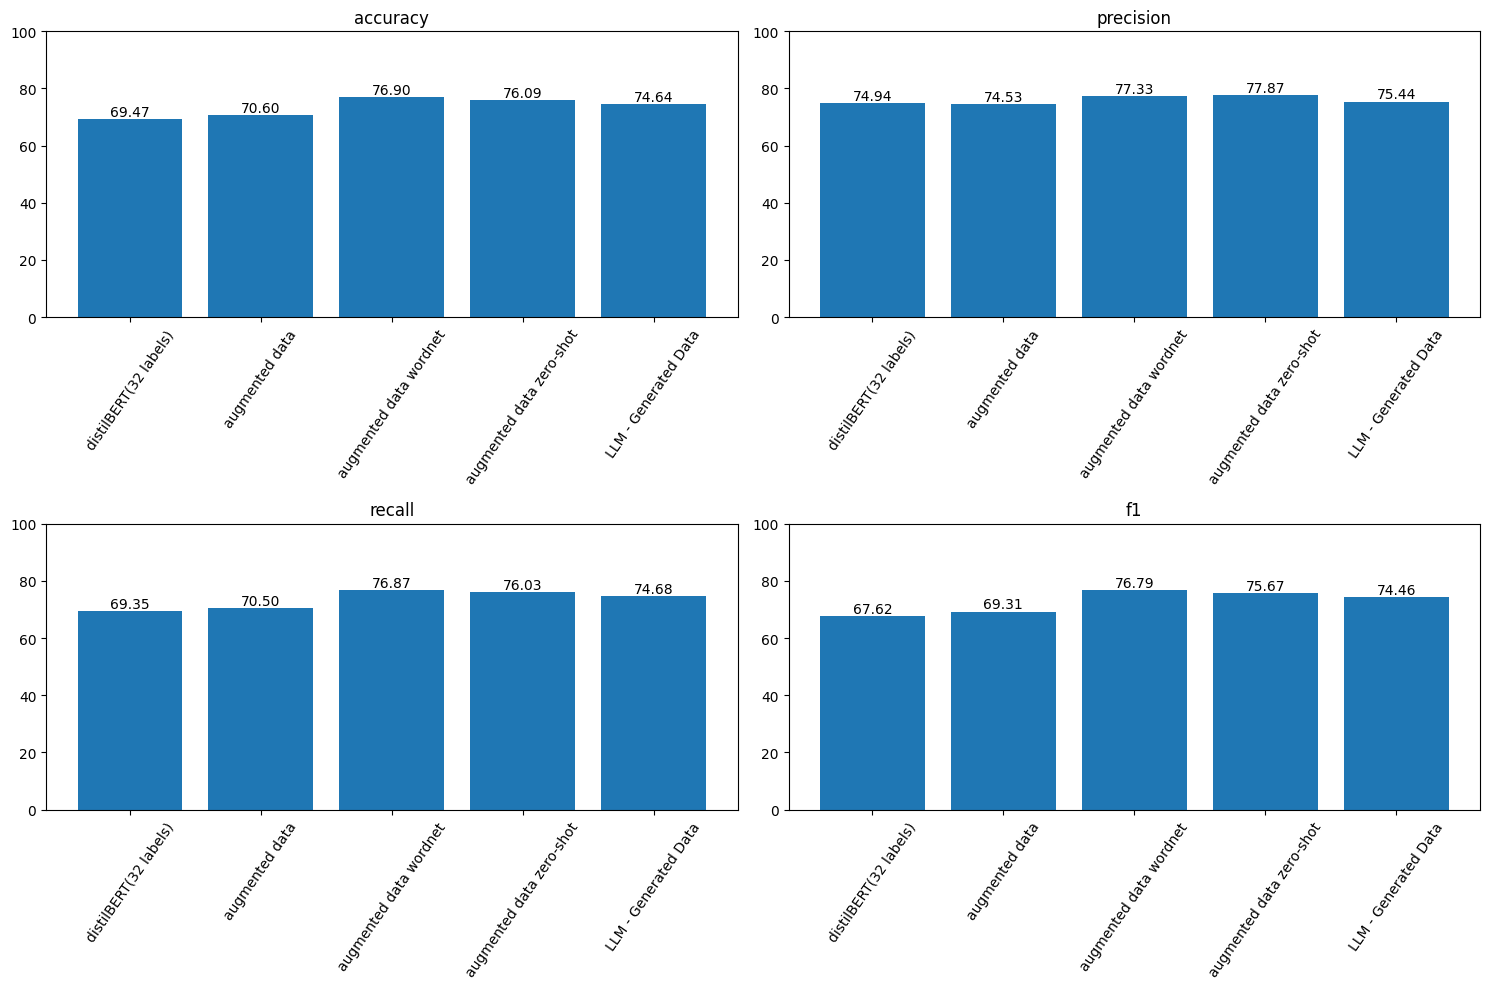

In [124]:
# get the final metrics
metrics_val.run(test_labels, valid_preds, "LLM - Generated Data")
metrics_val.plot()
tf.keras.backend.clear_session()

#### Here we can see that the performance doesn't change too much probably because the data obtained form OpenAI is not the best to train our model since all the sentences generated were to simple and very easy to label

# e. Optimal Technique Application

#### In our previous analysis, we presented the results of our model using various techniques. Among them, the model with Zero-Shot performed the best. We believe this result is reasonable because the other techniques had limitations. Augmented data, generated by adding synonyms, is highly similar to the existing data and provides minimal new information. Additionally, data obtained from OpenAI proved to be too simplistic and easily labeled, rendering it ineffective for improving model performance. Finally for the Zero-Shot we saw that, by itself, it already had a very good performance when predicting tweets, so the data added to our model, would be more extensive and although it might have some miss labeled cases, the diversity and amount of data it provides makes it the best option for our model.

---